In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader,TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import time
from torch.nn import init
from thop import profile

In [2]:
# Remember to install CUDA and cuDNN
# Determine if your system supports CUDA.
device = 'cuda' if torch.cuda.is_available() else 'cpu'  
#%% Read data
data=pd.read_hdf("D:/conda/FallAllD.h5") #
data = data.drop(columns = ['Gyr','Mag','Bar'])
#%% Label
data_waist = []
label_waist = []
subject_waist = []

for i in range(len(data)):
    if(data['Device'][i] == 'Waist'):
        a = data['Acc'][i]*0.000244
        # Normalize each data between 0 and 1
        b = b = (a-np.amin(a))/(np.amax(a)-np.amin(a)) 
        data_waist.append(b) 
        subject_waist.append(data['SubjectID'][i])
        # Class: fall = 0 ,ADL = 1 
        if (data['ActivityID'][i] > 100): 
            label_waist.append(1)
        else:
            label_waist.append(0)

# Change list to array
data_waist = np.array(data_waist)            
label_waist = np.array(label_waist)
subject_waist = np.array(subject_waist)

# Downsampling 1/128
down_data = []
# (start:size:step)
down_data = data_waist[::1,::128,::1]           
#%% Sliding_window
sliding_waist_data =[]
sliding_waist_label =[]
sliding_waist_subject =[]   

# The signal of each second 
per_sec = 38/20
sec = 7

In [3]:
for num in range(len(down_data)):
    if label_waist[num] ==1:
        # Data[index][start:end,axis]
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5)+1),:])
        # Label each window with class and subject
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        
    else:
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        
sliding_waist_data = np.array(sliding_waist_data)
sliding_waist_label = np.array(sliding_waist_label)
sliding_waist_subject = np.array(sliding_waist_subject) 

np.save('FallALLD_SW_data',sliding_waist_data)
np.save('FallALLD_SW_label',sliding_waist_label)
np.save('FallALLD_SW_subject',sliding_waist_subject)

In [4]:
#%% Show Teacher confusion matrix
def show_CM_teacher(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher) SubjectID' + str(sub) + '.png')

#%% Show Student confusion matrix
def show_CM_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Student) SubjectID' + str(sub) + '.png')
    
#%% Show Teacher-Student confusion matrix
def show_CM_teacher_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher-Student) SubjectID' + str(sub) + '.png')
def show_loss_teacher(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher) SubjectID' + str(sub) + '.png')
def show_Acc_teacher(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher) SubjectID' + str(sub) + '.png')
#Loss_student
def show_loss_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (Student) SubjectID' + str(sub) + '.png')   
def show_Acc_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (student) SubjectID' + str(sub) + '.png')
def show_loss_teacher_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher_Student) SubjectID' + str(sub) + '.png')   
def show_Acc_teacher_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher_student) SubjectID' + str(sub) + '.png')

In [5]:
def loss_fn_kd(outputs, labels, teacher_outputs, T=20, alpha=0.5):
    # 一般的Cross Entropy
    labels=labels.type(torch.cuda.LongTensor)
    hard_loss = F.cross_entropy(outputs, labels) * (1. - alpha)
    # 讓logits的log_softmax對目標機率(teacher的logits/T後softmax)做KL Divergence。
    soft_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T)
    return hard_loss + soft_loss

In [6]:
class hswish(nn.Module):
    def forward(self, x):
        out = x * F.relu6(x + 3, inplace=True) / 6
        return out


class hsigmoid(nn.Module):
    def forward(self, x):
        out = F.relu6(x + 3, inplace=True) / 6
        return out


class SeModule(nn.Module):
    def __init__(self, in_size, reduction=4):
        super(SeModule, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_size, in_size // reduction, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_size // reduction),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_size // reduction, in_size, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_size),
            hsigmoid()
        )

    def forward(self, x):
        return x * self.se(x)


class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, kernel_size, in_size, expand_size, out_size, nolinear, semodule, stride):
        super(Block, self).__init__()
        self.stride = stride
        self.se = semodule

        self.conv1 = nn.Conv2d(in_size, expand_size, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(expand_size)
        self.nolinear1 = nolinear
        self.conv2 = nn.Conv2d(expand_size, expand_size, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, groups=expand_size, bias=False)
        self.bn2 = nn.BatchNorm2d(expand_size)
        self.nolinear2 = nolinear
        self.conv3 = nn.Conv2d(expand_size, out_size, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_size)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_size != out_size:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_size, out_size, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_size),
            )

    def forward(self, x):
        out = self.nolinear1(self.bn1(self.conv1(x)))
        out = self.nolinear2(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.se != None:
            out = self.se(out)
        out = out + self.shortcut(x) if self.stride==1 else out
        return out


In [7]:
#%% This is the config object which contains all relevant settings.    
config = {
    'nb_filters': 64,
    'filter_width': 1,
    'drop_prob': 0.5,
    'epochs': 200,#200
    'batch_size': 64,
    'learning_rate': 1e-3,#1e-3
    'weight_decay': 2e-6,
    'gpu_name': 'cuda:0',
    'print_counts': False,
    'lr_factor' : 2,
    'lr_warmup' : 40
}

In [8]:
#%% Define teacher neural network
class block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
      super(block, self).__init__()
      self.expansion = 4
      self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn1 = nn.BatchNorm2d(out_channels)
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1,bias=False)
      self.bn2 = nn.BatchNorm2d(out_channels)
      self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
      self.relu = nn.ReLU()
      self.identity_downsample = identity_downsample
      self.stride = stride

  def forward(self, x):
      identity = x.clone()
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.bn3(x)

      if self.identity_downsample is not None:
          identity = self.identity_downsample(identity)

      x += identity
      x = self.relu(x)
      return x

class Net_Teacher(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher, self).__init__()
        self.in_channels = 64        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x            
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

#%% Define student neural network
class Net_Student(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Student, self).__init__()
        self.in_channels = 64        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        print("device:", device)
        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x            
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


class Net_Teacher_Student(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher_Student, self).__init__()
        self.in_channels = 64        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x            
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [9]:
class MobileNetV3_Small(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Small, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), SeModule(16), 2),
            Block(3, 16, 72, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 88, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 96, 40, hswish(), SeModule(40), 2),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 120, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 144, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 288, 96, hswish(), SeModule(96), 2),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
        )


        self.conv2 = nn.Conv2d(96, 576, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(576)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(576, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out


In [10]:
class MobileNetV3_Large(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Large, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), None, 1),
            Block(3, 16, 64, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 72, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 72, 40, nn.ReLU(inplace=True), SeModule(40), 2),
            Block(5, 40, 120, 40, nn.ReLU(inplace=True), SeModule(40), 1),
            Block(5, 40, 120, 40, nn.ReLU(inplace=True), SeModule(40), 1),
            Block(3, 40, 240, 80, hswish(), None, 2),
            Block(3, 80, 200, 80, hswish(), None, 1),
            Block(3, 80, 184, 80, hswish(), None, 1),
            Block(3, 80, 184, 80, hswish(), None, 1),
            Block(3, 80, 480, 112, hswish(), SeModule(112), 1),
            Block(3, 112, 672, 112, hswish(), SeModule(112), 1),
            Block(5, 112, 672, 160, hswish(), SeModule(160), 1),
            Block(5, 160, 672, 160, hswish(), SeModule(160), 2),
            Block(5, 160, 960, 160, hswish(), SeModule(160), 1),
        )


        self.conv2 = nn.Conv2d(160, 960, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(960)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(960, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out

In [11]:
class MobileNetV3_Small_KD(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Small_KD, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), SeModule(16), 2),
            Block(3, 16, 72, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 88, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 96, 40, hswish(), SeModule(40), 2),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 120, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 144, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 288, 96, hswish(), SeModule(96), 2),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
        )


        self.conv2 = nn.Conv2d(96, 576, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(576)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(576, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out

In [12]:
#%% Define teacher training loop
def training_teacher(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []

        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        train_acc.append(100 * (correct_train / total_train).cpu())
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds, train_gt)

    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

#%% Define teacher testing loop
#def testing_teacher(testloader,optimizer,criterion,model):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)

                test_output = model(inputs)
                
                optimizer.zero_grad()

                # Compute loss
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step() 
                test_losses.append(loss.item())        
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)                

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher.append(eval_table[0])
#         Recall_teacher.append(eval_table[1])
#         Precision_teacher.append(eval_table[2])
#         F1score_teacher.append(eval_table[3])
    #Plot train_loss
        teacher_train_preds.extend(test_preds)
        teacher_train_gt.extend(test_gt)

    show_loss_teacher(loss_train, loss_test)
    show_Acc_teacher(train_acc, test_acc)
    #return Accuracy_teacher, Recall_teacher, Precision_teacher, F1score_teacher
    return teacher_train_preds, teacher_train_gt

In [13]:
#%% Define student training loop
def training_student(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(100 * (correct_train / total_train).cpu())
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval()
    #start_time = time.time()
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):            
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()                
                # Compute loss                

                test_output = model(inputs)
                
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step()
                test_losses.append(loss.item())                
                
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))
                
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
            elapsed = time.time() - start_time
            #print('| epoch {:3d} | {:5.4f} s/epoch | test loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))    
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nTest Val Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_student(test_gt, test_preds)
        #Store each result
#         Accuracy_student.append(eval_table[0])
#         Recall_student.append(eval_table[1])
#         Precision_student.append(eval_table[2])
#         F1score_student.append(eval_table[3])
        
        student_train_preds.extend(test_preds)
        student_train_gt.extend(test_gt)
    #Plot train_loss
    show_loss_student(loss_train, loss_test)
    show_Acc_student(train_acc, test_acc)
    
    #return Accuracy_student, Recall_student, Precision_student, F1score_student
    return student_train_preds, student_train_gt

In [14]:
def training_teacher_student(trainloader,optimizer,criterion,model_teacher,model_student,alpha,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    total_num, total_hit = 0, 0
    # Freeze the Teacher model
    model_teacher.eval()
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds_student = []
        train_preds_teacher = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()

            # Forward pass (compute output)
            output_student = model_student(inputs)
            output_teacher = model_teacher(inputs)

            # Use softmax to normalize the output to a probability distribution over predicted output classes
            output_student_soft = F.softmax(output_student, dim =1)
            y_preds_student = np.argmax(output_student_soft.cpu().detach().numpy(), axis=-1)

            output_teacher_soft = F.softmax(output_teacher, dim =1)
            y_preds_teacher = np.argmax(output_teacher_soft.cpu().detach().numpy(), axis=-1)

            # Compute loss
            loss = loss_fn_kd(output_student, labels, output_teacher, 20, alpha)
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            total_hit += torch.sum(torch.argmax(output_student, dim=1) == labels).item()
            total_num += len(inputs)
            y_true = labels.cpu().numpy().flatten()
            train_preds_student = np.concatenate((np.array(train_preds_student, int), np.array(y_preds_student, int)))
            train_preds_teacher = np.concatenate((np.array(train_preds_teacher, int), np.array(y_preds_teacher, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(total_hit/total_num)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds_student, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')
#%% Define Teacher-Student testing loop
#def testing_teacher_student(testloader,optimizer,criterion,model_teacher,model_student):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_num, total_hit = 0, 0
    # Sets network to eval mod
    model_teacher.eval()
    model_student.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):            
            for i, (x, y) in enumerate(testloader):
                inputs ,targets = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                targets = targets.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()
                
                test_output = model_student(inputs)
                test_teacher = model_teacher(inputs)
                # Compute loss
                #loss = loss_fn_kd(test_output, labels, output_teacher, 20, alpha)                
                loss = loss_fn_kd(test_output, targets, test_teacher, 20, alpha)                
                # Backpropagaton
                #loss.backward() 
                # Update parameter
                #optimizer.step() 
                test_losses.append(loss.item())     
                
                test_output = F.softmax(test_output, dim=1)                
                total_hit += torch.sum(torch.argmax(test_output, dim=1) == targets).item()
                total_num += len(inputs)
                
                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = targets.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            #eval_table = evaluation(test_preds,test_gt)
            test_acc.append(total_hit/total_num)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher_student(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher_student.append(eval_table[0])
#         Recall_teacher_student.append(eval_table[1])
#         Precision_teacher_student.append(eval_table[2])
#         F1score_teacher_student.append(eval_table[3])      
        teacher_student_train_preds.extend(test_preds)
        teacher_student_train_gt.extend(test_gt)
    show_loss_teacher_student(loss_train, loss_test)
    show_Acc_teacher_student(train_acc,test_acc)
    #return Accuracy_teacher_student, Recall_teacher_student, Precision_teacher_student, F1score_teacher_student
    return teacher_student_train_preds, teacher_student_train_gt


Subject 1
| epoch   0 | 0.1633 s/epoch | train loss 0.4750
| epoch   1 | 0.1126 s/epoch | train loss 0.3841
| epoch   2 | 0.1126 s/epoch | train loss 0.3684
| epoch   3 | 0.1109 s/epoch | train loss 0.3419
| epoch   4 | 0.1114 s/epoch | train loss 0.3360
| epoch   5 | 0.1107 s/epoch | train loss 0.3323
| epoch   6 | 0.1125 s/epoch | train loss 0.2912
| epoch   7 | 0.1122 s/epoch | train loss 0.2845
| epoch   8 | 0.1110 s/epoch | train loss 0.2985
| epoch   9 | 0.1109 s/epoch | train loss 0.2869
| epoch  10 | 0.1109 s/epoch | train loss 0.2692
| epoch  11 | 0.1108 s/epoch | train loss 0.2446
| epoch  12 | 0.1114 s/epoch | train loss 0.2449
| epoch  13 | 0.1111 s/epoch | train loss 0.2341
| epoch  14 | 0.1105 s/epoch | train loss 0.2258
| epoch  15 | 0.1111 s/epoch | train loss 0.2292
| epoch  16 | 0.1104 s/epoch | train loss 0.2624
| epoch  17 | 0.1109 s/epoch | train loss 0.2275
| epoch  18 | 0.1109 s/epoch | train loss 0.2537
| epoch  19 | 0.1110 s/epoch | train loss 0.2424
| epoch  

| epoch 167 | 0.1119 s/epoch | train loss 0.0554
| epoch 168 | 0.1122 s/epoch | train loss 0.0493
| epoch 169 | 0.1119 s/epoch | train loss 0.0342
| epoch 170 | 0.1119 s/epoch | train loss 0.0455
| epoch 171 | 0.1114 s/epoch | train loss 0.0650
| epoch 172 | 0.1114 s/epoch | train loss 0.0399
| epoch 173 | 0.1118 s/epoch | train loss 0.0476
| epoch 174 | 0.1129 s/epoch | train loss 0.0415
| epoch 175 | 0.1122 s/epoch | train loss 0.0566
| epoch 176 | 0.1152 s/epoch | train loss 0.0324
| epoch 177 | 0.1368 s/epoch | train loss 0.0397
| epoch 178 | 0.1380 s/epoch | train loss 0.0417
| epoch 179 | 0.1395 s/epoch | train loss 0.0369
| epoch 180 | 0.1375 s/epoch | train loss 0.0418
| epoch 181 | 0.1394 s/epoch | train loss 0.0433
| epoch 182 | 0.1413 s/epoch | train loss 0.0357
| epoch 183 | 0.1416 s/epoch | train loss 0.0543
| epoch 184 | 0.1394 s/epoch | train loss 0.0373
| epoch 185 | 0.1361 s/epoch | train loss 0.0695
| epoch 186 | 0.1363 s/epoch | train loss 0.0384
| epoch 187 | 0.1353

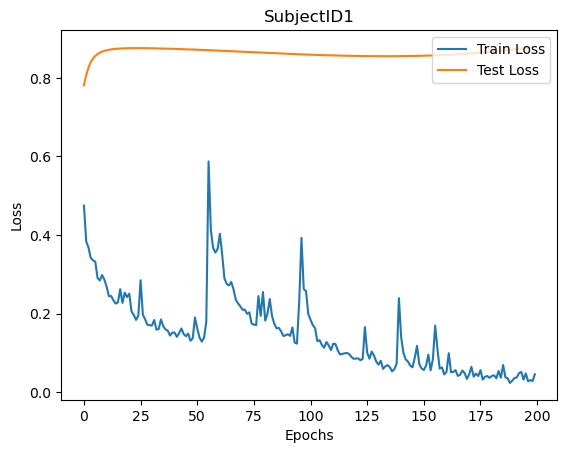

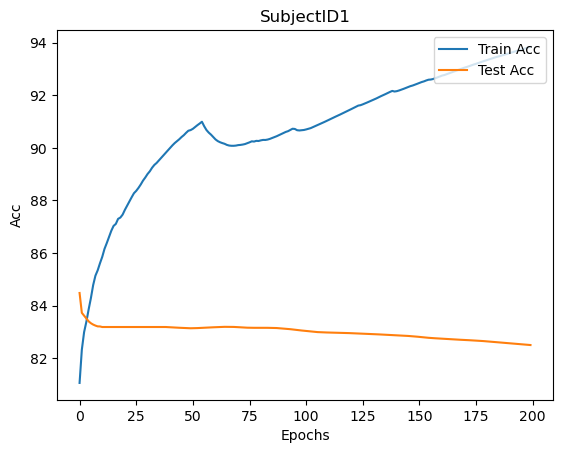

| epoch   0 | 0.0418 s/epoch | train loss 0.4570
| epoch   1 | 0.0410 s/epoch | train loss 0.3849
| epoch   2 | 0.0416 s/epoch | train loss 0.3635
| epoch   3 | 0.0420 s/epoch | train loss 0.3686
| epoch   4 | 0.0410 s/epoch | train loss 0.3582
| epoch   5 | 0.0415 s/epoch | train loss 0.3435
| epoch   6 | 0.0407 s/epoch | train loss 0.3177
| epoch   7 | 0.0400 s/epoch | train loss 0.3127
| epoch   8 | 0.0411 s/epoch | train loss 0.3199
| epoch   9 | 0.0411 s/epoch | train loss 0.3401
| epoch  10 | 0.0412 s/epoch | train loss 0.3211
| epoch  11 | 0.0412 s/epoch | train loss 0.3042
| epoch  12 | 0.0407 s/epoch | train loss 0.2890
| epoch  13 | 0.0415 s/epoch | train loss 0.2875
| epoch  14 | 0.0430 s/epoch | train loss 0.2896
| epoch  15 | 0.0412 s/epoch | train loss 0.2744
| epoch  16 | 0.0415 s/epoch | train loss 0.2835
| epoch  17 | 0.0406 s/epoch | train loss 0.2733
| epoch  18 | 0.0401 s/epoch | train loss 0.2637
| epoch  19 | 0.0421 s/epoch | train loss 0.2952
| epoch  20 | 0.0418

| epoch 168 | 0.0410 s/epoch | train loss 0.0679
| epoch 169 | 0.0419 s/epoch | train loss 0.0714
| epoch 170 | 0.0423 s/epoch | train loss 0.0899
| epoch 171 | 0.0422 s/epoch | train loss 0.0746
| epoch 172 | 0.0419 s/epoch | train loss 0.0708
| epoch 173 | 0.0419 s/epoch | train loss 0.0802
| epoch 174 | 0.0421 s/epoch | train loss 0.0805
| epoch 175 | 0.0415 s/epoch | train loss 0.0867
| epoch 176 | 0.0426 s/epoch | train loss 0.0960
| epoch 177 | 0.0414 s/epoch | train loss 0.0790
| epoch 178 | 0.0413 s/epoch | train loss 0.0740
| epoch 179 | 0.0412 s/epoch | train loss 0.0842
| epoch 180 | 0.0413 s/epoch | train loss 0.0797
| epoch 181 | 0.0416 s/epoch | train loss 0.1747
| epoch 182 | 0.0413 s/epoch | train loss 0.3335
| epoch 183 | 0.0409 s/epoch | train loss 0.2982
| epoch 184 | 0.0419 s/epoch | train loss 0.2515
| epoch 185 | 0.0417 s/epoch | train loss 0.2363
| epoch 186 | 0.0418 s/epoch | train loss 0.2051
| epoch 187 | 0.0415 s/epoch | train loss 0.1818
| epoch 188 | 0.0407

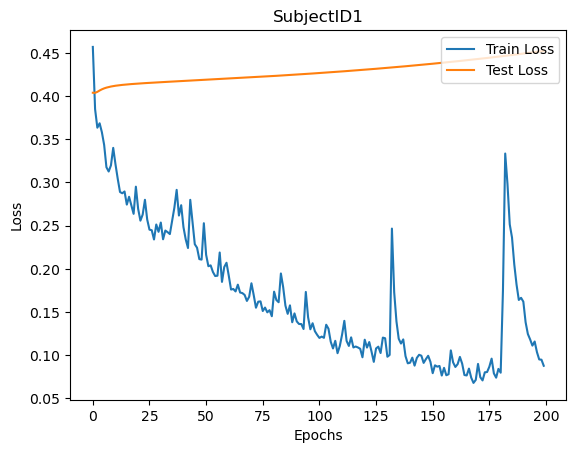

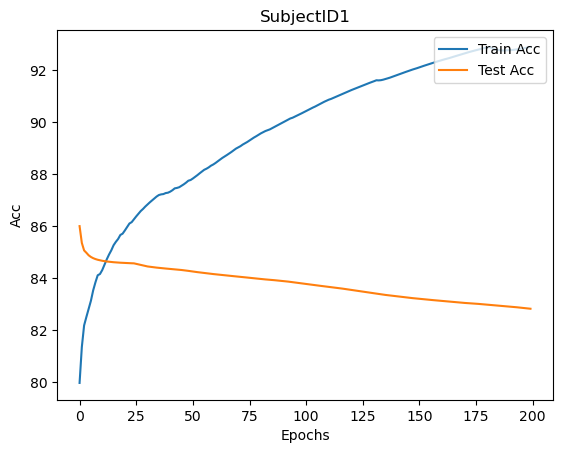


Subject 2
| epoch   0 | 0.1275 s/epoch | train loss 0.4693
| epoch   1 | 0.1274 s/epoch | train loss 0.4165
| epoch   2 | 0.1225 s/epoch | train loss 0.3430
| epoch   3 | 0.1302 s/epoch | train loss 0.3228
| epoch   4 | 0.1324 s/epoch | train loss 0.3525
| epoch   5 | 0.1325 s/epoch | train loss 0.3919
| epoch   6 | 0.1327 s/epoch | train loss 0.3502
| epoch   7 | 0.1334 s/epoch | train loss 0.3529
| epoch   8 | 0.1301 s/epoch | train loss 0.3108
| epoch   9 | 0.1326 s/epoch | train loss 0.3404
| epoch  10 | 0.1298 s/epoch | train loss 0.4976
| epoch  11 | 0.1284 s/epoch | train loss 0.3697
| epoch  12 | 0.1304 s/epoch | train loss 0.3451
| epoch  13 | 0.1308 s/epoch | train loss 0.3477
| epoch  14 | 0.1352 s/epoch | train loss 0.3259
| epoch  15 | 0.1368 s/epoch | train loss 0.3022
| epoch  16 | 0.1459 s/epoch | train loss 0.3194
| epoch  17 | 0.1212 s/epoch | train loss 0.3473
| epoch  18 | 0.1310 s/epoch | train loss 0.3017
| epoch  19 | 0.1291 s/epoch | train loss 0.3072
| epoch  

| epoch 167 | 0.1383 s/epoch | train loss 0.1111
| epoch 168 | 0.1414 s/epoch | train loss 0.1860
| epoch 169 | 0.1397 s/epoch | train loss 0.3320
| epoch 170 | 0.1442 s/epoch | train loss 0.3066
| epoch 171 | 0.1405 s/epoch | train loss 0.2617
| epoch 172 | 0.1331 s/epoch | train loss 0.2118
| epoch 173 | 0.1359 s/epoch | train loss 0.1808
| epoch 174 | 0.1352 s/epoch | train loss 0.1472
| epoch 175 | 0.1345 s/epoch | train loss 0.1299
| epoch 176 | 0.1329 s/epoch | train loss 0.1170
| epoch 177 | 0.1340 s/epoch | train loss 0.1274
| epoch 178 | 0.1344 s/epoch | train loss 0.2350
| epoch 179 | 0.1319 s/epoch | train loss 0.2007
| epoch 180 | 0.1311 s/epoch | train loss 0.1627
| epoch 181 | 0.1302 s/epoch | train loss 0.1296
| epoch 182 | 0.1302 s/epoch | train loss 0.1152
| epoch 183 | 0.1322 s/epoch | train loss 0.1586
| epoch 184 | 0.1334 s/epoch | train loss 0.3234
| epoch 185 | 0.1331 s/epoch | train loss 0.2997
| epoch 186 | 0.1240 s/epoch | train loss 0.2560
| epoch 187 | 0.1314

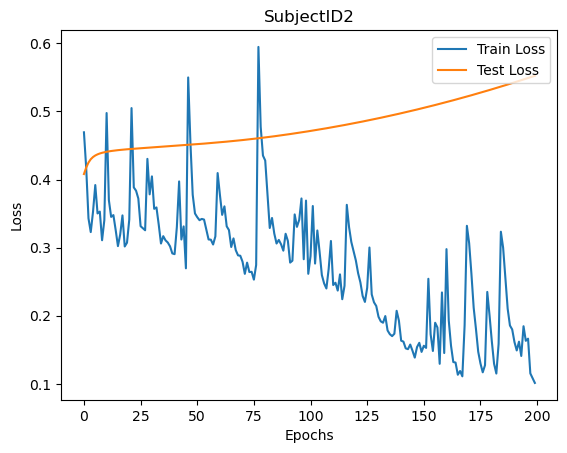

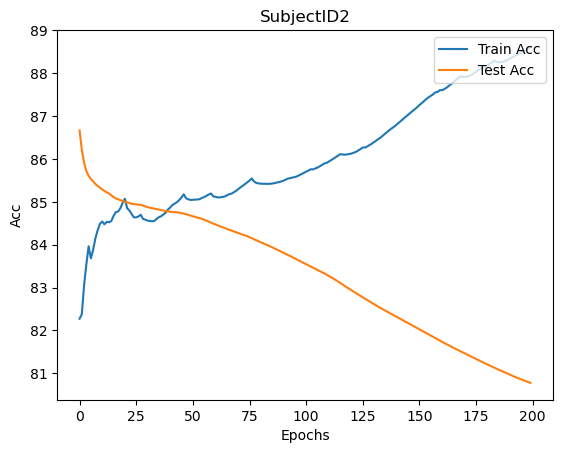

| epoch   0 | 0.0426 s/epoch | train loss 0.4584
| epoch   1 | 0.0432 s/epoch | train loss 0.4233
| epoch   2 | 0.0427 s/epoch | train loss 0.4089
| epoch   3 | 0.0426 s/epoch | train loss 0.3903
| epoch   4 | 0.0423 s/epoch | train loss 0.4054
| epoch   5 | 0.0430 s/epoch | train loss 0.3970
| epoch   6 | 0.0443 s/epoch | train loss 0.3843
| epoch   7 | 0.0421 s/epoch | train loss 0.3632
| epoch   8 | 0.0426 s/epoch | train loss 0.3536
| epoch   9 | 0.0428 s/epoch | train loss 0.3438
| epoch  10 | 0.0433 s/epoch | train loss 0.3557
| epoch  11 | 0.0434 s/epoch | train loss 0.3709
| epoch  12 | 0.0441 s/epoch | train loss 0.3589
| epoch  13 | 0.0434 s/epoch | train loss 0.3593
| epoch  14 | 0.0428 s/epoch | train loss 0.3485
| epoch  15 | 0.0424 s/epoch | train loss 0.3328
| epoch  16 | 0.0420 s/epoch | train loss 0.3289
| epoch  17 | 0.0421 s/epoch | train loss 0.3195
| epoch  18 | 0.0419 s/epoch | train loss 0.3154
| epoch  19 | 0.0401 s/epoch | train loss 0.3085
| epoch  20 | 0.0405

| epoch 168 | 0.0352 s/epoch | train loss 0.1924
| epoch 169 | 0.0353 s/epoch | train loss 0.2043
| epoch 170 | 0.0355 s/epoch | train loss 0.2661
| epoch 171 | 0.0351 s/epoch | train loss 0.2306
| epoch 172 | 0.0348 s/epoch | train loss 0.2131
| epoch 173 | 0.0342 s/epoch | train loss 0.1984
| epoch 174 | 0.0351 s/epoch | train loss 0.2049
| epoch 175 | 0.0350 s/epoch | train loss 0.2063
| epoch 176 | 0.0358 s/epoch | train loss 0.2086
| epoch 177 | 0.0351 s/epoch | train loss 0.2021
| epoch 178 | 0.0351 s/epoch | train loss 0.1908
| epoch 179 | 0.0350 s/epoch | train loss 0.1885
| epoch 180 | 0.0355 s/epoch | train loss 0.1922
| epoch 181 | 0.0354 s/epoch | train loss 0.1895
| epoch 182 | 0.0356 s/epoch | train loss 0.1834
| epoch 183 | 0.0365 s/epoch | train loss 0.1840
| epoch 184 | 0.0363 s/epoch | train loss 0.1806
| epoch 185 | 0.0362 s/epoch | train loss 0.1832
| epoch 186 | 0.0362 s/epoch | train loss 0.1736
| epoch 187 | 0.0366 s/epoch | train loss 0.1802
| epoch 188 | 0.0358

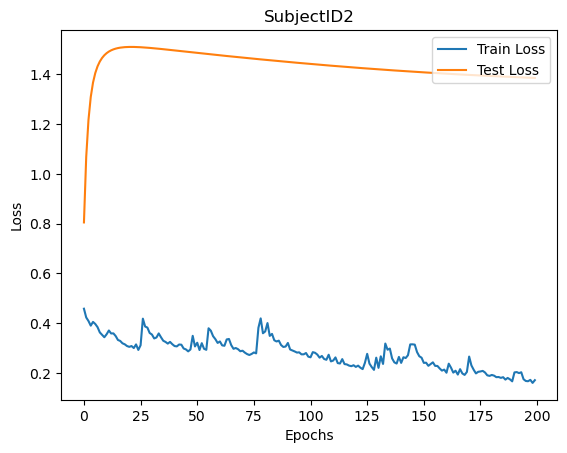

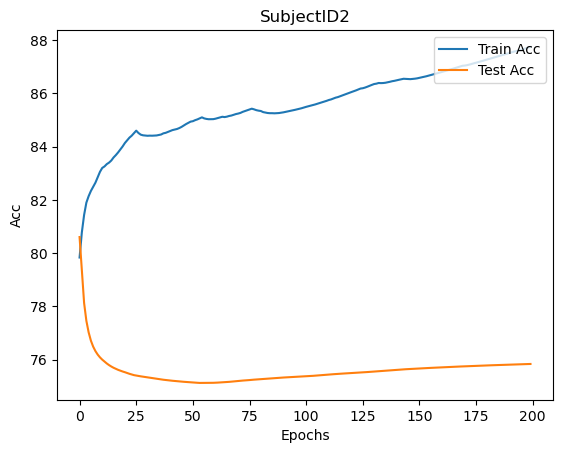


Subject 3
| epoch   0 | 0.1155 s/epoch | train loss 0.4131
| epoch   1 | 0.1155 s/epoch | train loss 0.3388
| epoch   2 | 0.1153 s/epoch | train loss 0.3120
| epoch   3 | 0.1147 s/epoch | train loss 0.3013
| epoch   4 | 0.1148 s/epoch | train loss 0.2714
| epoch   5 | 0.1148 s/epoch | train loss 0.2775
| epoch   6 | 0.1149 s/epoch | train loss 0.2644
| epoch   7 | 0.1143 s/epoch | train loss 0.5656
| epoch   8 | 0.1142 s/epoch | train loss 0.4181
| epoch   9 | 0.1144 s/epoch | train loss 0.3928
| epoch  10 | 0.1146 s/epoch | train loss 0.3451
| epoch  11 | 0.1140 s/epoch | train loss 0.4048
| epoch  12 | 0.1154 s/epoch | train loss 0.3476
| epoch  13 | 0.1152 s/epoch | train loss 0.3448
| epoch  14 | 0.1155 s/epoch | train loss 0.3473
| epoch  15 | 0.1161 s/epoch | train loss 0.3662
| epoch  16 | 0.1155 s/epoch | train loss 0.3454
| epoch  17 | 0.1160 s/epoch | train loss 0.3507
| epoch  18 | 0.1162 s/epoch | train loss 0.3237
| epoch  19 | 0.1167 s/epoch | train loss 0.3163
| epoch  

| epoch 167 | 0.1159 s/epoch | train loss 0.0575
| epoch 168 | 0.1162 s/epoch | train loss 0.0661
| epoch 169 | 0.1163 s/epoch | train loss 0.0855
| epoch 170 | 0.1296 s/epoch | train loss 0.0651
| epoch 171 | 0.1294 s/epoch | train loss 0.0644
| epoch 172 | 0.1315 s/epoch | train loss 0.0591
| epoch 173 | 0.1357 s/epoch | train loss 0.0671
| epoch 174 | 0.1325 s/epoch | train loss 0.0522
| epoch 175 | 0.1353 s/epoch | train loss 0.0564
| epoch 176 | 0.1374 s/epoch | train loss 0.0594
| epoch 177 | 0.1363 s/epoch | train loss 0.0684
| epoch 178 | 0.1374 s/epoch | train loss 0.0548
| epoch 179 | 0.1369 s/epoch | train loss 0.0492
| epoch 180 | 0.1356 s/epoch | train loss 0.0677
| epoch 181 | 0.1344 s/epoch | train loss 0.0667
| epoch 182 | 0.1349 s/epoch | train loss 0.0547
| epoch 183 | 0.1351 s/epoch | train loss 0.0495
| epoch 184 | 0.1361 s/epoch | train loss 0.0572
| epoch 185 | 0.1346 s/epoch | train loss 0.0553
| epoch 186 | 0.1343 s/epoch | train loss 0.0617
| epoch 187 | 0.1337

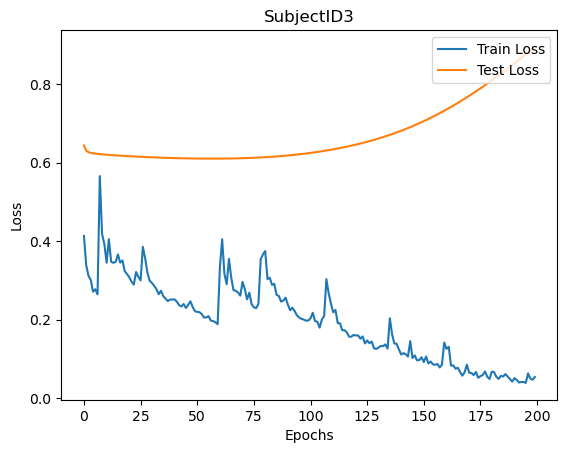

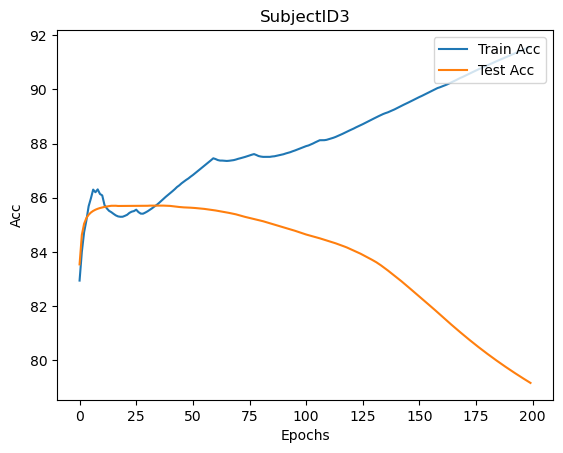

| epoch   0 | 0.0394 s/epoch | train loss 0.4647
| epoch   1 | 0.0395 s/epoch | train loss 0.3821
| epoch   2 | 0.0390 s/epoch | train loss 0.3596
| epoch   3 | 0.0400 s/epoch | train loss 0.3413
| epoch   4 | 0.0394 s/epoch | train loss 0.3303
| epoch   5 | 0.0404 s/epoch | train loss 0.3285
| epoch   6 | 0.0401 s/epoch | train loss 0.3050
| epoch   7 | 0.0400 s/epoch | train loss 0.3066
| epoch   8 | 0.0393 s/epoch | train loss 0.2997
| epoch   9 | 0.0399 s/epoch | train loss 0.2874
| epoch  10 | 0.0401 s/epoch | train loss 0.2817
| epoch  11 | 0.0395 s/epoch | train loss 0.2719
| epoch  12 | 0.0399 s/epoch | train loss 0.2781
| epoch  13 | 0.0393 s/epoch | train loss 0.2770
| epoch  14 | 0.0371 s/epoch | train loss 0.2619
| epoch  15 | 0.0372 s/epoch | train loss 0.2718
| epoch  16 | 0.0386 s/epoch | train loss 0.2705
| epoch  17 | 0.0392 s/epoch | train loss 0.2872
| epoch  18 | 0.0390 s/epoch | train loss 0.2773
| epoch  19 | 0.0398 s/epoch | train loss 0.2586
| epoch  20 | 0.0387

| epoch 168 | 0.0387 s/epoch | train loss 0.0788
| epoch 169 | 0.0396 s/epoch | train loss 0.0788
| epoch 170 | 0.0398 s/epoch | train loss 0.0766
| epoch 171 | 0.0388 s/epoch | train loss 0.0802
| epoch 172 | 0.0393 s/epoch | train loss 0.0681
| epoch 173 | 0.0396 s/epoch | train loss 0.0716
| epoch 174 | 0.0403 s/epoch | train loss 0.0710
| epoch 175 | 0.0393 s/epoch | train loss 0.0786
| epoch 176 | 0.0399 s/epoch | train loss 0.0770
| epoch 177 | 0.0408 s/epoch | train loss 0.0809
| epoch 178 | 0.0399 s/epoch | train loss 0.0743
| epoch 179 | 0.0403 s/epoch | train loss 0.0705
| epoch 180 | 0.0404 s/epoch | train loss 0.0834
| epoch 181 | 0.0387 s/epoch | train loss 0.0756
| epoch 182 | 0.0396 s/epoch | train loss 0.0790
| epoch 183 | 0.0396 s/epoch | train loss 0.0766
| epoch 184 | 0.0392 s/epoch | train loss 0.0739
| epoch 185 | 0.0411 s/epoch | train loss 0.0773
| epoch 186 | 0.0406 s/epoch | train loss 0.0787
| epoch 187 | 0.0403 s/epoch | train loss 0.0705
| epoch 188 | 0.0452

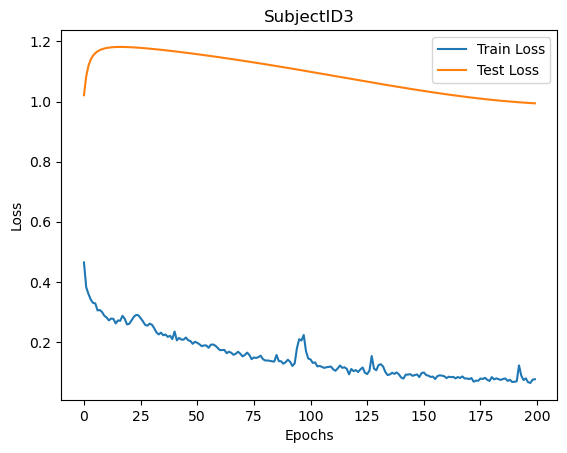

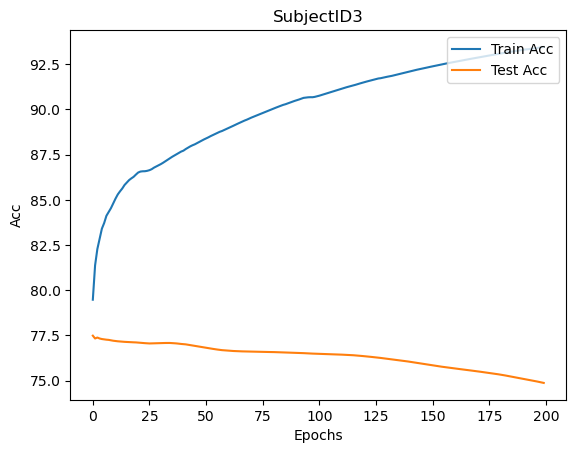


Subject 4
| epoch   0 | 0.1310 s/epoch | train loss 0.4535
| epoch   1 | 0.1294 s/epoch | train loss 0.3510
| epoch   2 | 0.1292 s/epoch | train loss 0.3566
| epoch   3 | 0.1288 s/epoch | train loss 0.3448
| epoch   4 | 0.1295 s/epoch | train loss 0.3227
| epoch   5 | 0.1277 s/epoch | train loss 0.2948
| epoch   6 | 0.1290 s/epoch | train loss 0.2826
| epoch   7 | 0.1299 s/epoch | train loss 0.3486
| epoch   8 | 0.1298 s/epoch | train loss 0.5259
| epoch   9 | 0.1296 s/epoch | train loss 0.4009
| epoch  10 | 0.1303 s/epoch | train loss 0.4742
| epoch  11 | 0.1313 s/epoch | train loss 0.4952
| epoch  12 | 0.1285 s/epoch | train loss 0.4802
| epoch  13 | 0.1291 s/epoch | train loss 0.3987
| epoch  14 | 0.1285 s/epoch | train loss 0.4381
| epoch  15 | 0.1296 s/epoch | train loss 0.4071
| epoch  16 | 0.1301 s/epoch | train loss 0.3704
| epoch  17 | 0.1308 s/epoch | train loss 0.3649
| epoch  18 | 0.1297 s/epoch | train loss 0.3879
| epoch  19 | 0.1293 s/epoch | train loss 0.3901
| epoch  

| epoch 167 | 0.1252 s/epoch | train loss 0.0902
| epoch 168 | 0.1254 s/epoch | train loss 0.0776
| epoch 169 | 0.1249 s/epoch | train loss 0.1010
| epoch 170 | 0.1250 s/epoch | train loss 0.0759
| epoch 171 | 0.1254 s/epoch | train loss 0.0774
| epoch 172 | 0.1251 s/epoch | train loss 0.0773
| epoch 173 | 0.1240 s/epoch | train loss 0.0842
| epoch 174 | 0.1291 s/epoch | train loss 0.0860
| epoch 175 | 0.1279 s/epoch | train loss 0.0807
| epoch 176 | 0.1293 s/epoch | train loss 0.0744
| epoch 177 | 0.1310 s/epoch | train loss 0.0771
| epoch 178 | 0.1279 s/epoch | train loss 0.0880
| epoch 179 | 0.1277 s/epoch | train loss 0.0729
| epoch 180 | 0.1272 s/epoch | train loss 0.0828
| epoch 181 | 0.1284 s/epoch | train loss 0.0641
| epoch 182 | 0.1279 s/epoch | train loss 0.0781
| epoch 183 | 0.1312 s/epoch | train loss 0.0847
| epoch 184 | 0.1315 s/epoch | train loss 0.0695
| epoch 185 | 0.1311 s/epoch | train loss 0.0594
| epoch 186 | 0.1270 s/epoch | train loss 0.0631
| epoch 187 | 0.1284

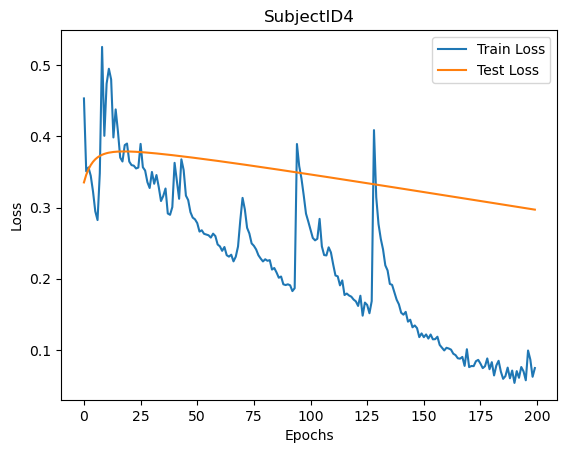

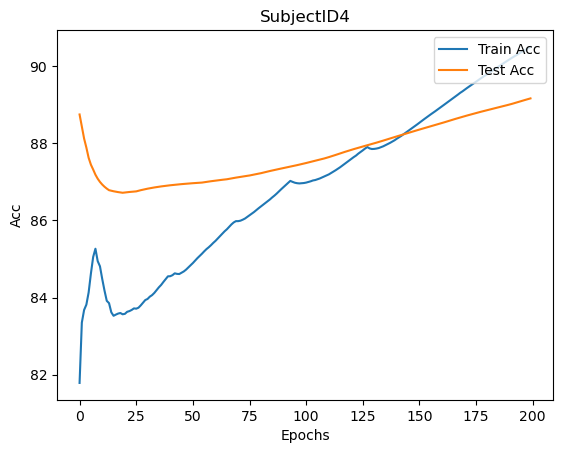

| epoch   0 | 0.0379 s/epoch | train loss 0.4727
| epoch   1 | 0.0381 s/epoch | train loss 0.3970
| epoch   2 | 0.0392 s/epoch | train loss 0.3666
| epoch   3 | 0.0390 s/epoch | train loss 0.3567
| epoch   4 | 0.0384 s/epoch | train loss 0.3381
| epoch   5 | 0.0392 s/epoch | train loss 0.3390
| epoch   6 | 0.0387 s/epoch | train loss 0.3243
| epoch   7 | 0.0388 s/epoch | train loss 0.3196
| epoch   8 | 0.0385 s/epoch | train loss 0.3108
| epoch   9 | 0.0385 s/epoch | train loss 0.3005
| epoch  10 | 0.0391 s/epoch | train loss 0.2981
| epoch  11 | 0.0382 s/epoch | train loss 0.3386
| epoch  12 | 0.0391 s/epoch | train loss 0.3533
| epoch  13 | 0.0390 s/epoch | train loss 0.3687
| epoch  14 | 0.0385 s/epoch | train loss 0.3413
| epoch  15 | 0.0382 s/epoch | train loss 0.3255
| epoch  16 | 0.0394 s/epoch | train loss 0.3209
| epoch  17 | 0.0386 s/epoch | train loss 0.2995
| epoch  18 | 0.0407 s/epoch | train loss 0.2939
| epoch  19 | 0.0390 s/epoch | train loss 0.2864
| epoch  20 | 0.0394

| epoch 168 | 0.0422 s/epoch | train loss 0.0754
| epoch 169 | 0.0435 s/epoch | train loss 0.0833
| epoch 170 | 0.0427 s/epoch | train loss 0.0833
| epoch 171 | 0.0422 s/epoch | train loss 0.0819
| epoch 172 | 0.0428 s/epoch | train loss 0.0850
| epoch 173 | 0.0438 s/epoch | train loss 0.0757
| epoch 174 | 0.0432 s/epoch | train loss 0.0842
| epoch 175 | 0.0435 s/epoch | train loss 0.0813
| epoch 176 | 0.0432 s/epoch | train loss 0.0767
| epoch 177 | 0.0437 s/epoch | train loss 0.0799
| epoch 178 | 0.0435 s/epoch | train loss 0.0778
| epoch 179 | 0.0430 s/epoch | train loss 0.0730
| epoch 180 | 0.0430 s/epoch | train loss 0.0784
| epoch 181 | 0.0410 s/epoch | train loss 0.0784
| epoch 182 | 0.0421 s/epoch | train loss 0.0814
| epoch 183 | 0.0428 s/epoch | train loss 0.0664
| epoch 184 | 0.0425 s/epoch | train loss 0.0747
| epoch 185 | 0.0423 s/epoch | train loss 0.0696
| epoch 186 | 0.0418 s/epoch | train loss 0.0693
| epoch 187 | 0.0417 s/epoch | train loss 0.0856
| epoch 188 | 0.0421

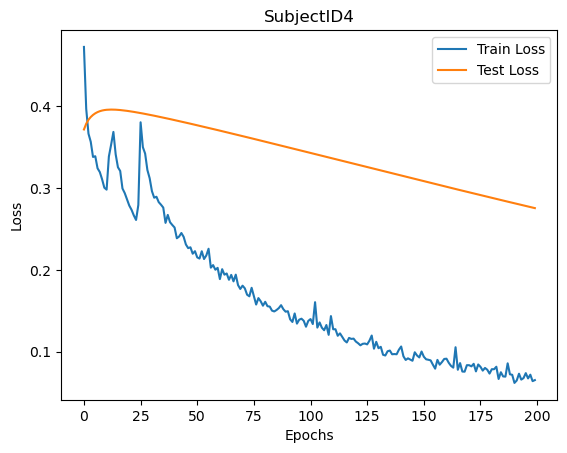

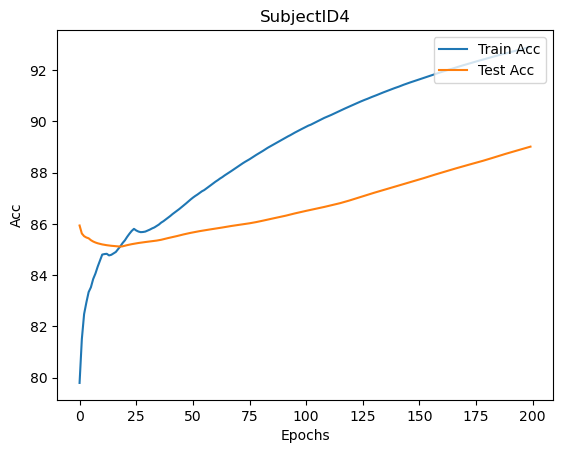


Subject 5
| epoch   0 | 0.1447 s/epoch | train loss 0.4638
| epoch   1 | 0.1429 s/epoch | train loss 0.3381
| epoch   2 | 0.1445 s/epoch | train loss 0.3158
| epoch   3 | 0.1444 s/epoch | train loss 0.2986
| epoch   4 | 0.1424 s/epoch | train loss 0.2830
| epoch   5 | 0.1418 s/epoch | train loss 0.2722
| epoch   6 | 0.1424 s/epoch | train loss 0.2616
| epoch   7 | 0.1418 s/epoch | train loss 0.3119
| epoch   8 | 0.1431 s/epoch | train loss 0.3357
| epoch   9 | 0.1436 s/epoch | train loss 0.3088
| epoch  10 | 0.1437 s/epoch | train loss 0.2760
| epoch  11 | 0.1373 s/epoch | train loss 0.2705
| epoch  12 | 0.1430 s/epoch | train loss 0.2622
| epoch  13 | 0.1414 s/epoch | train loss 0.2452
| epoch  14 | 0.1434 s/epoch | train loss 0.2446
| epoch  15 | 0.1358 s/epoch | train loss 0.2373
| epoch  16 | 0.1381 s/epoch | train loss 0.2274
| epoch  17 | 0.1339 s/epoch | train loss 0.4890
| epoch  18 | 0.1382 s/epoch | train loss 0.3698
| epoch  19 | 0.1384 s/epoch | train loss 0.3470
| epoch  

| epoch 167 | 0.1281 s/epoch | train loss 0.0429
| epoch 168 | 0.1285 s/epoch | train loss 0.0291
| epoch 169 | 0.1288 s/epoch | train loss 0.0360
| epoch 170 | 0.1284 s/epoch | train loss 0.0285
| epoch 171 | 0.1310 s/epoch | train loss 0.0461
| epoch 172 | 0.1350 s/epoch | train loss 0.0352
| epoch 173 | 0.1370 s/epoch | train loss 0.0303
| epoch 174 | 0.1349 s/epoch | train loss 0.0323
| epoch 175 | 0.1327 s/epoch | train loss 0.0296
| epoch 176 | 0.1274 s/epoch | train loss 0.0280
| epoch 177 | 0.1294 s/epoch | train loss 0.1198
| epoch 178 | 0.1292 s/epoch | train loss 0.0735
| epoch 179 | 0.1284 s/epoch | train loss 0.0424
| epoch 180 | 0.1274 s/epoch | train loss 0.0391
| epoch 181 | 0.1299 s/epoch | train loss 0.0359
| epoch 182 | 0.1289 s/epoch | train loss 0.0329
| epoch 183 | 0.1284 s/epoch | train loss 0.0395
| epoch 184 | 0.1273 s/epoch | train loss 0.0196
| epoch 185 | 0.1288 s/epoch | train loss 0.0330
| epoch 186 | 0.1294 s/epoch | train loss 0.0314
| epoch 187 | 0.1289

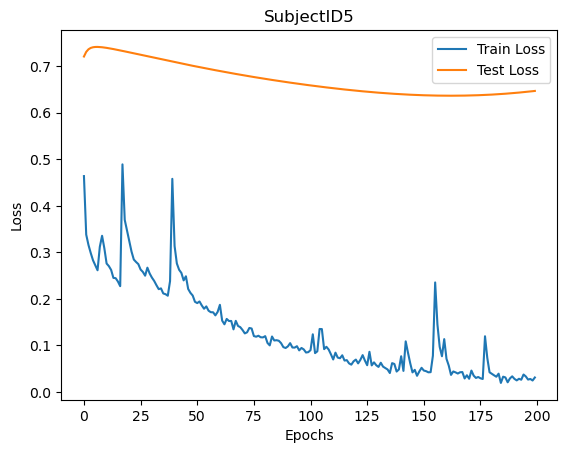

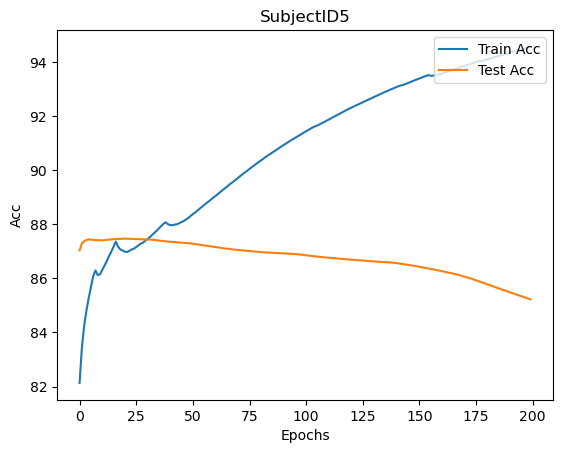

| epoch   0 | 0.0381 s/epoch | train loss 0.4613
| epoch   1 | 0.0378 s/epoch | train loss 0.3989
| epoch   2 | 0.0381 s/epoch | train loss 0.3732
| epoch   3 | 0.0383 s/epoch | train loss 0.3571
| epoch   4 | 0.0385 s/epoch | train loss 0.3383
| epoch   5 | 0.0378 s/epoch | train loss 0.3313
| epoch   6 | 0.0384 s/epoch | train loss 0.3317
| epoch   7 | 0.0383 s/epoch | train loss 0.3206
| epoch   8 | 0.0382 s/epoch | train loss 0.3132
| epoch   9 | 0.0380 s/epoch | train loss 0.3068
| epoch  10 | 0.0379 s/epoch | train loss 0.2987
| epoch  11 | 0.0389 s/epoch | train loss 0.2962
| epoch  12 | 0.0392 s/epoch | train loss 0.3050
| epoch  13 | 0.0380 s/epoch | train loss 0.2948
| epoch  14 | 0.0389 s/epoch | train loss 0.2850
| epoch  15 | 0.0388 s/epoch | train loss 0.2788
| epoch  16 | 0.0388 s/epoch | train loss 0.2704
| epoch  17 | 0.0383 s/epoch | train loss 0.2662
| epoch  18 | 0.0389 s/epoch | train loss 0.2658
| epoch  19 | 0.0396 s/epoch | train loss 0.2583
| epoch  20 | 0.0392

| epoch 168 | 0.0388 s/epoch | train loss 0.0693
| epoch 169 | 0.0388 s/epoch | train loss 0.0728
| epoch 170 | 0.0384 s/epoch | train loss 0.0690
| epoch 171 | 0.0381 s/epoch | train loss 0.0762
| epoch 172 | 0.0383 s/epoch | train loss 0.0776
| epoch 173 | 0.0383 s/epoch | train loss 0.0652
| epoch 174 | 0.0374 s/epoch | train loss 0.0697
| epoch 175 | 0.0385 s/epoch | train loss 0.0629
| epoch 176 | 0.0389 s/epoch | train loss 0.0627
| epoch 177 | 0.0383 s/epoch | train loss 0.0711
| epoch 178 | 0.0379 s/epoch | train loss 0.0625
| epoch 179 | 0.0380 s/epoch | train loss 0.0609
| epoch 180 | 0.0383 s/epoch | train loss 0.0652
| epoch 181 | 0.0387 s/epoch | train loss 0.0644
| epoch 182 | 0.0395 s/epoch | train loss 0.0677
| epoch 183 | 0.0388 s/epoch | train loss 0.0639
| epoch 184 | 0.0386 s/epoch | train loss 0.0596
| epoch 185 | 0.0388 s/epoch | train loss 0.0720
| epoch 186 | 0.0385 s/epoch | train loss 0.0595
| epoch 187 | 0.0384 s/epoch | train loss 0.0615
| epoch 188 | 0.0401

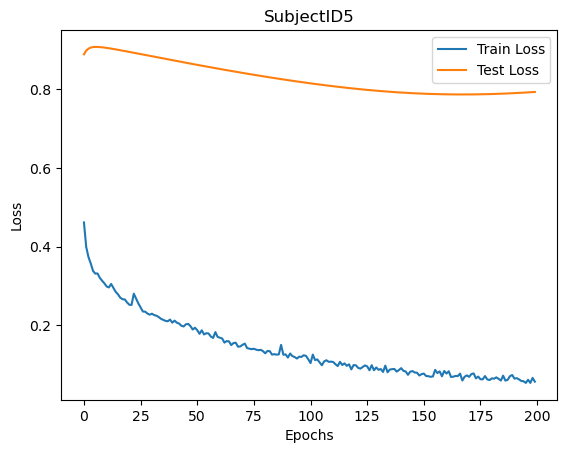

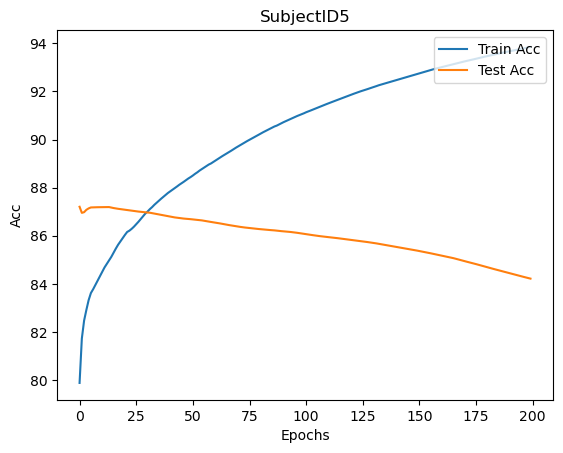


Subject 7
| epoch   0 | 0.1344 s/epoch | train loss 0.4810
| epoch   1 | 0.1312 s/epoch | train loss 0.3683
| epoch   2 | 0.1277 s/epoch | train loss 0.3270
| epoch   3 | 0.1242 s/epoch | train loss 0.2895
| epoch   4 | 0.1245 s/epoch | train loss 0.2739
| epoch   5 | 0.1230 s/epoch | train loss 0.2560
| epoch   6 | 0.1253 s/epoch | train loss 0.2617
| epoch   7 | 0.1240 s/epoch | train loss 0.2436
| epoch   8 | 0.1248 s/epoch | train loss 0.2364
| epoch   9 | 0.1247 s/epoch | train loss 0.2332
| epoch  10 | 0.1264 s/epoch | train loss 0.2361
| epoch  11 | 0.1309 s/epoch | train loss 0.2133
| epoch  12 | 0.1280 s/epoch | train loss 0.2266
| epoch  13 | 0.1240 s/epoch | train loss 0.2124
| epoch  14 | 0.1225 s/epoch | train loss 0.2128
| epoch  15 | 0.1110 s/epoch | train loss 0.2255
| epoch  16 | 0.1097 s/epoch | train loss 0.2755
| epoch  17 | 0.1102 s/epoch | train loss 0.2271
| epoch  18 | 0.1131 s/epoch | train loss 0.2104
| epoch  19 | 0.1121 s/epoch | train loss 0.3297
| epoch  

| epoch 167 | 0.1248 s/epoch | train loss 0.0346
| epoch 168 | 0.1230 s/epoch | train loss 0.0369
| epoch 169 | 0.1243 s/epoch | train loss 0.0415
| epoch 170 | 0.1232 s/epoch | train loss 0.0404
| epoch 171 | 0.1222 s/epoch | train loss 0.0371
| epoch 172 | 0.1219 s/epoch | train loss 0.0413
| epoch 173 | 0.1229 s/epoch | train loss 0.0260
| epoch 174 | 0.1218 s/epoch | train loss 0.0268
| epoch 175 | 0.1229 s/epoch | train loss 0.0336
| epoch 176 | 0.1240 s/epoch | train loss 0.0340
| epoch 177 | 0.1241 s/epoch | train loss 0.0426
| epoch 178 | 0.1238 s/epoch | train loss 0.0274
| epoch 179 | 0.1237 s/epoch | train loss 0.0408
| epoch 180 | 0.1235 s/epoch | train loss 0.0437
| epoch 181 | 0.1246 s/epoch | train loss 0.0346
| epoch 182 | 0.1234 s/epoch | train loss 0.0382
| epoch 183 | 0.1235 s/epoch | train loss 0.0311
| epoch 184 | 0.1251 s/epoch | train loss 0.0268
| epoch 185 | 0.1293 s/epoch | train loss 0.0280
| epoch 186 | 0.1296 s/epoch | train loss 0.0342
| epoch 187 | 0.1304

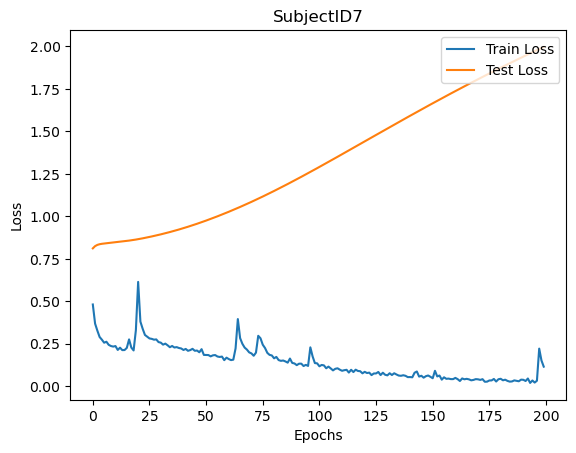

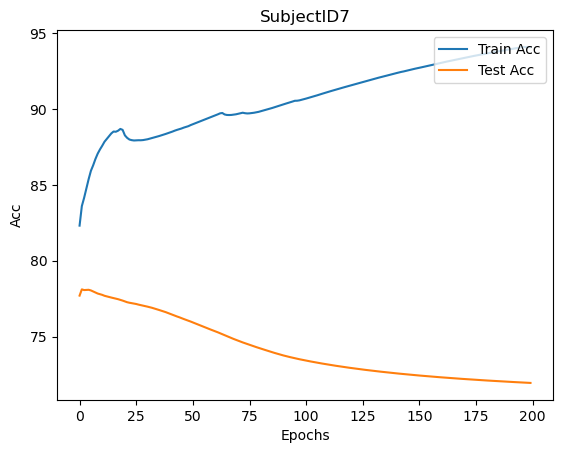

| epoch   0 | 0.0386 s/epoch | train loss 0.4360
| epoch   1 | 0.0387 s/epoch | train loss 0.3755
| epoch   2 | 0.0390 s/epoch | train loss 0.3551
| epoch   3 | 0.0386 s/epoch | train loss 0.3407
| epoch   4 | 0.0391 s/epoch | train loss 0.3257
| epoch   5 | 0.0396 s/epoch | train loss 0.3289
| epoch   6 | 0.0385 s/epoch | train loss 0.3128
| epoch   7 | 0.0378 s/epoch | train loss 0.3089
| epoch   8 | 0.0388 s/epoch | train loss 0.2948
| epoch   9 | 0.0397 s/epoch | train loss 0.2902
| epoch  10 | 0.0382 s/epoch | train loss 0.2871
| epoch  11 | 0.0388 s/epoch | train loss 0.2797
| epoch  12 | 0.0392 s/epoch | train loss 0.3232
| epoch  13 | 0.0394 s/epoch | train loss 0.3354
| epoch  14 | 0.0384 s/epoch | train loss 0.3067
| epoch  15 | 0.0395 s/epoch | train loss 0.2965
| epoch  16 | 0.0389 s/epoch | train loss 0.2842
| epoch  17 | 0.0391 s/epoch | train loss 0.2736
| epoch  18 | 0.0383 s/epoch | train loss 0.2737
| epoch  19 | 0.0390 s/epoch | train loss 0.2679
| epoch  20 | 0.0390

| epoch 168 | 0.0383 s/epoch | train loss 0.0592
| epoch 169 | 0.0387 s/epoch | train loss 0.0608
| epoch 170 | 0.0389 s/epoch | train loss 0.0681
| epoch 171 | 0.0381 s/epoch | train loss 0.0701
| epoch 172 | 0.0380 s/epoch | train loss 0.0573
| epoch 173 | 0.0387 s/epoch | train loss 0.0576
| epoch 174 | 0.0392 s/epoch | train loss 0.0637
| epoch 175 | 0.0387 s/epoch | train loss 0.0680
| epoch 176 | 0.0389 s/epoch | train loss 0.0587
| epoch 177 | 0.0392 s/epoch | train loss 0.0593
| epoch 178 | 0.0384 s/epoch | train loss 0.0795
| epoch 179 | 0.0386 s/epoch | train loss 0.0568
| epoch 180 | 0.0388 s/epoch | train loss 0.0588
| epoch 181 | 0.0380 s/epoch | train loss 0.0560
| epoch 182 | 0.0391 s/epoch | train loss 0.0660
| epoch 183 | 0.0387 s/epoch | train loss 0.0570
| epoch 184 | 0.0385 s/epoch | train loss 0.0580
| epoch 185 | 0.0389 s/epoch | train loss 0.0672
| epoch 186 | 0.0384 s/epoch | train loss 0.0573
| epoch 187 | 0.0384 s/epoch | train loss 0.0609
| epoch 188 | 0.0387

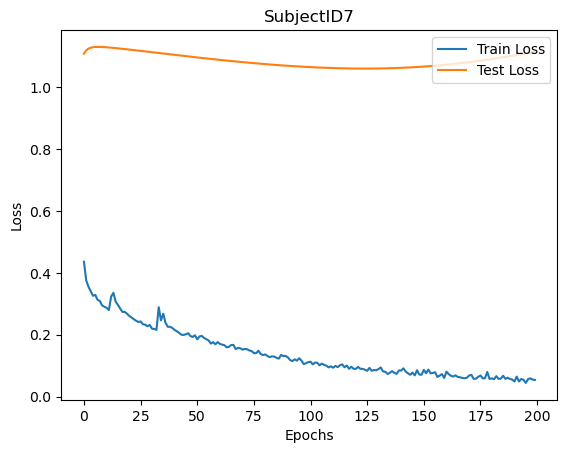

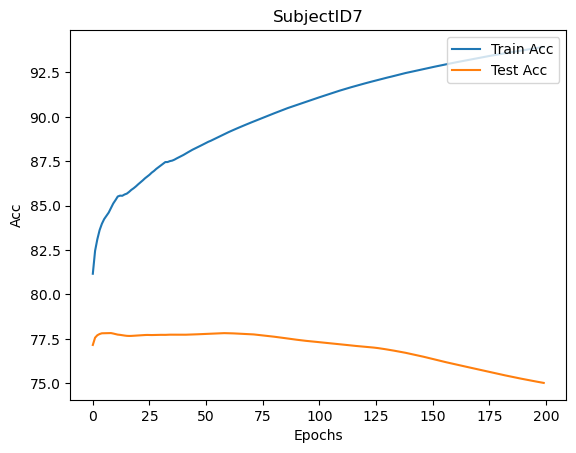


Subject 8
| epoch   0 | 0.1371 s/epoch | train loss 0.4279
| epoch   1 | 0.1369 s/epoch | train loss 0.3683
| epoch   2 | 0.1358 s/epoch | train loss 0.3447
| epoch   3 | 0.1360 s/epoch | train loss 0.3091
| epoch   4 | 0.1372 s/epoch | train loss 0.4297
| epoch   5 | 0.1375 s/epoch | train loss 0.3254
| epoch   6 | 0.1367 s/epoch | train loss 0.2994
| epoch   7 | 0.1354 s/epoch | train loss 0.2842
| epoch   8 | 0.1374 s/epoch | train loss 0.2879
| epoch   9 | 0.1366 s/epoch | train loss 0.2671
| epoch  10 | 0.1373 s/epoch | train loss 0.2613
| epoch  11 | 0.1370 s/epoch | train loss 0.2540
| epoch  12 | 0.1388 s/epoch | train loss 0.2425
| epoch  13 | 0.1394 s/epoch | train loss 0.2423
| epoch  14 | 0.1385 s/epoch | train loss 0.2399
| epoch  15 | 0.1384 s/epoch | train loss 0.2289
| epoch  16 | 0.1366 s/epoch | train loss 0.2315
| epoch  17 | 0.1363 s/epoch | train loss 0.2261
| epoch  18 | 0.1356 s/epoch | train loss 0.2231
| epoch  19 | 0.1370 s/epoch | train loss 0.2142
| epoch  

| epoch 167 | 0.1394 s/epoch | train loss 0.0456
| epoch 168 | 0.1396 s/epoch | train loss 0.0290
| epoch 169 | 0.1391 s/epoch | train loss 0.0310
| epoch 170 | 0.1408 s/epoch | train loss 0.0409
| epoch 171 | 0.1396 s/epoch | train loss 0.0377
| epoch 172 | 0.1424 s/epoch | train loss 0.0368
| epoch 173 | 0.1326 s/epoch | train loss 0.0368
| epoch 174 | 0.1461 s/epoch | train loss 0.0440
| epoch 175 | 0.1453 s/epoch | train loss 0.0644
| epoch 176 | 0.1474 s/epoch | train loss 0.0360
| epoch 177 | 0.1465 s/epoch | train loss 0.0368
| epoch 178 | 0.1452 s/epoch | train loss 0.0386
| epoch 179 | 0.1447 s/epoch | train loss 0.0425
| epoch 180 | 0.1388 s/epoch | train loss 0.0319
| epoch 181 | 0.1405 s/epoch | train loss 0.0353
| epoch 182 | 0.1447 s/epoch | train loss 0.0255
| epoch 183 | 0.1430 s/epoch | train loss 0.0317
| epoch 184 | 0.1440 s/epoch | train loss 0.0272
| epoch 185 | 0.1452 s/epoch | train loss 0.0215
| epoch 186 | 0.1404 s/epoch | train loss 0.0322
| epoch 187 | 0.1433

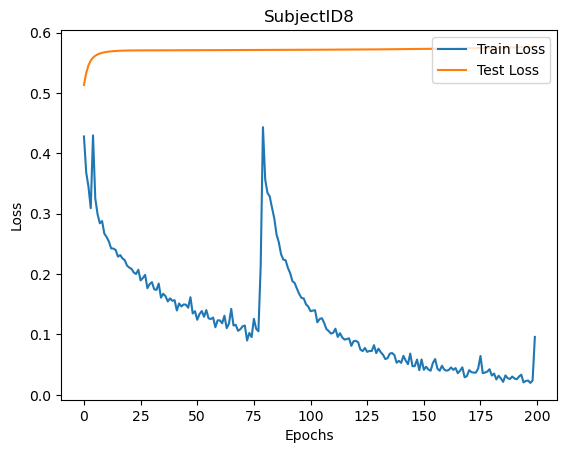

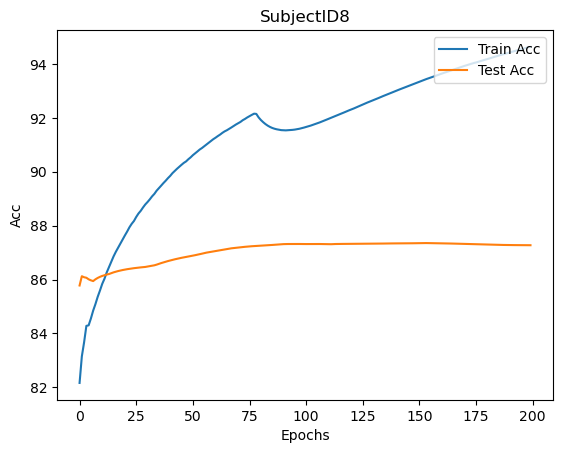

| epoch   0 | 0.0408 s/epoch | train loss 0.4491
| epoch   1 | 0.0410 s/epoch | train loss 0.4031
| epoch   2 | 0.0404 s/epoch | train loss 0.3764
| epoch   3 | 0.0408 s/epoch | train loss 0.3546
| epoch   4 | 0.0404 s/epoch | train loss 0.3385
| epoch   5 | 0.0419 s/epoch | train loss 0.3290
| epoch   6 | 0.0409 s/epoch | train loss 0.3195
| epoch   7 | 0.0408 s/epoch | train loss 0.3126
| epoch   8 | 0.0428 s/epoch | train loss 0.3039
| epoch   9 | 0.0412 s/epoch | train loss 0.2946
| epoch  10 | 0.0420 s/epoch | train loss 0.2999
| epoch  11 | 0.0417 s/epoch | train loss 0.2912
| epoch  12 | 0.0417 s/epoch | train loss 0.3130
| epoch  13 | 0.0415 s/epoch | train loss 0.2944
| epoch  14 | 0.0424 s/epoch | train loss 0.2773
| epoch  15 | 0.0417 s/epoch | train loss 0.2757
| epoch  16 | 0.0425 s/epoch | train loss 0.2568
| epoch  17 | 0.0420 s/epoch | train loss 0.2654
| epoch  18 | 0.0409 s/epoch | train loss 0.2748
| epoch  19 | 0.0418 s/epoch | train loss 0.2817
| epoch  20 | 0.0415

| epoch 168 | 0.0411 s/epoch | train loss 0.0706
| epoch 169 | 0.0412 s/epoch | train loss 0.0897
| epoch 170 | 0.0430 s/epoch | train loss 0.0752
| epoch 171 | 0.0401 s/epoch | train loss 0.0812
| epoch 172 | 0.0415 s/epoch | train loss 0.0781
| epoch 173 | 0.0421 s/epoch | train loss 0.0648
| epoch 174 | 0.0412 s/epoch | train loss 0.0879
| epoch 175 | 0.0416 s/epoch | train loss 0.0796
| epoch 176 | 0.0406 s/epoch | train loss 0.0770
| epoch 177 | 0.0413 s/epoch | train loss 0.0708
| epoch 178 | 0.0422 s/epoch | train loss 0.0710
| epoch 179 | 0.0419 s/epoch | train loss 0.0730
| epoch 180 | 0.0418 s/epoch | train loss 0.0718
| epoch 181 | 0.0415 s/epoch | train loss 0.0685
| epoch 182 | 0.0410 s/epoch | train loss 0.0736
| epoch 183 | 0.0413 s/epoch | train loss 0.0727
| epoch 184 | 0.0414 s/epoch | train loss 0.0756
| epoch 185 | 0.0416 s/epoch | train loss 0.0738
| epoch 186 | 0.0418 s/epoch | train loss 0.0722
| epoch 187 | 0.0418 s/epoch | train loss 0.0756
| epoch 188 | 0.0404

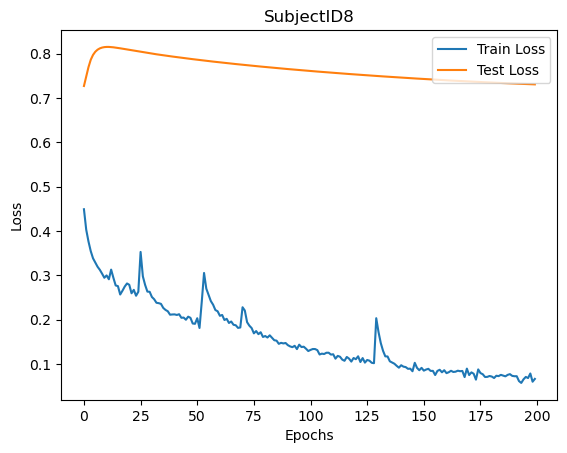

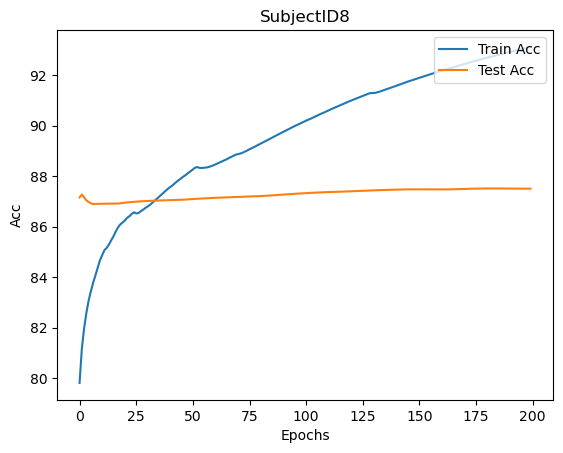


Subject 9
| epoch   0 | 0.1419 s/epoch | train loss 0.4646
| epoch   1 | 0.1443 s/epoch | train loss 0.3407
| epoch   2 | 0.1396 s/epoch | train loss 0.3085
| epoch   3 | 0.1425 s/epoch | train loss 0.2975
| epoch   4 | 0.1431 s/epoch | train loss 0.2873
| epoch   5 | 0.1413 s/epoch | train loss 0.2723
| epoch   6 | 0.1412 s/epoch | train loss 0.2966
| epoch   7 | 0.1398 s/epoch | train loss 0.3163
| epoch   8 | 0.1388 s/epoch | train loss 0.3283
| epoch   9 | 0.1407 s/epoch | train loss 0.3051
| epoch  10 | 0.1388 s/epoch | train loss 0.2823
| epoch  11 | 0.1408 s/epoch | train loss 0.3271
| epoch  12 | 0.1396 s/epoch | train loss 0.3469
| epoch  13 | 0.1391 s/epoch | train loss 0.3128
| epoch  14 | 0.1394 s/epoch | train loss 0.2793
| epoch  15 | 0.1408 s/epoch | train loss 0.2755
| epoch  16 | 0.1201 s/epoch | train loss 0.2637
| epoch  17 | 0.1152 s/epoch | train loss 0.2513
| epoch  18 | 0.1156 s/epoch | train loss 0.2692
| epoch  19 | 0.1146 s/epoch | train loss 0.2934
| epoch  

| epoch 167 | 0.1125 s/epoch | train loss 0.0460
| epoch 168 | 0.1107 s/epoch | train loss 0.0480
| epoch 169 | 0.1099 s/epoch | train loss 0.0438
| epoch 170 | 0.1097 s/epoch | train loss 0.0519
| epoch 171 | 0.1094 s/epoch | train loss 0.0477
| epoch 172 | 0.1099 s/epoch | train loss 0.0570
| epoch 173 | 0.1098 s/epoch | train loss 0.0499
| epoch 174 | 0.1099 s/epoch | train loss 0.0297
| epoch 175 | 0.1094 s/epoch | train loss 0.0341
| epoch 176 | 0.1094 s/epoch | train loss 0.0443
| epoch 177 | 0.1095 s/epoch | train loss 0.0371
| epoch 178 | 0.1096 s/epoch | train loss 0.0343
| epoch 179 | 0.1095 s/epoch | train loss 0.0321
| epoch 180 | 0.1095 s/epoch | train loss 0.0314
| epoch 181 | 0.1098 s/epoch | train loss 0.0443
| epoch 182 | 0.1099 s/epoch | train loss 0.0417
| epoch 183 | 0.1098 s/epoch | train loss 0.0439
| epoch 184 | 0.1100 s/epoch | train loss 0.0384
| epoch 185 | 0.1097 s/epoch | train loss 0.0296
| epoch 186 | 0.1097 s/epoch | train loss 0.0353
| epoch 187 | 0.1094

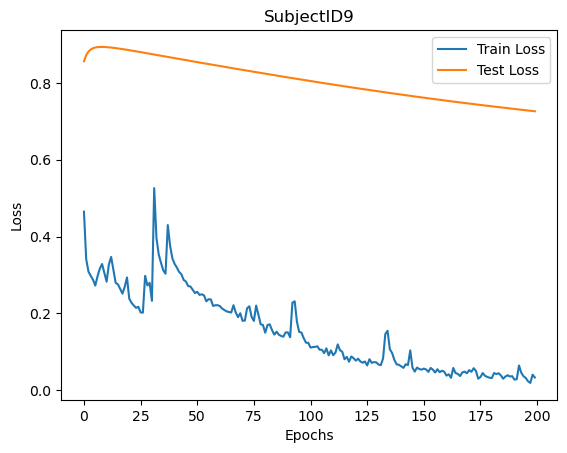

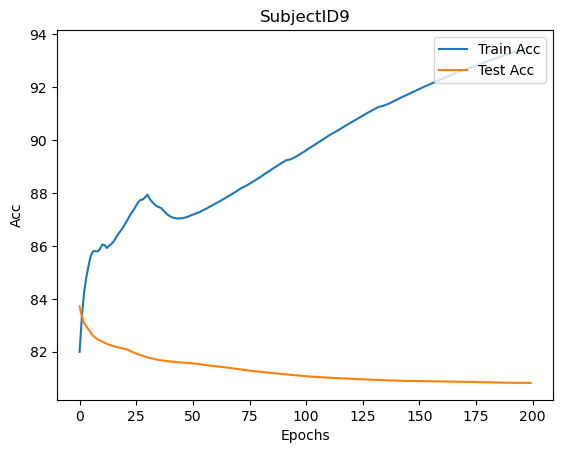

| epoch   0 | 0.0343 s/epoch | train loss 0.4549
| epoch   1 | 0.0335 s/epoch | train loss 0.3931
| epoch   2 | 0.0340 s/epoch | train loss 0.3677
| epoch   3 | 0.0349 s/epoch | train loss 0.3589
| epoch   4 | 0.0342 s/epoch | train loss 0.3583
| epoch   5 | 0.0333 s/epoch | train loss 0.3311
| epoch   6 | 0.0344 s/epoch | train loss 0.3230
| epoch   7 | 0.0340 s/epoch | train loss 0.3219
| epoch   8 | 0.0344 s/epoch | train loss 0.3001
| epoch   9 | 0.0332 s/epoch | train loss 0.2976
| epoch  10 | 0.0342 s/epoch | train loss 0.3009
| epoch  11 | 0.0347 s/epoch | train loss 0.3111
| epoch  12 | 0.0334 s/epoch | train loss 0.3022
| epoch  13 | 0.0347 s/epoch | train loss 0.2995
| epoch  14 | 0.0341 s/epoch | train loss 0.2898
| epoch  15 | 0.0342 s/epoch | train loss 0.2763
| epoch  16 | 0.0337 s/epoch | train loss 0.2768
| epoch  17 | 0.0340 s/epoch | train loss 0.2675
| epoch  18 | 0.0339 s/epoch | train loss 0.2622
| epoch  19 | 0.0342 s/epoch | train loss 0.2552
| epoch  20 | 0.0338

| epoch 168 | 0.0344 s/epoch | train loss 0.0679
| epoch 169 | 0.0339 s/epoch | train loss 0.0653
| epoch 170 | 0.0348 s/epoch | train loss 0.0694
| epoch 171 | 0.0344 s/epoch | train loss 0.0616
| epoch 172 | 0.0349 s/epoch | train loss 0.0732
| epoch 173 | 0.0341 s/epoch | train loss 0.0609
| epoch 174 | 0.0338 s/epoch | train loss 0.0661
| epoch 175 | 0.0338 s/epoch | train loss 0.0626
| epoch 176 | 0.0340 s/epoch | train loss 0.0613
| epoch 177 | 0.0336 s/epoch | train loss 0.0635
| epoch 178 | 0.0336 s/epoch | train loss 0.0684
| epoch 179 | 0.0348 s/epoch | train loss 0.0609
| epoch 180 | 0.0342 s/epoch | train loss 0.0614
| epoch 181 | 0.0340 s/epoch | train loss 0.0649
| epoch 182 | 0.0337 s/epoch | train loss 0.0646
| epoch 183 | 0.0348 s/epoch | train loss 0.0619
| epoch 184 | 0.0341 s/epoch | train loss 0.0567
| epoch 185 | 0.0342 s/epoch | train loss 0.0770
| epoch 186 | 0.0344 s/epoch | train loss 0.0591
| epoch 187 | 0.0341 s/epoch | train loss 0.0597
| epoch 188 | 0.0341

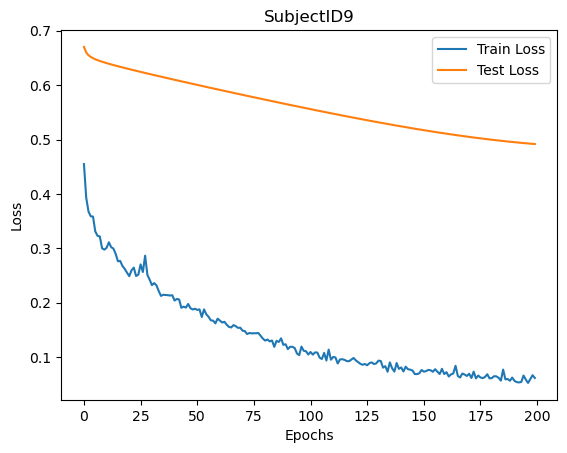

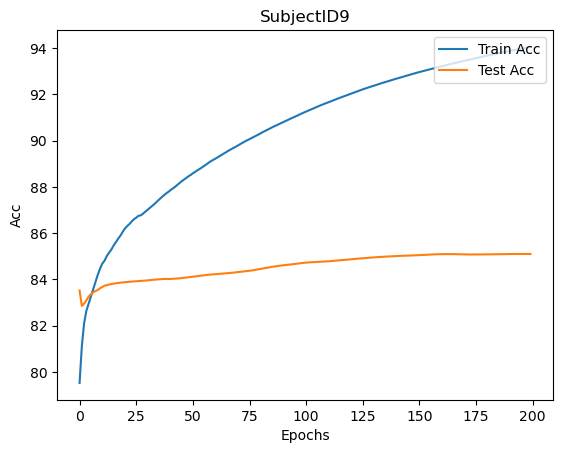


Subject 10
| epoch   0 | 0.1101 s/epoch | train loss 0.5554
| epoch   1 | 0.1097 s/epoch | train loss 0.3986
| epoch   2 | 0.1096 s/epoch | train loss 0.4203
| epoch   3 | 0.1093 s/epoch | train loss 0.3938
| epoch   4 | 0.1090 s/epoch | train loss 0.3247
| epoch   5 | 0.1090 s/epoch | train loss 0.2978
| epoch   6 | 0.1096 s/epoch | train loss 0.2977
| epoch   7 | 0.1092 s/epoch | train loss 0.4311
| epoch   8 | 0.1091 s/epoch | train loss 0.4803
| epoch   9 | 0.1099 s/epoch | train loss 0.4103
| epoch  10 | 0.1094 s/epoch | train loss 0.3502
| epoch  11 | 0.1132 s/epoch | train loss 0.4561
| epoch  12 | 0.1125 s/epoch | train loss 0.3550
| epoch  13 | 0.1121 s/epoch | train loss 0.3341
| epoch  14 | 0.1124 s/epoch | train loss 0.3155
| epoch  15 | 0.1130 s/epoch | train loss 0.3018
| epoch  16 | 0.1124 s/epoch | train loss 0.2938
| epoch  17 | 0.1126 s/epoch | train loss 0.3052
| epoch  18 | 0.1127 s/epoch | train loss 0.4294
| epoch  19 | 0.1125 s/epoch | train loss 0.4236
| epoch 

| epoch 167 | 0.1123 s/epoch | train loss 0.1826
| epoch 168 | 0.1125 s/epoch | train loss 0.1765
| epoch 169 | 0.1120 s/epoch | train loss 0.1820
| epoch 170 | 0.1126 s/epoch | train loss 0.1802
| epoch 171 | 0.1122 s/epoch | train loss 0.1634
| epoch 172 | 0.1125 s/epoch | train loss 0.1599
| epoch 173 | 0.1129 s/epoch | train loss 0.1647
| epoch 174 | 0.1130 s/epoch | train loss 0.1612
| epoch 175 | 0.1123 s/epoch | train loss 0.1706
| epoch 176 | 0.1124 s/epoch | train loss 0.1612
| epoch 177 | 0.1124 s/epoch | train loss 0.1543
| epoch 178 | 0.1124 s/epoch | train loss 0.1460
| epoch 179 | 0.1127 s/epoch | train loss 0.1486
| epoch 180 | 0.1128 s/epoch | train loss 0.1549
| epoch 181 | 0.1126 s/epoch | train loss 0.1331
| epoch 182 | 0.1120 s/epoch | train loss 0.1327
| epoch 183 | 0.1128 s/epoch | train loss 0.1469
| epoch 184 | 0.1130 s/epoch | train loss 0.1401
| epoch 185 | 0.1127 s/epoch | train loss 0.1316
| epoch 186 | 0.1122 s/epoch | train loss 0.1295
| epoch 187 | 0.1126

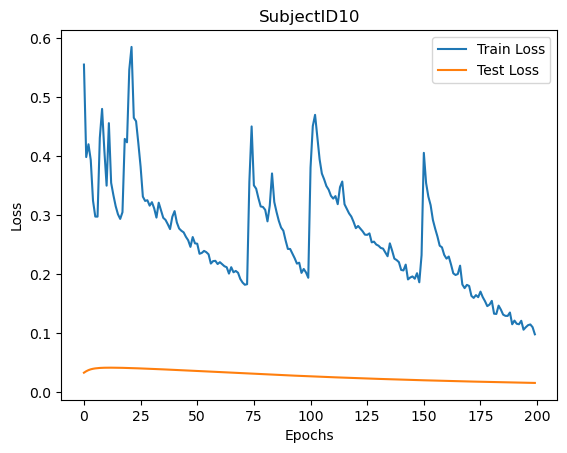

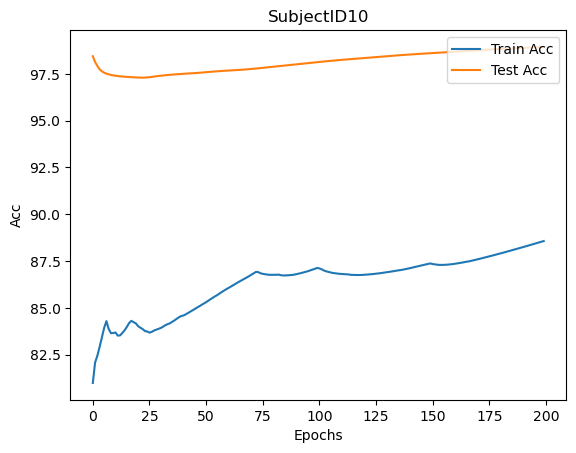

| epoch   0 | 0.0341 s/epoch | train loss 0.4700
| epoch   1 | 0.0348 s/epoch | train loss 0.4247
| epoch   2 | 0.0355 s/epoch | train loss 0.3921
| epoch   3 | 0.0353 s/epoch | train loss 0.3775
| epoch   4 | 0.0353 s/epoch | train loss 0.3566
| epoch   5 | 0.0356 s/epoch | train loss 0.3564
| epoch   6 | 0.0349 s/epoch | train loss 0.3328
| epoch   7 | 0.0356 s/epoch | train loss 0.3466
| epoch   8 | 0.0353 s/epoch | train loss 0.3353
| epoch   9 | 0.0344 s/epoch | train loss 0.3268
| epoch  10 | 0.0337 s/epoch | train loss 0.3227
| epoch  11 | 0.0357 s/epoch | train loss 0.3257
| epoch  12 | 0.0355 s/epoch | train loss 0.3810
| epoch  13 | 0.0356 s/epoch | train loss 0.3463
| epoch  14 | 0.0363 s/epoch | train loss 0.3213
| epoch  15 | 0.0366 s/epoch | train loss 0.3144
| epoch  16 | 0.0363 s/epoch | train loss 0.3362
| epoch  17 | 0.0350 s/epoch | train loss 0.3775
| epoch  18 | 0.0356 s/epoch | train loss 0.3852
| epoch  19 | 0.0346 s/epoch | train loss 0.3374
| epoch  20 | 0.0359

| epoch 168 | 0.0360 s/epoch | train loss 0.0729
| epoch 169 | 0.0354 s/epoch | train loss 0.0658
| epoch 170 | 0.0360 s/epoch | train loss 0.0678
| epoch 171 | 0.0357 s/epoch | train loss 0.0808
| epoch 172 | 0.0353 s/epoch | train loss 0.0766
| epoch 173 | 0.0364 s/epoch | train loss 0.0773
| epoch 174 | 0.0356 s/epoch | train loss 0.0662
| epoch 175 | 0.0356 s/epoch | train loss 0.0633
| epoch 176 | 0.0358 s/epoch | train loss 0.0659
| epoch 177 | 0.0356 s/epoch | train loss 0.0721
| epoch 178 | 0.0358 s/epoch | train loss 0.0756
| epoch 179 | 0.0351 s/epoch | train loss 0.0620
| epoch 180 | 0.0355 s/epoch | train loss 0.0688
| epoch 181 | 0.0352 s/epoch | train loss 0.0709
| epoch 182 | 0.0359 s/epoch | train loss 0.0711
| epoch 183 | 0.0360 s/epoch | train loss 0.0723
| epoch 184 | 0.0356 s/epoch | train loss 0.0595
| epoch 185 | 0.0363 s/epoch | train loss 0.0671
| epoch 186 | 0.0357 s/epoch | train loss 0.0637
| epoch 187 | 0.0367 s/epoch | train loss 0.0588
| epoch 188 | 0.0353

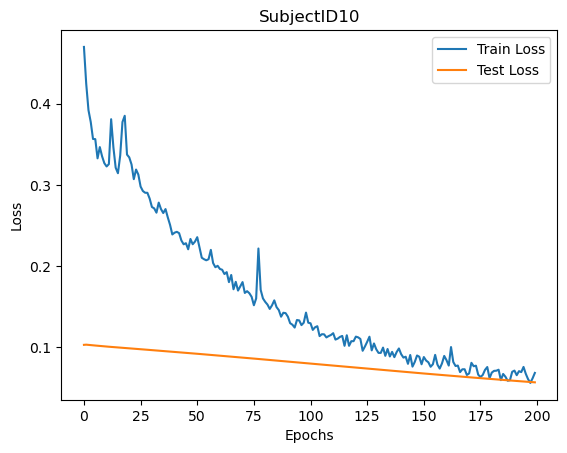

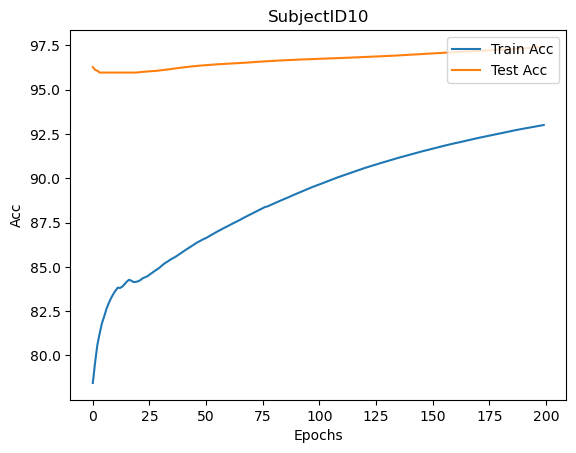


Subject 11
| epoch   0 | 0.1127 s/epoch | train loss 0.4852
| epoch   1 | 0.1122 s/epoch | train loss 0.3517
| epoch   2 | 0.1119 s/epoch | train loss 0.3332
| epoch   3 | 0.1115 s/epoch | train loss 0.3585
| epoch   4 | 0.1114 s/epoch | train loss 0.3165
| epoch   5 | 0.1113 s/epoch | train loss 0.3024
| epoch   6 | 0.1115 s/epoch | train loss 0.3048
| epoch   7 | 0.1111 s/epoch | train loss 0.3407
| epoch   8 | 0.1113 s/epoch | train loss 0.2996
| epoch   9 | 0.1112 s/epoch | train loss 0.3708
| epoch  10 | 0.1119 s/epoch | train loss 0.2725
| epoch  11 | 0.1108 s/epoch | train loss 0.2585
| epoch  12 | 0.1125 s/epoch | train loss 0.2461
| epoch  13 | 0.1116 s/epoch | train loss 0.2436
| epoch  14 | 0.1120 s/epoch | train loss 0.2534
| epoch  15 | 0.1115 s/epoch | train loss 0.2381
| epoch  16 | 0.1115 s/epoch | train loss 0.2497
| epoch  17 | 0.1117 s/epoch | train loss 0.2378
| epoch  18 | 0.1108 s/epoch | train loss 0.2189
| epoch  19 | 0.1113 s/epoch | train loss 0.2197
| epoch 

| epoch 167 | 0.1116 s/epoch | train loss 0.0326
| epoch 168 | 0.1117 s/epoch | train loss 0.0415
| epoch 169 | 0.1119 s/epoch | train loss 0.0652
| epoch 170 | 0.1119 s/epoch | train loss 0.0451
| epoch 171 | 0.1112 s/epoch | train loss 0.0579
| epoch 172 | 0.1118 s/epoch | train loss 0.0852
| epoch 173 | 0.1117 s/epoch | train loss 0.0461
| epoch 174 | 0.1117 s/epoch | train loss 0.0337
| epoch 175 | 0.1119 s/epoch | train loss 0.0356
| epoch 176 | 0.1118 s/epoch | train loss 0.0340
| epoch 177 | 0.1110 s/epoch | train loss 0.0353
| epoch 178 | 0.1120 s/epoch | train loss 0.0330
| epoch 179 | 0.1113 s/epoch | train loss 0.0286
| epoch 180 | 0.1115 s/epoch | train loss 0.0338
| epoch 181 | 0.1119 s/epoch | train loss 0.0201
| epoch 182 | 0.1117 s/epoch | train loss 0.0350
| epoch 183 | 0.1117 s/epoch | train loss 0.0316
| epoch 184 | 0.1116 s/epoch | train loss 0.0266
| epoch 185 | 0.1123 s/epoch | train loss 0.0320
| epoch 186 | 0.1114 s/epoch | train loss 0.0276
| epoch 187 | 0.1115

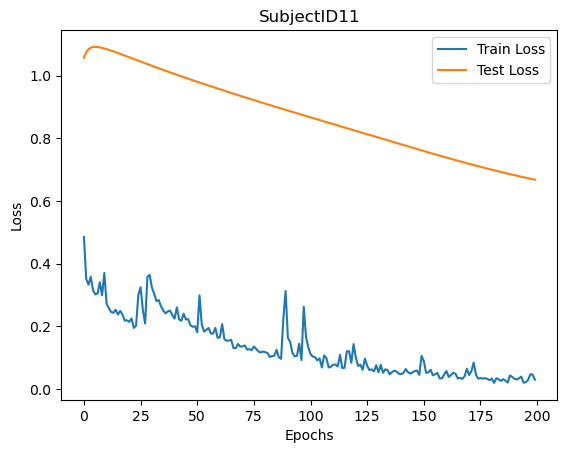

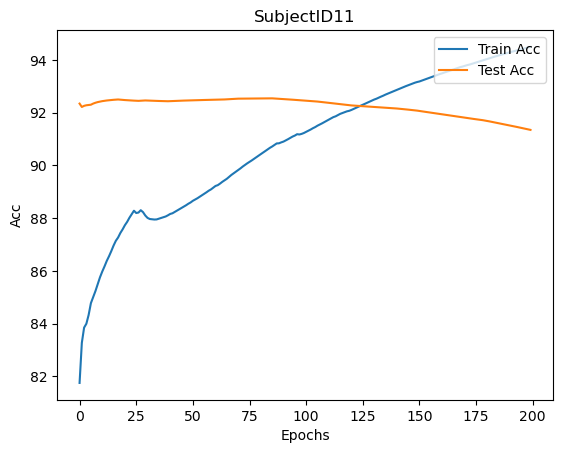

| epoch   0 | 0.0353 s/epoch | train loss 0.4771
| epoch   1 | 0.0354 s/epoch | train loss 0.3916
| epoch   2 | 0.0363 s/epoch | train loss 0.3734
| epoch   3 | 0.0354 s/epoch | train loss 0.3665
| epoch   4 | 0.0354 s/epoch | train loss 0.3485
| epoch   5 | 0.0357 s/epoch | train loss 0.3419
| epoch   6 | 0.0349 s/epoch | train loss 0.3462
| epoch   7 | 0.0351 s/epoch | train loss 0.3582
| epoch   8 | 0.0347 s/epoch | train loss 0.3680
| epoch   9 | 0.0350 s/epoch | train loss 0.3680
| epoch  10 | 0.0358 s/epoch | train loss 0.3578
| epoch  11 | 0.0347 s/epoch | train loss 0.3301
| epoch  12 | 0.0353 s/epoch | train loss 0.3198
| epoch  13 | 0.0351 s/epoch | train loss 0.3117
| epoch  14 | 0.0354 s/epoch | train loss 0.3156
| epoch  15 | 0.0354 s/epoch | train loss 0.3185
| epoch  16 | 0.0362 s/epoch | train loss 0.2926
| epoch  17 | 0.0364 s/epoch | train loss 0.2992
| epoch  18 | 0.0354 s/epoch | train loss 0.3098
| epoch  19 | 0.0348 s/epoch | train loss 0.2995
| epoch  20 | 0.0353

| epoch 168 | 0.0349 s/epoch | train loss 0.0933
| epoch 169 | 0.0356 s/epoch | train loss 0.1025
| epoch 170 | 0.0353 s/epoch | train loss 0.1008
| epoch 171 | 0.0355 s/epoch | train loss 0.0980
| epoch 172 | 0.0353 s/epoch | train loss 0.0853
| epoch 173 | 0.0352 s/epoch | train loss 0.0841
| epoch 174 | 0.0349 s/epoch | train loss 0.0834
| epoch 175 | 0.0350 s/epoch | train loss 0.0865
| epoch 176 | 0.0351 s/epoch | train loss 0.0723
| epoch 177 | 0.0356 s/epoch | train loss 0.0655
| epoch 178 | 0.0354 s/epoch | train loss 0.0774
| epoch 179 | 0.0356 s/epoch | train loss 0.0953
| epoch 180 | 0.0358 s/epoch | train loss 0.0860
| epoch 181 | 0.0352 s/epoch | train loss 0.0799
| epoch 182 | 0.0347 s/epoch | train loss 0.0738
| epoch 183 | 0.0355 s/epoch | train loss 0.0678
| epoch 184 | 0.0364 s/epoch | train loss 0.0747
| epoch 185 | 0.0354 s/epoch | train loss 0.0721
| epoch 186 | 0.0350 s/epoch | train loss 0.0883
| epoch 187 | 0.0348 s/epoch | train loss 0.0700
| epoch 188 | 0.0350

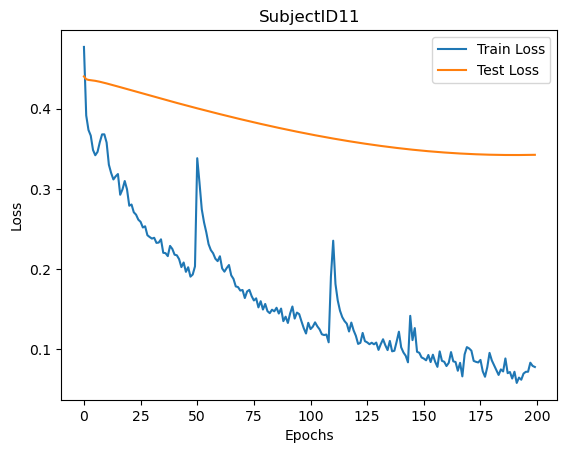

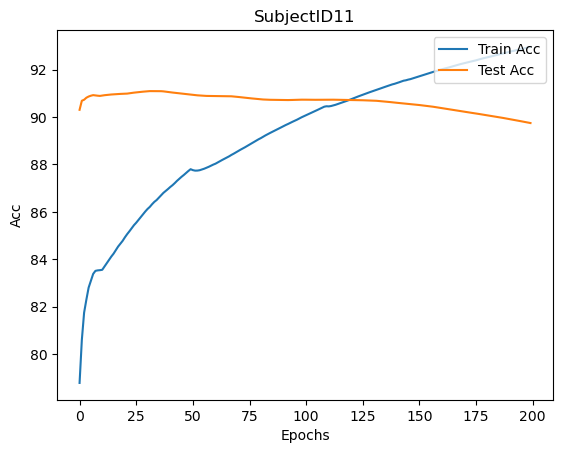


Subject 12
| epoch   0 | 0.1067 s/epoch | train loss 0.4626
| epoch   1 | 0.1061 s/epoch | train loss 0.3822
| epoch   2 | 0.1063 s/epoch | train loss 0.3803
| epoch   3 | 0.1061 s/epoch | train loss 0.3247
| epoch   4 | 0.1060 s/epoch | train loss 0.3100
| epoch   5 | 0.1063 s/epoch | train loss 0.2969
| epoch   6 | 0.1061 s/epoch | train loss 0.3192
| epoch   7 | 0.1055 s/epoch | train loss 0.5538
| epoch   8 | 0.1059 s/epoch | train loss 0.4351
| epoch   9 | 0.1067 s/epoch | train loss 0.3625
| epoch  10 | 0.1060 s/epoch | train loss 0.3237
| epoch  11 | 0.1062 s/epoch | train loss 0.3376
| epoch  12 | 0.1057 s/epoch | train loss 0.3022
| epoch  13 | 0.1057 s/epoch | train loss 0.2873
| epoch  14 | 0.1060 s/epoch | train loss 0.2892
| epoch  15 | 0.1063 s/epoch | train loss 0.2691
| epoch  16 | 0.1065 s/epoch | train loss 0.2588
| epoch  17 | 0.1062 s/epoch | train loss 0.2466
| epoch  18 | 0.1068 s/epoch | train loss 0.2484
| epoch  19 | 0.1057 s/epoch | train loss 0.2354
| epoch 

| epoch 167 | 0.1063 s/epoch | train loss 0.0688
| epoch 168 | 0.1058 s/epoch | train loss 0.0561
| epoch 169 | 0.1064 s/epoch | train loss 0.0397
| epoch 170 | 0.1061 s/epoch | train loss 0.0314
| epoch 171 | 0.1060 s/epoch | train loss 0.0406
| epoch 172 | 0.1060 s/epoch | train loss 0.0436
| epoch 173 | 0.1064 s/epoch | train loss 0.0627
| epoch 174 | 0.1063 s/epoch | train loss 0.0464
| epoch 175 | 0.1066 s/epoch | train loss 0.0346
| epoch 176 | 0.1061 s/epoch | train loss 0.0380
| epoch 177 | 0.1065 s/epoch | train loss 0.0396
| epoch 178 | 0.1065 s/epoch | train loss 0.0362
| epoch 179 | 0.1059 s/epoch | train loss 0.0365
| epoch 180 | 0.1064 s/epoch | train loss 0.0617
| epoch 181 | 0.1059 s/epoch | train loss 0.3158
| epoch 182 | 0.1061 s/epoch | train loss 0.1762
| epoch 183 | 0.1060 s/epoch | train loss 0.1043
| epoch 184 | 0.1063 s/epoch | train loss 0.0786
| epoch 185 | 0.1064 s/epoch | train loss 0.0453
| epoch 186 | 0.1063 s/epoch | train loss 0.0529
| epoch 187 | 0.1065

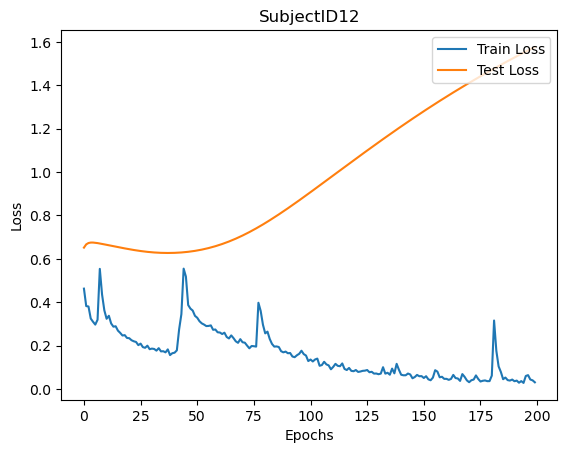

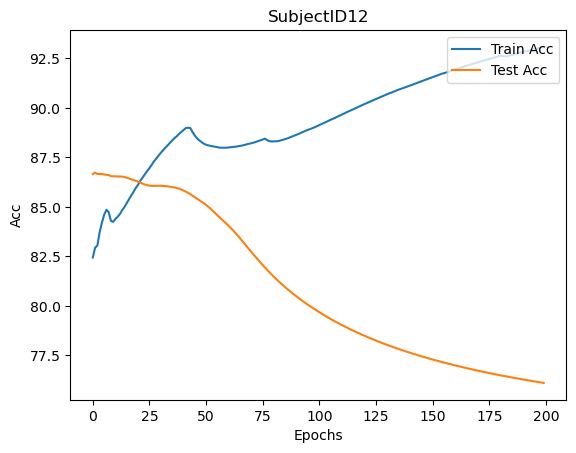

| epoch   0 | 0.0338 s/epoch | train loss 0.4550
| epoch   1 | 0.0337 s/epoch | train loss 0.4109
| epoch   2 | 0.0337 s/epoch | train loss 0.3770
| epoch   3 | 0.0333 s/epoch | train loss 0.3608
| epoch   4 | 0.0338 s/epoch | train loss 0.3554
| epoch   5 | 0.0335 s/epoch | train loss 0.3533
| epoch   6 | 0.0341 s/epoch | train loss 0.3203
| epoch   7 | 0.0340 s/epoch | train loss 0.3217
| epoch   8 | 0.0340 s/epoch | train loss 0.3058
| epoch   9 | 0.0338 s/epoch | train loss 0.3031
| epoch  10 | 0.0334 s/epoch | train loss 0.2965
| epoch  11 | 0.0338 s/epoch | train loss 0.2918
| epoch  12 | 0.0336 s/epoch | train loss 0.3048
| epoch  13 | 0.0339 s/epoch | train loss 0.2998
| epoch  14 | 0.0339 s/epoch | train loss 0.2766
| epoch  15 | 0.0330 s/epoch | train loss 0.2842
| epoch  16 | 0.0338 s/epoch | train loss 0.2816
| epoch  17 | 0.0336 s/epoch | train loss 0.2761
| epoch  18 | 0.0336 s/epoch | train loss 0.2678
| epoch  19 | 0.0347 s/epoch | train loss 0.2562
| epoch  20 | 0.0336

| epoch 168 | 0.0337 s/epoch | train loss 0.1087
| epoch 169 | 0.0339 s/epoch | train loss 0.1550
| epoch 170 | 0.0336 s/epoch | train loss 0.1987
| epoch 171 | 0.0333 s/epoch | train loss 0.1841
| epoch 172 | 0.0334 s/epoch | train loss 0.1467
| epoch 173 | 0.0334 s/epoch | train loss 0.1276
| epoch 174 | 0.0338 s/epoch | train loss 0.1099
| epoch 175 | 0.0336 s/epoch | train loss 0.1096
| epoch 176 | 0.0342 s/epoch | train loss 0.1083
| epoch 177 | 0.0336 s/epoch | train loss 0.0913
| epoch 178 | 0.0338 s/epoch | train loss 0.0987
| epoch 179 | 0.0343 s/epoch | train loss 0.1068
| epoch 180 | 0.0340 s/epoch | train loss 0.0935
| epoch 181 | 0.0332 s/epoch | train loss 0.1068
| epoch 182 | 0.0337 s/epoch | train loss 0.0977
| epoch 183 | 0.0338 s/epoch | train loss 0.0863
| epoch 184 | 0.0339 s/epoch | train loss 0.0921
| epoch 185 | 0.0334 s/epoch | train loss 0.0863
| epoch 186 | 0.0339 s/epoch | train loss 0.0953
| epoch 187 | 0.0335 s/epoch | train loss 0.0764
| epoch 188 | 0.0338

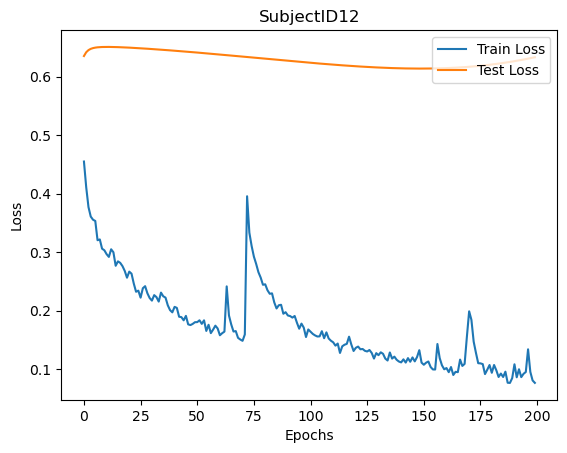

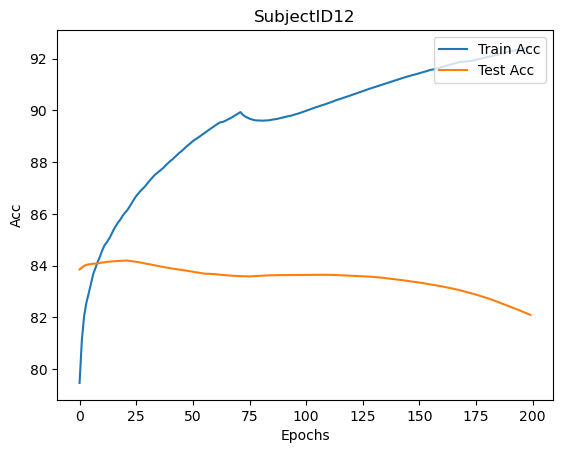


Subject 13
| epoch   0 | 0.1073 s/epoch | train loss 0.4984
| epoch   1 | 0.1070 s/epoch | train loss 0.3294
| epoch   2 | 0.1065 s/epoch | train loss 0.2912
| epoch   3 | 0.1068 s/epoch | train loss 0.2950
| epoch   4 | 0.1059 s/epoch | train loss 0.2762
| epoch   5 | 0.1062 s/epoch | train loss 0.2702
| epoch   6 | 0.1064 s/epoch | train loss 0.2717
| epoch   7 | 0.1064 s/epoch | train loss 0.2474
| epoch   8 | 0.1062 s/epoch | train loss 0.2428
| epoch   9 | 0.1059 s/epoch | train loss 0.2357
| epoch  10 | 0.1062 s/epoch | train loss 0.2224
| epoch  11 | 0.1063 s/epoch | train loss 0.3127
| epoch  12 | 0.1065 s/epoch | train loss 0.3882
| epoch  13 | 0.1068 s/epoch | train loss 0.3400
| epoch  14 | 0.1066 s/epoch | train loss 0.2929
| epoch  15 | 0.1064 s/epoch | train loss 0.2989
| epoch  16 | 0.1062 s/epoch | train loss 0.2587
| epoch  17 | 0.1059 s/epoch | train loss 0.2502
| epoch  18 | 0.1064 s/epoch | train loss 0.2440
| epoch  19 | 0.1065 s/epoch | train loss 0.2400
| epoch 

| epoch 167 | 0.1067 s/epoch | train loss 0.0429
| epoch 168 | 0.1072 s/epoch | train loss 0.0413
| epoch 169 | 0.1069 s/epoch | train loss 0.0370
| epoch 170 | 0.1067 s/epoch | train loss 0.0567
| epoch 171 | 0.1057 s/epoch | train loss 0.0356
| epoch 172 | 0.1067 s/epoch | train loss 0.0451
| epoch 173 | 0.1060 s/epoch | train loss 0.0546
| epoch 174 | 0.1067 s/epoch | train loss 0.0420
| epoch 175 | 0.1068 s/epoch | train loss 0.0362
| epoch 176 | 0.1042 s/epoch | train loss 0.0374
| epoch 177 | 0.1035 s/epoch | train loss 0.1684
| epoch 178 | 0.1035 s/epoch | train loss 0.1101
| epoch 179 | 0.1032 s/epoch | train loss 0.0551
| epoch 180 | 0.1034 s/epoch | train loss 0.0433
| epoch 181 | 0.1039 s/epoch | train loss 0.0641
| epoch 182 | 0.1039 s/epoch | train loss 0.0883
| epoch 183 | 0.1031 s/epoch | train loss 0.0552
| epoch 184 | 0.1035 s/epoch | train loss 0.0472
| epoch 185 | 0.1038 s/epoch | train loss 0.0327
| epoch 186 | 0.0967 s/epoch | train loss 0.0330
| epoch 187 | 0.1064

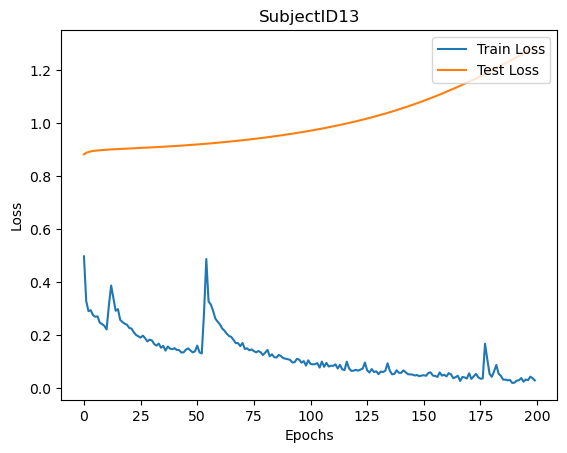

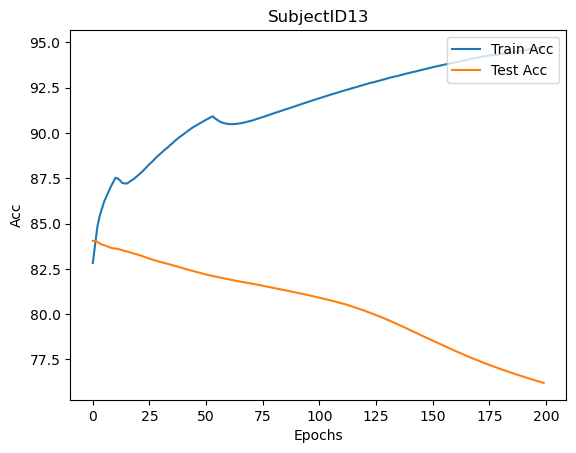

| epoch   0 | 0.0337 s/epoch | train loss 0.4534
| epoch   1 | 0.0335 s/epoch | train loss 0.3896
| epoch   2 | 0.0335 s/epoch | train loss 0.3612
| epoch   3 | 0.0342 s/epoch | train loss 0.3483
| epoch   4 | 0.0339 s/epoch | train loss 0.3435
| epoch   5 | 0.0338 s/epoch | train loss 0.3357
| epoch   6 | 0.0345 s/epoch | train loss 0.3248
| epoch   7 | 0.0336 s/epoch | train loss 0.3120
| epoch   8 | 0.0336 s/epoch | train loss 0.3077
| epoch   9 | 0.0336 s/epoch | train loss 0.2958
| epoch  10 | 0.0335 s/epoch | train loss 0.2989
| epoch  11 | 0.0343 s/epoch | train loss 0.2942
| epoch  12 | 0.0334 s/epoch | train loss 0.2898
| epoch  13 | 0.0339 s/epoch | train loss 0.2949
| epoch  14 | 0.0330 s/epoch | train loss 0.2961
| epoch  15 | 0.0332 s/epoch | train loss 0.2910
| epoch  16 | 0.0340 s/epoch | train loss 0.2746
| epoch  17 | 0.0333 s/epoch | train loss 0.2831
| epoch  18 | 0.0339 s/epoch | train loss 0.2731
| epoch  19 | 0.0341 s/epoch | train loss 0.2637
| epoch  20 | 0.0336

| epoch 168 | 0.0342 s/epoch | train loss 0.0769
| epoch 169 | 0.0331 s/epoch | train loss 0.0983
| epoch 170 | 0.0337 s/epoch | train loss 0.0985
| epoch 171 | 0.0340 s/epoch | train loss 0.0876
| epoch 172 | 0.0346 s/epoch | train loss 0.0950
| epoch 173 | 0.0340 s/epoch | train loss 0.0856
| epoch 174 | 0.0339 s/epoch | train loss 0.0754
| epoch 175 | 0.0339 s/epoch | train loss 0.0682
| epoch 176 | 0.0332 s/epoch | train loss 0.0766
| epoch 177 | 0.0336 s/epoch | train loss 0.0748
| epoch 178 | 0.0331 s/epoch | train loss 0.0730
| epoch 179 | 0.0343 s/epoch | train loss 0.0704
| epoch 180 | 0.0340 s/epoch | train loss 0.0671
| epoch 181 | 0.0333 s/epoch | train loss 0.0660
| epoch 182 | 0.0338 s/epoch | train loss 0.0790
| epoch 183 | 0.0335 s/epoch | train loss 0.0799
| epoch 184 | 0.0340 s/epoch | train loss 0.0593
| epoch 185 | 0.0349 s/epoch | train loss 0.0673
| epoch 186 | 0.0341 s/epoch | train loss 0.0822
| epoch 187 | 0.0342 s/epoch | train loss 0.0836
| epoch 188 | 0.0339

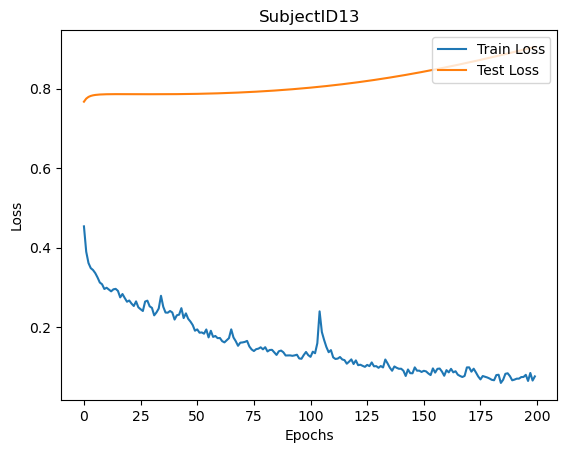

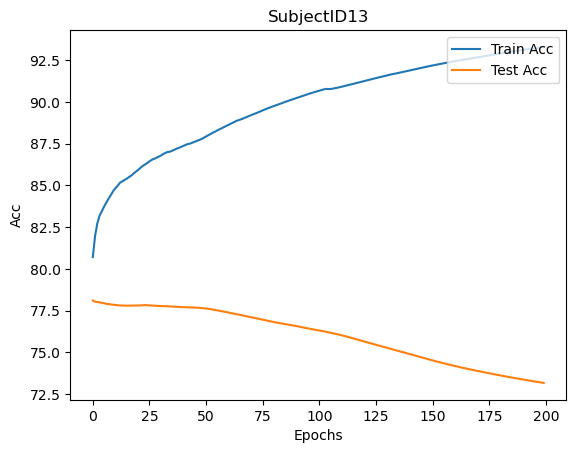


Subject 14
| epoch   0 | 0.1103 s/epoch | train loss 0.4841
| epoch   1 | 0.1105 s/epoch | train loss 0.3983
| epoch   2 | 0.1108 s/epoch | train loss 0.3944
| epoch   3 | 0.1106 s/epoch | train loss 0.4709
| epoch   4 | 0.1097 s/epoch | train loss 0.3522
| epoch   5 | 0.1106 s/epoch | train loss 0.3132
| epoch   6 | 0.1101 s/epoch | train loss 0.3217
| epoch   7 | 0.1106 s/epoch | train loss 0.2884
| epoch   8 | 0.1102 s/epoch | train loss 0.2677
| epoch   9 | 0.1099 s/epoch | train loss 0.2558
| epoch  10 | 0.1108 s/epoch | train loss 0.2585
| epoch  11 | 0.1108 s/epoch | train loss 0.2510
| epoch  12 | 0.1105 s/epoch | train loss 0.2351
| epoch  13 | 0.1105 s/epoch | train loss 0.2505
| epoch  14 | 0.1103 s/epoch | train loss 0.4529
| epoch  15 | 0.1104 s/epoch | train loss 0.3636
| epoch  16 | 0.1101 s/epoch | train loss 0.3419
| epoch  17 | 0.1110 s/epoch | train loss 0.3595
| epoch  18 | 0.1107 s/epoch | train loss 0.3330
| epoch  19 | 0.1104 s/epoch | train loss 0.3042
| epoch 

| epoch 167 | 0.1106 s/epoch | train loss 0.1428
| epoch 168 | 0.1107 s/epoch | train loss 0.1215
| epoch 169 | 0.1103 s/epoch | train loss 0.1111
| epoch 170 | 0.1109 s/epoch | train loss 0.1063
| epoch 171 | 0.1105 s/epoch | train loss 0.1208
| epoch 172 | 0.1102 s/epoch | train loss 0.1010
| epoch 173 | 0.1099 s/epoch | train loss 0.0966
| epoch 174 | 0.1104 s/epoch | train loss 0.0955
| epoch 175 | 0.1108 s/epoch | train loss 0.0943
| epoch 176 | 0.1103 s/epoch | train loss 0.1044
| epoch 177 | 0.1105 s/epoch | train loss 0.1536
| epoch 178 | 0.1106 s/epoch | train loss 0.1209
| epoch 179 | 0.1105 s/epoch | train loss 0.1214
| epoch 180 | 0.1103 s/epoch | train loss 0.1007
| epoch 181 | 0.1109 s/epoch | train loss 0.1093
| epoch 182 | 0.1107 s/epoch | train loss 0.1026
| epoch 183 | 0.1100 s/epoch | train loss 0.0906
| epoch 184 | 0.1106 s/epoch | train loss 0.0936
| epoch 185 | 0.1109 s/epoch | train loss 0.1459
| epoch 186 | 0.1102 s/epoch | train loss 0.0945
| epoch 187 | 0.1104

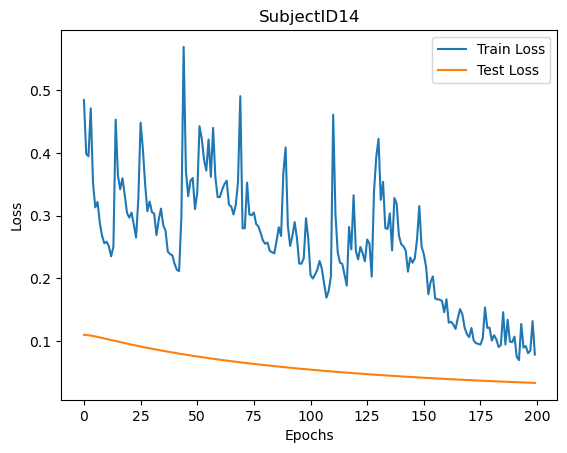

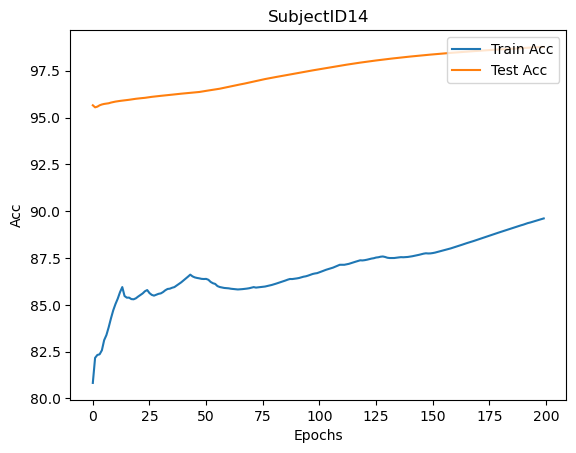

| epoch   0 | 0.0352 s/epoch | train loss 0.4803
| epoch   1 | 0.0347 s/epoch | train loss 0.4383
| epoch   2 | 0.0351 s/epoch | train loss 0.4323
| epoch   3 | 0.0354 s/epoch | train loss 0.4097
| epoch   4 | 0.0346 s/epoch | train loss 0.3859
| epoch   5 | 0.0349 s/epoch | train loss 0.3793
| epoch   6 | 0.0350 s/epoch | train loss 0.3875
| epoch   7 | 0.0349 s/epoch | train loss 0.3859
| epoch   8 | 0.0352 s/epoch | train loss 0.4053
| epoch   9 | 0.0361 s/epoch | train loss 0.3987
| epoch  10 | 0.0350 s/epoch | train loss 0.3853
| epoch  11 | 0.0346 s/epoch | train loss 0.3968
| epoch  12 | 0.0347 s/epoch | train loss 0.3834
| epoch  13 | 0.0350 s/epoch | train loss 0.3688
| epoch  14 | 0.0357 s/epoch | train loss 0.3660
| epoch  15 | 0.0343 s/epoch | train loss 0.3541
| epoch  16 | 0.0346 s/epoch | train loss 0.3737
| epoch  17 | 0.0352 s/epoch | train loss 0.3546
| epoch  18 | 0.0347 s/epoch | train loss 0.3504
| epoch  19 | 0.0350 s/epoch | train loss 0.3386
| epoch  20 | 0.0345

| epoch 168 | 0.0348 s/epoch | train loss 0.2008
| epoch 169 | 0.0351 s/epoch | train loss 0.1931
| epoch 170 | 0.0355 s/epoch | train loss 0.1931
| epoch 171 | 0.0351 s/epoch | train loss 0.1983
| epoch 172 | 0.0351 s/epoch | train loss 0.1987
| epoch 173 | 0.0351 s/epoch | train loss 0.1887
| epoch 174 | 0.0350 s/epoch | train loss 0.1982
| epoch 175 | 0.0347 s/epoch | train loss 0.2046
| epoch 176 | 0.0352 s/epoch | train loss 0.2472
| epoch 177 | 0.0345 s/epoch | train loss 0.2104
| epoch 178 | 0.0349 s/epoch | train loss 0.2314
| epoch 179 | 0.0350 s/epoch | train loss 0.2038
| epoch 180 | 0.0355 s/epoch | train loss 0.1939
| epoch 181 | 0.0351 s/epoch | train loss 0.1858
| epoch 182 | 0.0349 s/epoch | train loss 0.2143
| epoch 183 | 0.0350 s/epoch | train loss 0.2087
| epoch 184 | 0.0345 s/epoch | train loss 0.1869
| epoch 185 | 0.0346 s/epoch | train loss 0.1845
| epoch 186 | 0.0352 s/epoch | train loss 0.1833
| epoch 187 | 0.0352 s/epoch | train loss 0.1958
| epoch 188 | 0.0351

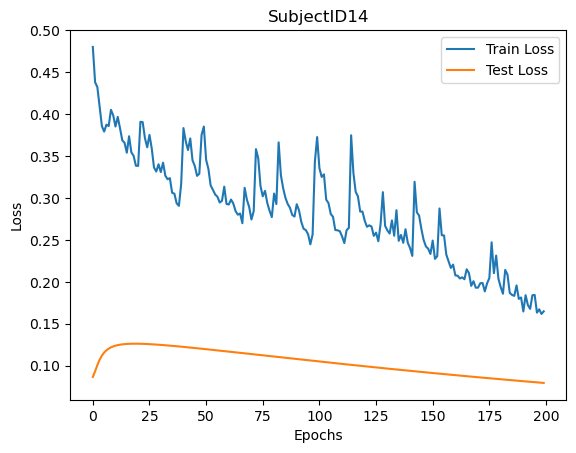

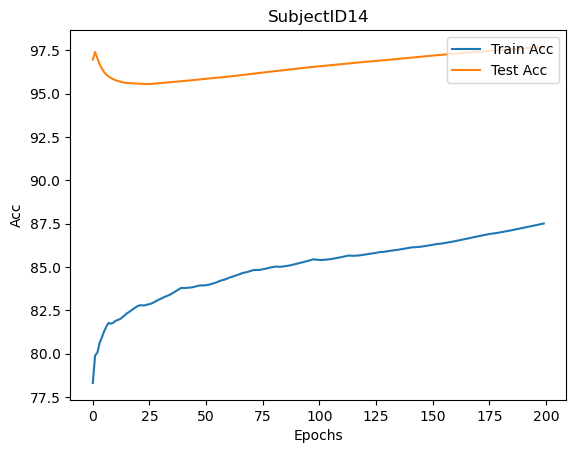


Subject 15
| epoch   0 | 0.1157 s/epoch | train loss 0.4862
| epoch   1 | 0.1154 s/epoch | train loss 0.3422
| epoch   2 | 0.1148 s/epoch | train loss 0.3141
| epoch   3 | 0.1146 s/epoch | train loss 0.3371
| epoch   4 | 0.1155 s/epoch | train loss 0.2967
| epoch   5 | 0.1151 s/epoch | train loss 0.2816
| epoch   6 | 0.1148 s/epoch | train loss 0.2692
| epoch   7 | 0.1145 s/epoch | train loss 0.2505
| epoch   8 | 0.1145 s/epoch | train loss 0.2513
| epoch   9 | 0.1150 s/epoch | train loss 0.2512
| epoch  10 | 0.1148 s/epoch | train loss 0.2903
| epoch  11 | 0.1149 s/epoch | train loss 0.5983
| epoch  12 | 0.1146 s/epoch | train loss 0.6298
| epoch  13 | 0.1148 s/epoch | train loss 0.4234
| epoch  14 | 0.1147 s/epoch | train loss 0.4295
| epoch  15 | 0.1156 s/epoch | train loss 0.4027
| epoch  16 | 0.1151 s/epoch | train loss 0.3813
| epoch  17 | 0.1153 s/epoch | train loss 0.3711
| epoch  18 | 0.1154 s/epoch | train loss 0.3679
| epoch  19 | 0.1150 s/epoch | train loss 0.3598
| epoch 

| epoch 167 | 0.1152 s/epoch | train loss 0.0658
| epoch 168 | 0.1152 s/epoch | train loss 0.0610
| epoch 169 | 0.1144 s/epoch | train loss 0.0630
| epoch 170 | 0.1158 s/epoch | train loss 0.0547
| epoch 171 | 0.1149 s/epoch | train loss 0.0553
| epoch 172 | 0.1147 s/epoch | train loss 0.0535
| epoch 173 | 0.1150 s/epoch | train loss 0.0453
| epoch 174 | 0.1144 s/epoch | train loss 0.0528
| epoch 175 | 0.1150 s/epoch | train loss 0.0575
| epoch 176 | 0.1154 s/epoch | train loss 0.0642
| epoch 177 | 0.1157 s/epoch | train loss 0.0419
| epoch 178 | 0.1152 s/epoch | train loss 0.0536
| epoch 179 | 0.1150 s/epoch | train loss 0.0452
| epoch 180 | 0.1155 s/epoch | train loss 0.0450
| epoch 181 | 0.1150 s/epoch | train loss 0.0441
| epoch 182 | 0.1150 s/epoch | train loss 0.0496
| epoch 183 | 0.1151 s/epoch | train loss 0.0496
| epoch 184 | 0.1152 s/epoch | train loss 0.0515
| epoch 185 | 0.1149 s/epoch | train loss 0.0462
| epoch 186 | 0.1153 s/epoch | train loss 0.0460
| epoch 187 | 0.1152

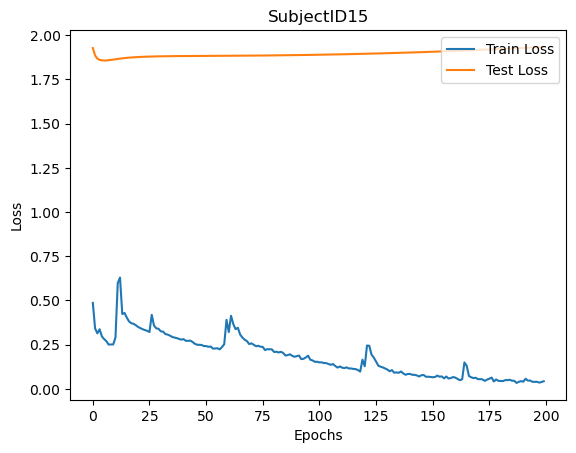

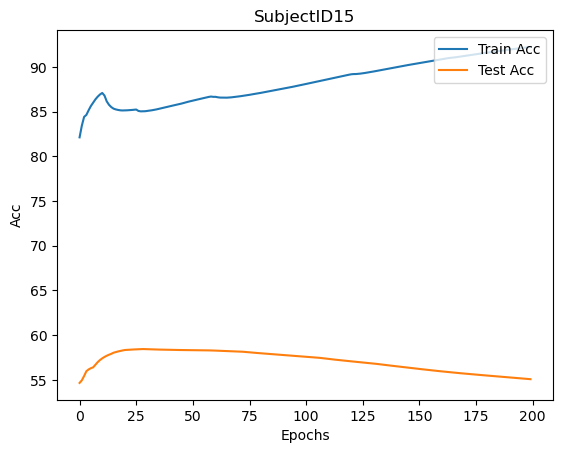

| epoch   0 | 0.0365 s/epoch | train loss 0.4527
| epoch   1 | 0.0366 s/epoch | train loss 0.3925
| epoch   2 | 0.0374 s/epoch | train loss 0.3652
| epoch   3 | 0.0362 s/epoch | train loss 0.3486
| epoch   4 | 0.0362 s/epoch | train loss 0.3349
| epoch   5 | 0.0357 s/epoch | train loss 0.3349
| epoch   6 | 0.0357 s/epoch | train loss 0.3194
| epoch   7 | 0.0362 s/epoch | train loss 0.3141
| epoch   8 | 0.0360 s/epoch | train loss 0.3000
| epoch   9 | 0.0369 s/epoch | train loss 0.3064
| epoch  10 | 0.0364 s/epoch | train loss 0.2979
| epoch  11 | 0.0365 s/epoch | train loss 0.2886
| epoch  12 | 0.0371 s/epoch | train loss 0.2956
| epoch  13 | 0.0365 s/epoch | train loss 0.3237
| epoch  14 | 0.0365 s/epoch | train loss 0.3005
| epoch  15 | 0.0366 s/epoch | train loss 0.2975
| epoch  16 | 0.0376 s/epoch | train loss 0.2862
| epoch  17 | 0.0363 s/epoch | train loss 0.2781
| epoch  18 | 0.0361 s/epoch | train loss 0.2695
| epoch  19 | 0.0361 s/epoch | train loss 0.2623
| epoch  20 | 0.0362

| epoch 168 | 0.0362 s/epoch | train loss 0.0708
| epoch 169 | 0.0371 s/epoch | train loss 0.0683
| epoch 170 | 0.0366 s/epoch | train loss 0.0618
| epoch 171 | 0.0357 s/epoch | train loss 0.0642
| epoch 172 | 0.0367 s/epoch | train loss 0.0641
| epoch 173 | 0.0369 s/epoch | train loss 0.0611
| epoch 174 | 0.0354 s/epoch | train loss 0.0593
| epoch 175 | 0.0367 s/epoch | train loss 0.0659
| epoch 176 | 0.0373 s/epoch | train loss 0.0601
| epoch 177 | 0.0371 s/epoch | train loss 0.0672
| epoch 178 | 0.0359 s/epoch | train loss 0.0664
| epoch 179 | 0.0368 s/epoch | train loss 0.0668
| epoch 180 | 0.0362 s/epoch | train loss 0.0558
| epoch 181 | 0.0365 s/epoch | train loss 0.0518
| epoch 182 | 0.0374 s/epoch | train loss 0.0597
| epoch 183 | 0.0358 s/epoch | train loss 0.0595
| epoch 184 | 0.0372 s/epoch | train loss 0.0588
| epoch 185 | 0.0363 s/epoch | train loss 0.0497
| epoch 186 | 0.0365 s/epoch | train loss 0.0636
| epoch 187 | 0.0367 s/epoch | train loss 0.0660
| epoch 188 | 0.0362

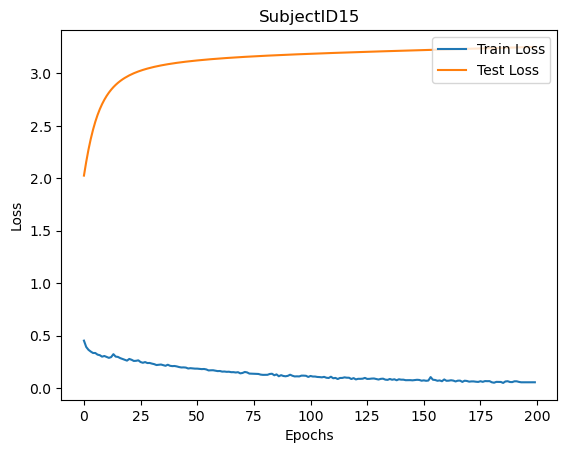

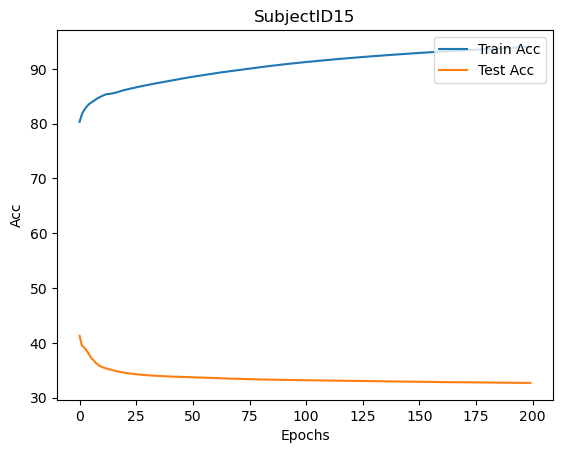

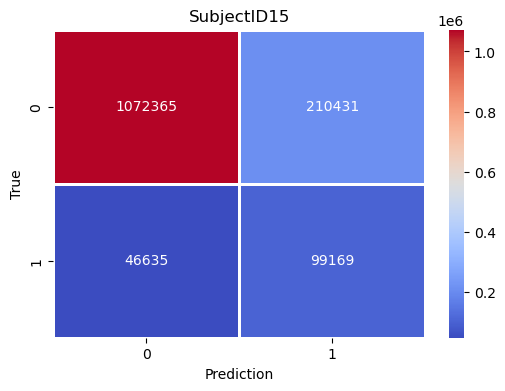

<Figure size 640x480 with 0 Axes>

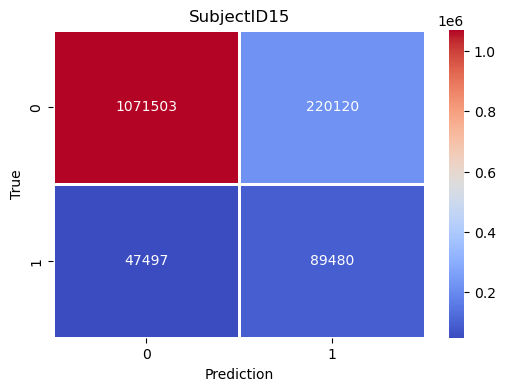

Teacher(RestNet50)_Acc: 0.820057398852023
Teacher(RestNet50)_Rec: 0.6801528078790705
Teacher(RestNet50)_Pre: 0.32031330749354003
Teacher(RestNet50)_F1: 0.435520987957945
Original_Student(Mobilnet)_Acc: 0.8126718465630688
Original_Student(Mobilnet)_Rec: 0.6532483555633427
Original_Student(Mobilnet)_Pre: 0.28901808785529715
Original_Student(Mobilnet)_F1: 0.4007371629080763


<Figure size 640x480 with 0 Axes>

In [15]:

def evaluation(pred,target):
    acu = accuracy_score(pred, target)
    rec = recall_score(pred, target)
    pre = precision_score(pred, target)
    f1 = f1_score(pred, target)  
    return np.array([acu, rec, pre, f1])

#%% Train
Accuracy_teacher = []
Recall_teacher = []
Precision_teacher = []
F1score_teacher = []

Accuracy_student = []
Recall_student = []
Precision_student = []
F1score_student = []


Accuracy_teacher_student = []
Recall_teacher_student = []
Precision_teacher_student = []
F1score_teacher_student = []

teacher_train_preds = []
teacher_train_gt = []


student_train_preds = []
student_train_gt = []

#for i in range(Average_times):
lis = [1,2,3,4,5,7,8,9,10,11,12,13,14,15]
for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i], axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i], axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i], axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i], axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)

            

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode
    ResNet = Net_Teacher(block, [3, 4, 23, 3], 1, 2)
    model_teacher = ResNet.to(device) 
    #model_teacher = MobileNetV3_Large().to(device)
    model_teacher.train()
    
    #model_student = Net_Student(config).to(device) 
    model_student = MobileNetV3_Small().to(device)
    
    #ResNet_S = Net_Student(block, [3, 4, 6, 3], 1, 2)
    #model_student = ResNet_S.to(device)
    model_student.train()
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher = torch.optim.Adam(model_teacher.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    optimizer_student = torch.optim.Adam(model_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Start training and testing Teacher and Student Model
    training_teacher(trainloader,optimizer_teacher,criterion,model_teacher,testloader)
    #testing_teacher(testloader,optimizer_teacher,criterion,model_teacher)
  
    training_student(trainloader,optimizer_student,criterion,model_student,testloader)    
    #testing_student(testloader,optimizer_student,criterion,model_student)

Teacher_eval_table = evaluation(teacher_train_preds, teacher_train_gt)

Student_eval_table = evaluation(student_train_preds, student_train_gt)

show_CM_teacher(teacher_train_preds, teacher_train_gt)
show_CM_student(student_train_preds, student_train_gt)

print("Teacher(RestNet50)_Acc:",Teacher_eval_table[0])
print("Teacher(RestNet50)_Rec:",Teacher_eval_table[1])
print("Teacher(RestNet50)_Pre:",Teacher_eval_table[2])
print("Teacher(RestNet50)_F1:",Teacher_eval_table[3])

print("Original_Student(Mobilnet)_Acc:",Student_eval_table[0])
print("Original_Student(Mobilnet)_Rec:",Student_eval_table[1])
print("Original_Student(Mobilnet)_Pre:",Student_eval_table[2])
print("Original_Student(Mobilnet)_F1:",Student_eval_table[3]) 



Subject 1
| epoch   0 | 0.1156 s/epoch | train loss 2.1368
| epoch   1 | 0.1156 s/epoch | train loss 1.5329
| epoch   2 | 0.1141 s/epoch | train loss 1.3359
| epoch   3 | 0.1148 s/epoch | train loss 1.2475
| epoch   4 | 0.1148 s/epoch | train loss 1.1817
| epoch   5 | 0.1146 s/epoch | train loss 1.1155
| epoch   6 | 0.1148 s/epoch | train loss 1.0744
| epoch   7 | 0.1152 s/epoch | train loss 1.0256
| epoch   8 | 0.1146 s/epoch | train loss 0.9817
| epoch   9 | 0.1156 s/epoch | train loss 0.9349
| epoch  10 | 0.1147 s/epoch | train loss 0.9037
| epoch  11 | 0.1152 s/epoch | train loss 0.8740
| epoch  12 | 0.1151 s/epoch | train loss 0.8789
| epoch  13 | 0.1147 s/epoch | train loss 0.8792
| epoch  14 | 0.1155 s/epoch | train loss 0.8427
| epoch  15 | 0.1150 s/epoch | train loss 0.8232
| epoch  16 | 0.1152 s/epoch | train loss 0.8560
| epoch  17 | 0.1150 s/epoch | train loss 0.7944
| epoch  18 | 0.1153 s/epoch | train loss 0.8107
| epoch  19 | 0.1157 s/epoch | train loss 0.7811
| epoch  

| epoch 167 | 0.1153 s/epoch | train loss 0.4789
| epoch 168 | 0.1157 s/epoch | train loss 0.4630
| epoch 169 | 0.1150 s/epoch | train loss 0.5288
| epoch 170 | 0.1146 s/epoch | train loss 0.4781
| epoch 171 | 0.1149 s/epoch | train loss 0.8334
| epoch 172 | 0.1157 s/epoch | train loss 0.8922
| epoch 173 | 0.1156 s/epoch | train loss 0.8454
| epoch 174 | 0.1157 s/epoch | train loss 0.7454
| epoch 175 | 0.1148 s/epoch | train loss 0.6497
| epoch 176 | 0.1155 s/epoch | train loss 0.6309
| epoch 177 | 0.1159 s/epoch | train loss 0.6066
| epoch 178 | 0.1150 s/epoch | train loss 0.5222
| epoch 179 | 0.1153 s/epoch | train loss 0.5008
| epoch 180 | 0.1159 s/epoch | train loss 0.5158
| epoch 181 | 0.1148 s/epoch | train loss 0.5080
| epoch 182 | 0.1149 s/epoch | train loss 0.4614
| epoch 183 | 0.1151 s/epoch | train loss 0.4495
| epoch 184 | 0.1149 s/epoch | train loss 0.7902
| epoch 185 | 0.1148 s/epoch | train loss 0.6975
| epoch 186 | 0.1151 s/epoch | train loss 0.5833
| epoch 187 | 0.1144

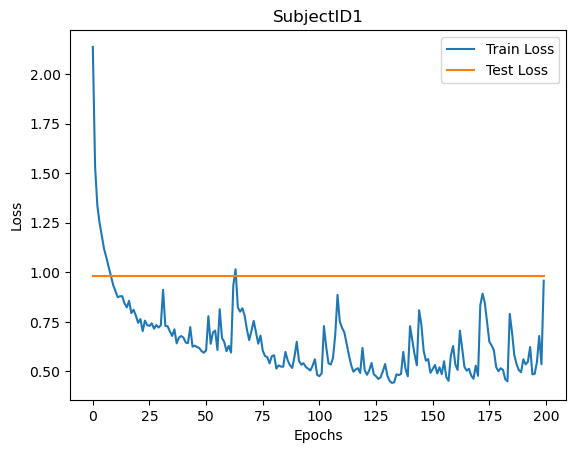

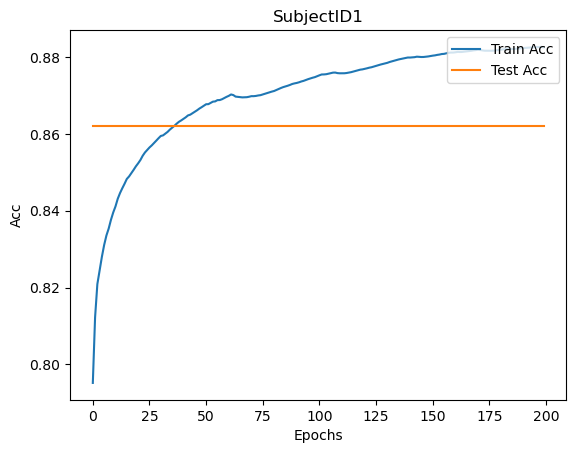


Subject 2
| epoch   0 | 0.1119 s/epoch | train loss 2.2489
| epoch   1 | 0.1122 s/epoch | train loss 1.8047
| epoch   2 | 0.1119 s/epoch | train loss 1.6239
| epoch   3 | 0.1115 s/epoch | train loss 1.6534
| epoch   4 | 0.1121 s/epoch | train loss 1.5401
| epoch   5 | 0.1120 s/epoch | train loss 1.5406
| epoch   6 | 0.1123 s/epoch | train loss 1.3689
| epoch   7 | 0.1123 s/epoch | train loss 1.3399
| epoch   8 | 0.1124 s/epoch | train loss 1.2759
| epoch   9 | 0.1115 s/epoch | train loss 1.3772
| epoch  10 | 0.1123 s/epoch | train loss 1.2208
| epoch  11 | 0.1120 s/epoch | train loss 1.3818
| epoch  12 | 0.1121 s/epoch | train loss 1.7291
| epoch  13 | 0.1122 s/epoch | train loss 1.5076
| epoch  14 | 0.1120 s/epoch | train loss 1.4011
| epoch  15 | 0.1122 s/epoch | train loss 1.2725
| epoch  16 | 0.1125 s/epoch | train loss 1.2513
| epoch  17 | 0.1114 s/epoch | train loss 1.2056
| epoch  18 | 0.1122 s/epoch | train loss 1.1790
| epoch  19 | 0.1122 s/epoch | train loss 1.2721
| epoch  

| epoch 167 | 0.1118 s/epoch | train loss 0.7654
| epoch 168 | 0.1111 s/epoch | train loss 0.6983
| epoch 169 | 0.1126 s/epoch | train loss 0.7173
| epoch 170 | 0.1120 s/epoch | train loss 0.6832
| epoch 171 | 0.1113 s/epoch | train loss 0.6569
| epoch 172 | 0.1110 s/epoch | train loss 0.5887
| epoch 173 | 0.1124 s/epoch | train loss 0.6188
| epoch 174 | 0.1122 s/epoch | train loss 0.6725
| epoch 175 | 0.1123 s/epoch | train loss 0.5890
| epoch 176 | 0.1120 s/epoch | train loss 0.5792
| epoch 177 | 0.1122 s/epoch | train loss 0.6772
| epoch 178 | 0.1119 s/epoch | train loss 0.6133
| epoch 179 | 0.1127 s/epoch | train loss 0.5525
| epoch 180 | 0.1124 s/epoch | train loss 0.5897
| epoch 181 | 0.1116 s/epoch | train loss 0.5753
| epoch 182 | 0.1124 s/epoch | train loss 0.5686
| epoch 183 | 0.1124 s/epoch | train loss 0.6232
| epoch 184 | 0.1116 s/epoch | train loss 0.5420
| epoch 185 | 0.1124 s/epoch | train loss 0.5363
| epoch 186 | 0.1112 s/epoch | train loss 0.5922
| epoch 187 | 0.1116

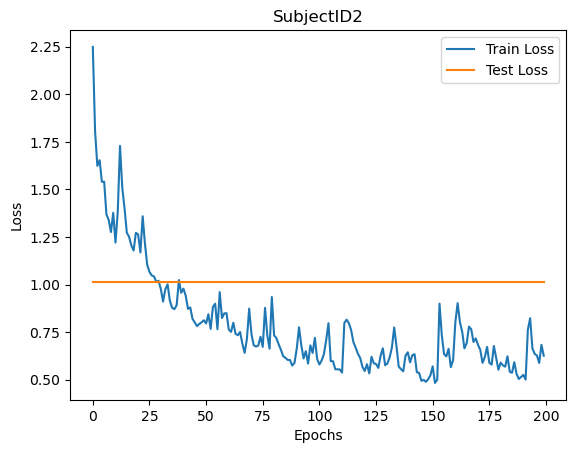

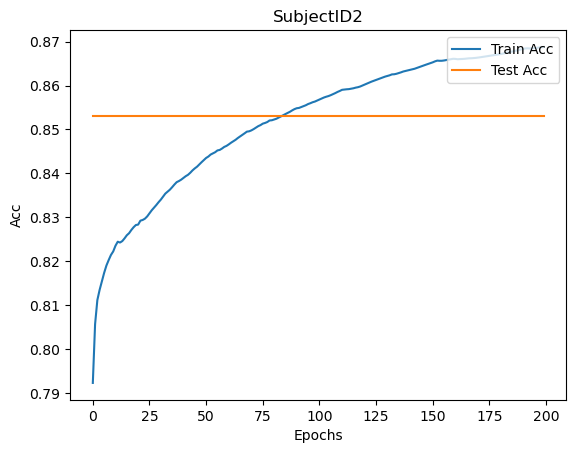


Subject 3
| epoch   0 | 0.1117 s/epoch | train loss 2.2100
| epoch   1 | 0.1124 s/epoch | train loss 1.5638
| epoch   2 | 0.1112 s/epoch | train loss 1.4732
| epoch   3 | 0.1112 s/epoch | train loss 1.3462
| epoch   4 | 0.1121 s/epoch | train loss 1.2335
| epoch   5 | 0.1126 s/epoch | train loss 1.1521
| epoch   6 | 0.1116 s/epoch | train loss 1.0732
| epoch   7 | 0.1115 s/epoch | train loss 1.0627
| epoch   8 | 0.1117 s/epoch | train loss 1.0017
| epoch   9 | 0.1126 s/epoch | train loss 0.9834
| epoch  10 | 0.1120 s/epoch | train loss 0.9858
| epoch  11 | 0.1114 s/epoch | train loss 0.9205
| epoch  12 | 0.1110 s/epoch | train loss 0.9126
| epoch  13 | 0.1125 s/epoch | train loss 0.9022
| epoch  14 | 0.1111 s/epoch | train loss 0.8693
| epoch  15 | 0.1113 s/epoch | train loss 0.8077
| epoch  16 | 0.1118 s/epoch | train loss 0.8124
| epoch  17 | 0.1121 s/epoch | train loss 0.8142
| epoch  18 | 0.1112 s/epoch | train loss 0.7786
| epoch  19 | 0.1113 s/epoch | train loss 0.7680
| epoch  

| epoch 167 | 0.1124 s/epoch | train loss 0.3803
| epoch 168 | 0.1116 s/epoch | train loss 0.3455
| epoch 169 | 0.1113 s/epoch | train loss 0.3474
| epoch 170 | 0.1121 s/epoch | train loss 0.3838
| epoch 171 | 0.1121 s/epoch | train loss 0.3834
| epoch 172 | 0.1116 s/epoch | train loss 0.3586
| epoch 173 | 0.1116 s/epoch | train loss 0.3061
| epoch 174 | 0.1125 s/epoch | train loss 0.3354
| epoch 175 | 0.1117 s/epoch | train loss 0.3199
| epoch 176 | 0.1117 s/epoch | train loss 0.3629
| epoch 177 | 0.1118 s/epoch | train loss 0.5050
| epoch 178 | 0.1111 s/epoch | train loss 0.4156
| epoch 179 | 0.1110 s/epoch | train loss 0.3776
| epoch 180 | 0.1118 s/epoch | train loss 0.3361
| epoch 181 | 0.1119 s/epoch | train loss 0.3779
| epoch 182 | 0.1121 s/epoch | train loss 0.3958
| epoch 183 | 0.1114 s/epoch | train loss 0.3397
| epoch 184 | 0.1126 s/epoch | train loss 0.3306
| epoch 185 | 0.1115 s/epoch | train loss 0.3083
| epoch 186 | 0.1121 s/epoch | train loss 0.3359
| epoch 187 | 0.1118

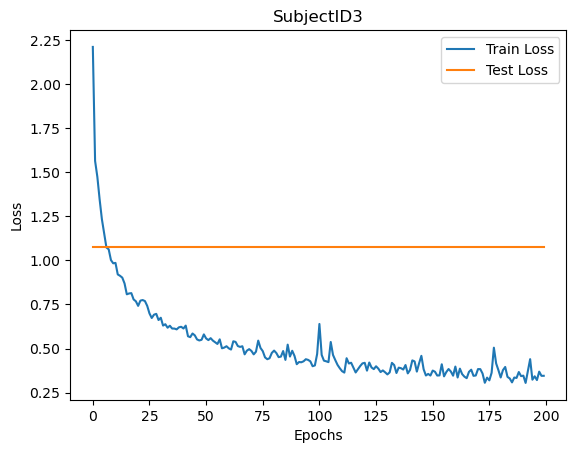

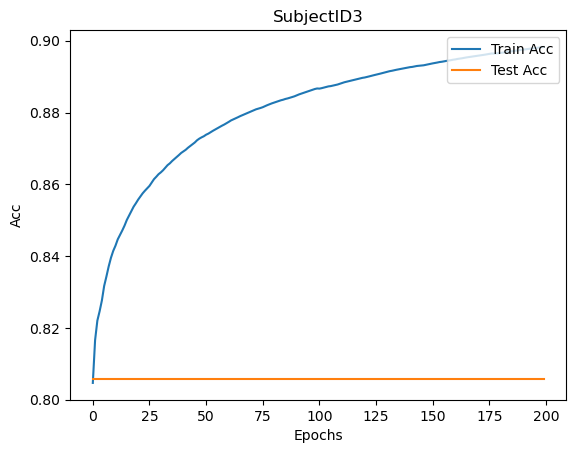


Subject 4
| epoch   0 | 0.1176 s/epoch | train loss 2.1065
| epoch   1 | 0.1180 s/epoch | train loss 1.4796
| epoch   2 | 0.1175 s/epoch | train loss 1.3848
| epoch   3 | 0.1179 s/epoch | train loss 1.2337
| epoch   4 | 0.1178 s/epoch | train loss 1.2279
| epoch   5 | 0.1180 s/epoch | train loss 1.1099
| epoch   6 | 0.1170 s/epoch | train loss 1.0613
| epoch   7 | 0.1170 s/epoch | train loss 1.0617
| epoch   8 | 0.1176 s/epoch | train loss 1.0106
| epoch   9 | 0.1170 s/epoch | train loss 0.9695
| epoch  10 | 0.1172 s/epoch | train loss 0.9401
| epoch  11 | 0.1180 s/epoch | train loss 0.9094
| epoch  12 | 0.1172 s/epoch | train loss 0.9107
| epoch  13 | 0.1180 s/epoch | train loss 0.8885
| epoch  14 | 0.1177 s/epoch | train loss 0.8699
| epoch  15 | 0.1173 s/epoch | train loss 0.8359
| epoch  16 | 0.1171 s/epoch | train loss 0.8477
| epoch  17 | 0.1174 s/epoch | train loss 0.7959
| epoch  18 | 0.1176 s/epoch | train loss 0.8144
| epoch  19 | 0.1183 s/epoch | train loss 0.7681
| epoch  

| epoch 167 | 0.1180 s/epoch | train loss 0.3260
| epoch 168 | 0.1176 s/epoch | train loss 0.3619
| epoch 169 | 0.1176 s/epoch | train loss 0.3165
| epoch 170 | 0.1174 s/epoch | train loss 0.2971
| epoch 171 | 0.1175 s/epoch | train loss 0.3033
| epoch 172 | 0.1176 s/epoch | train loss 0.3192
| epoch 173 | 0.1181 s/epoch | train loss 0.3444
| epoch 174 | 0.1172 s/epoch | train loss 0.3277
| epoch 175 | 0.1172 s/epoch | train loss 0.3134
| epoch 176 | 0.1174 s/epoch | train loss 0.3489
| epoch 177 | 0.1165 s/epoch | train loss 0.3357
| epoch 178 | 0.1172 s/epoch | train loss 0.3352
| epoch 179 | 0.1174 s/epoch | train loss 0.3134
| epoch 180 | 0.1174 s/epoch | train loss 0.3123
| epoch 181 | 0.1168 s/epoch | train loss 0.3858
| epoch 182 | 0.1173 s/epoch | train loss 0.3353
| epoch 183 | 0.1171 s/epoch | train loss 0.3294
| epoch 184 | 0.1174 s/epoch | train loss 0.3219
| epoch 185 | 0.1175 s/epoch | train loss 0.3149
| epoch 186 | 0.1179 s/epoch | train loss 0.3307
| epoch 187 | 0.1179

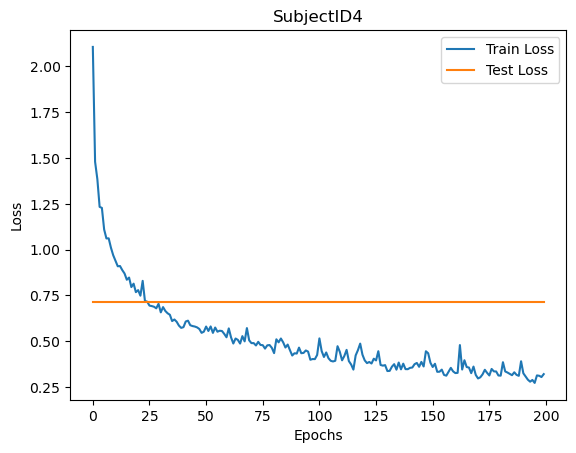

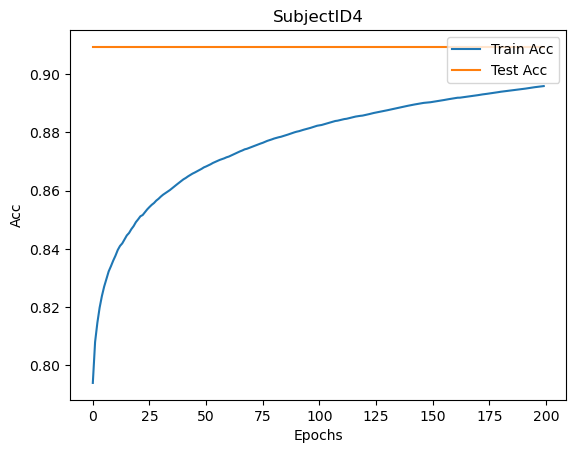


Subject 5
| epoch   0 | 0.1127 s/epoch | train loss 2.1110
| epoch   1 | 0.1121 s/epoch | train loss 1.5291
| epoch   2 | 0.1126 s/epoch | train loss 1.3768
| epoch   3 | 0.1120 s/epoch | train loss 1.2399
| epoch   4 | 0.1120 s/epoch | train loss 1.1890
| epoch   5 | 0.1130 s/epoch | train loss 1.0958
| epoch   6 | 0.1121 s/epoch | train loss 1.0901
| epoch   7 | 0.1126 s/epoch | train loss 1.0074
| epoch   8 | 0.1130 s/epoch | train loss 0.9574
| epoch   9 | 0.1127 s/epoch | train loss 0.9011
| epoch  10 | 0.1123 s/epoch | train loss 0.8970
| epoch  11 | 0.1130 s/epoch | train loss 0.8833
| epoch  12 | 0.1118 s/epoch | train loss 0.8478
| epoch  13 | 0.1120 s/epoch | train loss 0.8764
| epoch  14 | 0.1120 s/epoch | train loss 0.8818
| epoch  15 | 0.1117 s/epoch | train loss 0.8176
| epoch  16 | 0.1118 s/epoch | train loss 0.7858
| epoch  17 | 0.1124 s/epoch | train loss 0.7647
| epoch  18 | 0.1120 s/epoch | train loss 0.7439
| epoch  19 | 0.1128 s/epoch | train loss 0.7296
| epoch  

| epoch 167 | 0.1124 s/epoch | train loss 0.3424
| epoch 168 | 0.1117 s/epoch | train loss 0.3074
| epoch 169 | 0.1118 s/epoch | train loss 0.2903
| epoch 170 | 0.1117 s/epoch | train loss 0.3273
| epoch 171 | 0.1120 s/epoch | train loss 0.3091
| epoch 172 | 0.1118 s/epoch | train loss 0.3609
| epoch 173 | 0.1122 s/epoch | train loss 0.3250
| epoch 174 | 0.1122 s/epoch | train loss 0.3229
| epoch 175 | 0.1127 s/epoch | train loss 0.3339
| epoch 176 | 0.1123 s/epoch | train loss 0.3300
| epoch 177 | 0.1124 s/epoch | train loss 0.3557
| epoch 178 | 0.1118 s/epoch | train loss 0.3220
| epoch 179 | 0.1126 s/epoch | train loss 0.3052
| epoch 180 | 0.1121 s/epoch | train loss 0.3078
| epoch 181 | 0.1117 s/epoch | train loss 0.3055
| epoch 182 | 0.1124 s/epoch | train loss 0.3136
| epoch 183 | 0.1123 s/epoch | train loss 0.3032
| epoch 184 | 0.1115 s/epoch | train loss 0.5430
| epoch 185 | 0.1120 s/epoch | train loss 0.3995
| epoch 186 | 0.1122 s/epoch | train loss 0.3547
| epoch 187 | 0.1124

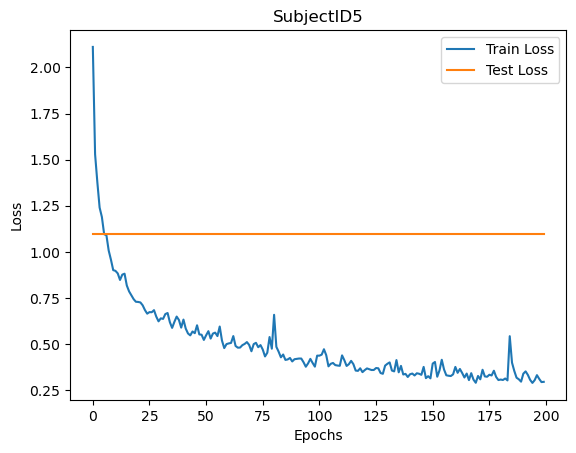

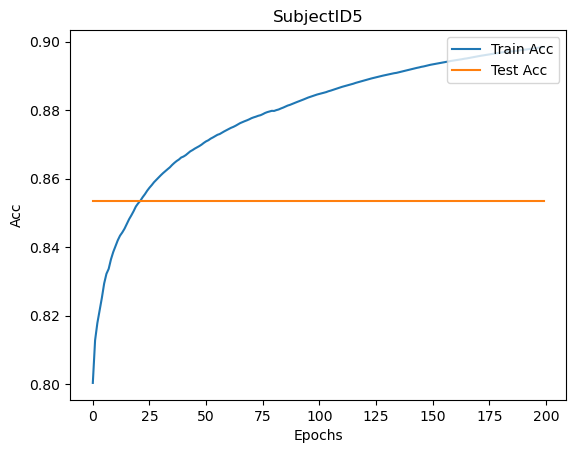


Subject 7
| epoch   0 | 0.1101 s/epoch | train loss 2.1923
| epoch   1 | 0.1100 s/epoch | train loss 1.5046
| epoch   2 | 0.1107 s/epoch | train loss 1.3527
| epoch   3 | 0.1101 s/epoch | train loss 1.2606
| epoch   4 | 0.1084 s/epoch | train loss 1.1852
| epoch   5 | 0.1100 s/epoch | train loss 1.1077
| epoch   6 | 0.1098 s/epoch | train loss 1.0558
| epoch   7 | 0.1102 s/epoch | train loss 1.0381
| epoch   8 | 0.1094 s/epoch | train loss 0.9530
| epoch   9 | 0.1104 s/epoch | train loss 0.9075
| epoch  10 | 0.1106 s/epoch | train loss 0.8854
| epoch  11 | 0.1094 s/epoch | train loss 0.8546
| epoch  12 | 0.1098 s/epoch | train loss 0.8568
| epoch  13 | 0.1094 s/epoch | train loss 0.7887
| epoch  14 | 0.1092 s/epoch | train loss 0.8009
| epoch  15 | 0.1100 s/epoch | train loss 0.7860
| epoch  16 | 0.1102 s/epoch | train loss 0.7731
| epoch  17 | 0.1104 s/epoch | train loss 0.7783
| epoch  18 | 0.1099 s/epoch | train loss 0.7591
| epoch  19 | 0.1097 s/epoch | train loss 0.7268
| epoch  

| epoch 167 | 0.1103 s/epoch | train loss 0.3814
| epoch 168 | 0.1098 s/epoch | train loss 0.4070
| epoch 169 | 0.1102 s/epoch | train loss 0.4868
| epoch 170 | 0.1090 s/epoch | train loss 0.4142
| epoch 171 | 0.1100 s/epoch | train loss 0.3991
| epoch 172 | 0.1095 s/epoch | train loss 0.3834
| epoch 173 | 0.1097 s/epoch | train loss 0.3664
| epoch 174 | 0.1105 s/epoch | train loss 0.3759
| epoch 175 | 0.1093 s/epoch | train loss 0.4036
| epoch 176 | 0.1102 s/epoch | train loss 0.3891
| epoch 177 | 0.1103 s/epoch | train loss 0.3891
| epoch 178 | 0.1100 s/epoch | train loss 0.3910
| epoch 179 | 0.1104 s/epoch | train loss 0.3803
| epoch 180 | 0.1102 s/epoch | train loss 0.3705
| epoch 181 | 0.1106 s/epoch | train loss 0.4379
| epoch 182 | 0.1094 s/epoch | train loss 0.4125
| epoch 183 | 0.1098 s/epoch | train loss 0.3793
| epoch 184 | 0.1101 s/epoch | train loss 0.3645
| epoch 185 | 0.1096 s/epoch | train loss 0.3731
| epoch 186 | 0.1099 s/epoch | train loss 0.3732
| epoch 187 | 0.1108

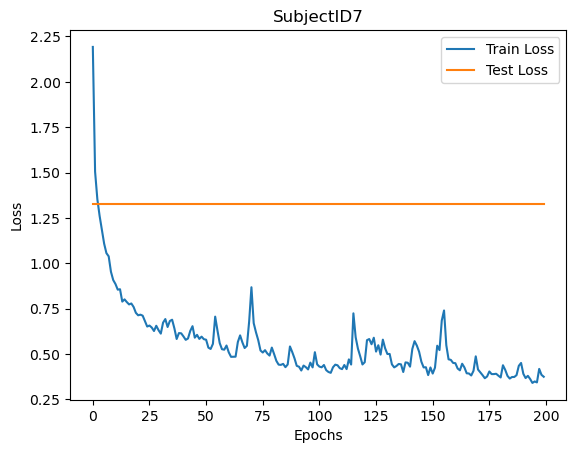

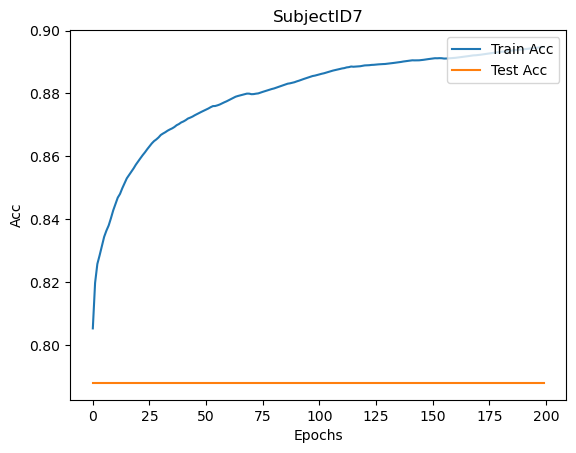


Subject 8
| epoch   0 | 0.1150 s/epoch | train loss 2.2194
| epoch   1 | 0.1150 s/epoch | train loss 1.5246
| epoch   2 | 0.1153 s/epoch | train loss 1.3428
| epoch   3 | 0.1150 s/epoch | train loss 1.2705
| epoch   4 | 0.1161 s/epoch | train loss 1.1676
| epoch   5 | 0.1152 s/epoch | train loss 1.0713
| epoch   6 | 0.1154 s/epoch | train loss 1.0534
| epoch   7 | 0.1142 s/epoch | train loss 0.9877
| epoch   8 | 0.1157 s/epoch | train loss 0.9654
| epoch   9 | 0.1153 s/epoch | train loss 0.9436
| epoch  10 | 0.1151 s/epoch | train loss 0.8995
| epoch  11 | 0.1153 s/epoch | train loss 0.8686
| epoch  12 | 0.1151 s/epoch | train loss 0.8469
| epoch  13 | 0.1159 s/epoch | train loss 0.8650
| epoch  14 | 0.1156 s/epoch | train loss 0.8529
| epoch  15 | 0.1156 s/epoch | train loss 0.8354
| epoch  16 | 0.1148 s/epoch | train loss 0.7854
| epoch  17 | 0.1151 s/epoch | train loss 0.7956
| epoch  18 | 0.1154 s/epoch | train loss 0.7878
| epoch  19 | 0.1149 s/epoch | train loss 0.7907
| epoch  

| epoch 167 | 0.1157 s/epoch | train loss 0.3145
| epoch 168 | 0.1145 s/epoch | train loss 0.3552
| epoch 169 | 0.1153 s/epoch | train loss 0.3300
| epoch 170 | 0.1154 s/epoch | train loss 0.4628
| epoch 171 | 0.1157 s/epoch | train loss 0.3420
| epoch 172 | 0.1155 s/epoch | train loss 0.4143
| epoch 173 | 0.1156 s/epoch | train loss 0.3542
| epoch 174 | 0.1156 s/epoch | train loss 0.3312
| epoch 175 | 0.1162 s/epoch | train loss 0.3155
| epoch 176 | 0.1150 s/epoch | train loss 0.3150
| epoch 177 | 0.1153 s/epoch | train loss 0.3077
| epoch 178 | 0.1155 s/epoch | train loss 0.3027
| epoch 179 | 0.1156 s/epoch | train loss 0.3026
| epoch 180 | 0.1152 s/epoch | train loss 0.3135
| epoch 181 | 0.1150 s/epoch | train loss 0.3056
| epoch 182 | 0.1153 s/epoch | train loss 0.2921
| epoch 183 | 0.1157 s/epoch | train loss 0.2999
| epoch 184 | 0.1151 s/epoch | train loss 0.3096
| epoch 185 | 0.1153 s/epoch | train loss 0.3099
| epoch 186 | 0.1152 s/epoch | train loss 0.2901
| epoch 187 | 0.1152

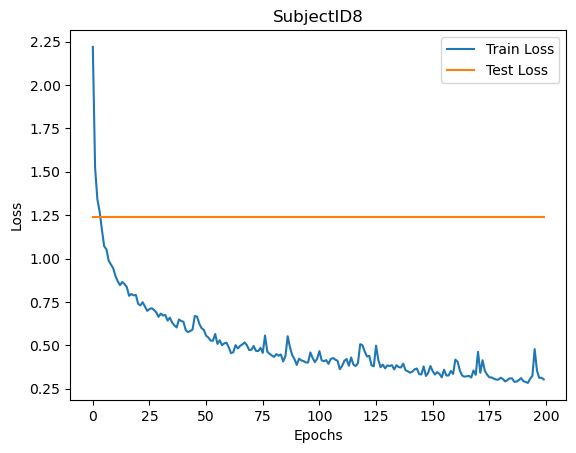

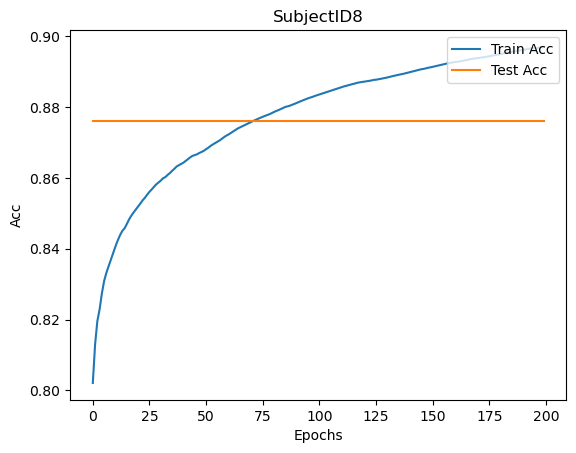


Subject 9
| epoch   0 | 0.1144 s/epoch | train loss 2.1620
| epoch   1 | 0.1134 s/epoch | train loss 1.4741
| epoch   2 | 0.1134 s/epoch | train loss 1.3402
| epoch   3 | 0.1137 s/epoch | train loss 1.2363
| epoch   4 | 0.1129 s/epoch | train loss 1.1913
| epoch   5 | 0.1137 s/epoch | train loss 1.1206
| epoch   6 | 0.1122 s/epoch | train loss 1.0615
| epoch   7 | 0.1132 s/epoch | train loss 0.9997
| epoch   8 | 0.1128 s/epoch | train loss 0.9905
| epoch   9 | 0.1129 s/epoch | train loss 0.9494
| epoch  10 | 0.1131 s/epoch | train loss 0.9073
| epoch  11 | 0.1129 s/epoch | train loss 0.8638
| epoch  12 | 0.1130 s/epoch | train loss 0.8465
| epoch  13 | 0.1129 s/epoch | train loss 0.8268
| epoch  14 | 0.1141 s/epoch | train loss 0.8083
| epoch  15 | 0.1133 s/epoch | train loss 0.8046
| epoch  16 | 0.1131 s/epoch | train loss 0.7727
| epoch  17 | 0.1124 s/epoch | train loss 0.7741
| epoch  18 | 0.1133 s/epoch | train loss 0.7692
| epoch  19 | 0.1138 s/epoch | train loss 0.7404
| epoch  

| epoch 167 | 0.1136 s/epoch | train loss 0.3178
| epoch 168 | 0.1142 s/epoch | train loss 0.3570
| epoch 169 | 0.1137 s/epoch | train loss 0.3556
| epoch 170 | 0.1139 s/epoch | train loss 0.3178
| epoch 171 | 0.1129 s/epoch | train loss 0.3306
| epoch 172 | 0.1135 s/epoch | train loss 0.3229
| epoch 173 | 0.1134 s/epoch | train loss 0.3046
| epoch 174 | 0.1127 s/epoch | train loss 0.5295
| epoch 175 | 0.1141 s/epoch | train loss 0.3796
| epoch 176 | 0.1128 s/epoch | train loss 0.3336
| epoch 177 | 0.1135 s/epoch | train loss 0.3007
| epoch 178 | 0.1135 s/epoch | train loss 0.3038
| epoch 179 | 0.1125 s/epoch | train loss 0.3109
| epoch 180 | 0.1139 s/epoch | train loss 0.3276
| epoch 181 | 0.1129 s/epoch | train loss 0.3198
| epoch 182 | 0.1135 s/epoch | train loss 0.3114
| epoch 183 | 0.1130 s/epoch | train loss 0.3400
| epoch 184 | 0.1126 s/epoch | train loss 0.3380
| epoch 185 | 0.1132 s/epoch | train loss 0.3304
| epoch 186 | 0.1134 s/epoch | train loss 0.3230
| epoch 187 | 0.1125

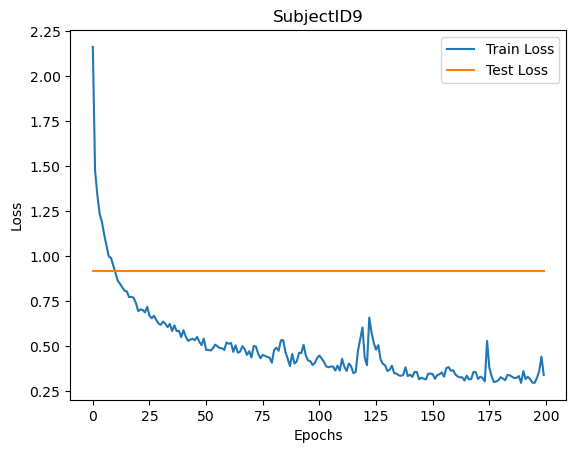

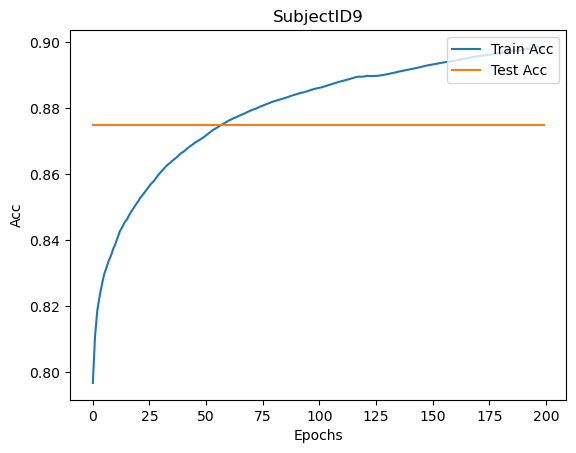


Subject 10
| epoch   0 | 0.1176 s/epoch | train loss 2.1813
| epoch   1 | 0.1177 s/epoch | train loss 1.6728
| epoch   2 | 0.1178 s/epoch | train loss 1.4685
| epoch   3 | 0.1171 s/epoch | train loss 1.3684
| epoch   4 | 0.1160 s/epoch | train loss 1.2692
| epoch   5 | 0.1181 s/epoch | train loss 1.2249
| epoch   6 | 0.1176 s/epoch | train loss 1.1479
| epoch   7 | 0.1177 s/epoch | train loss 1.0935
| epoch   8 | 0.1178 s/epoch | train loss 1.0316
| epoch   9 | 0.1181 s/epoch | train loss 1.0083
| epoch  10 | 0.1177 s/epoch | train loss 1.0098
| epoch  11 | 0.1177 s/epoch | train loss 0.9820
| epoch  12 | 0.1190 s/epoch | train loss 0.9298
| epoch  13 | 0.1178 s/epoch | train loss 0.9404
| epoch  14 | 0.1183 s/epoch | train loss 0.9530
| epoch  15 | 0.1180 s/epoch | train loss 0.9167
| epoch  16 | 0.1173 s/epoch | train loss 0.8875
| epoch  17 | 0.1175 s/epoch | train loss 0.8386
| epoch  18 | 0.1187 s/epoch | train loss 0.8263
| epoch  19 | 0.1182 s/epoch | train loss 0.8256
| epoch 

| epoch 167 | 0.1182 s/epoch | train loss 0.3697
| epoch 168 | 0.1186 s/epoch | train loss 0.3915
| epoch 169 | 0.1188 s/epoch | train loss 0.3708
| epoch 170 | 0.1196 s/epoch | train loss 0.3497
| epoch 171 | 0.1184 s/epoch | train loss 0.3521
| epoch 172 | 0.1191 s/epoch | train loss 0.3604
| epoch 173 | 0.1189 s/epoch | train loss 0.3432
| epoch 174 | 0.1181 s/epoch | train loss 0.3516
| epoch 175 | 0.1188 s/epoch | train loss 0.3499
| epoch 176 | 0.1181 s/epoch | train loss 0.3303
| epoch 177 | 0.1194 s/epoch | train loss 0.3351
| epoch 178 | 0.1185 s/epoch | train loss 0.3873
| epoch 179 | 0.1188 s/epoch | train loss 0.3423
| epoch 180 | 0.1189 s/epoch | train loss 0.4024
| epoch 181 | 0.1185 s/epoch | train loss 0.4759
| epoch 182 | 0.1189 s/epoch | train loss 0.3816
| epoch 183 | 0.1192 s/epoch | train loss 0.3544
| epoch 184 | 0.1180 s/epoch | train loss 0.3271
| epoch 185 | 0.1184 s/epoch | train loss 0.3148
| epoch 186 | 0.1195 s/epoch | train loss 0.3531
| epoch 187 | 0.1184

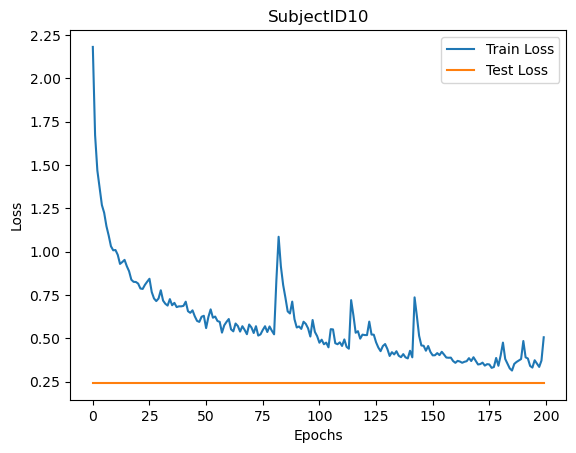

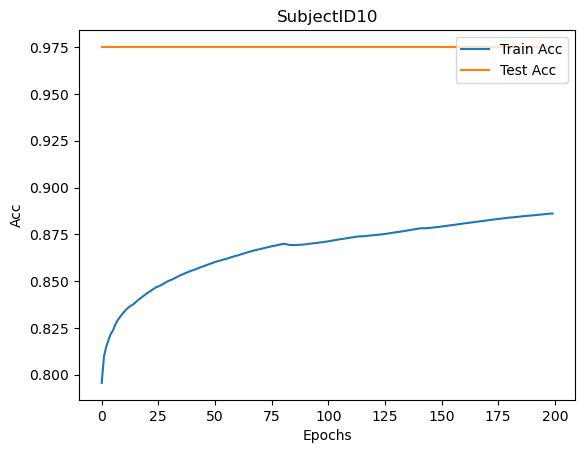


Subject 11
| epoch   0 | 0.1175 s/epoch | train loss 2.1409
| epoch   1 | 0.1177 s/epoch | train loss 1.5928
| epoch   2 | 0.1170 s/epoch | train loss 1.3601
| epoch   3 | 0.1173 s/epoch | train loss 1.2457
| epoch   4 | 0.1177 s/epoch | train loss 1.1740
| epoch   5 | 0.1167 s/epoch | train loss 1.0886
| epoch   6 | 0.1183 s/epoch | train loss 1.0224
| epoch   7 | 0.1171 s/epoch | train loss 0.9864
| epoch   8 | 0.1174 s/epoch | train loss 0.9693
| epoch   9 | 0.1170 s/epoch | train loss 0.9300
| epoch  10 | 0.1181 s/epoch | train loss 0.9003
| epoch  11 | 0.1171 s/epoch | train loss 0.8668
| epoch  12 | 0.1178 s/epoch | train loss 0.8963
| epoch  13 | 0.1180 s/epoch | train loss 0.8574
| epoch  14 | 0.1174 s/epoch | train loss 0.8190
| epoch  15 | 0.1170 s/epoch | train loss 0.8027
| epoch  16 | 0.1171 s/epoch | train loss 0.7788
| epoch  17 | 0.1179 s/epoch | train loss 0.8110
| epoch  18 | 0.1172 s/epoch | train loss 0.7941
| epoch  19 | 0.1171 s/epoch | train loss 0.7785
| epoch 

| epoch 167 | 0.1150 s/epoch | train loss 0.5012
| epoch 168 | 0.1160 s/epoch | train loss 0.7029
| epoch 169 | 0.1155 s/epoch | train loss 0.5338
| epoch 170 | 0.1158 s/epoch | train loss 0.4729
| epoch 171 | 0.1158 s/epoch | train loss 0.4863
| epoch 172 | 0.1120 s/epoch | train loss 0.4542
| epoch 173 | 0.1172 s/epoch | train loss 0.4099
| epoch 174 | 0.1174 s/epoch | train loss 0.3913
| epoch 175 | 0.1178 s/epoch | train loss 0.4015
| epoch 176 | 0.1168 s/epoch | train loss 0.4119
| epoch 177 | 0.1170 s/epoch | train loss 0.3898
| epoch 178 | 0.1173 s/epoch | train loss 0.4007
| epoch 179 | 0.1173 s/epoch | train loss 0.4132
| epoch 180 | 0.1176 s/epoch | train loss 0.3719
| epoch 181 | 0.1165 s/epoch | train loss 0.4822
| epoch 182 | 0.1184 s/epoch | train loss 0.3877
| epoch 183 | 0.1177 s/epoch | train loss 0.3634
| epoch 184 | 0.1171 s/epoch | train loss 0.3559
| epoch 185 | 0.1183 s/epoch | train loss 0.3677
| epoch 186 | 0.1181 s/epoch | train loss 0.3585
| epoch 187 | 0.1175

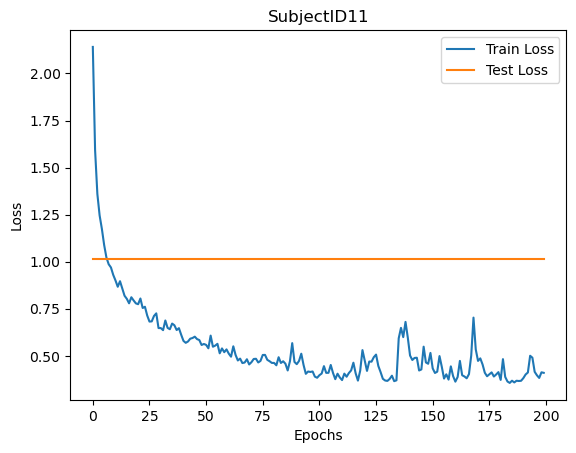

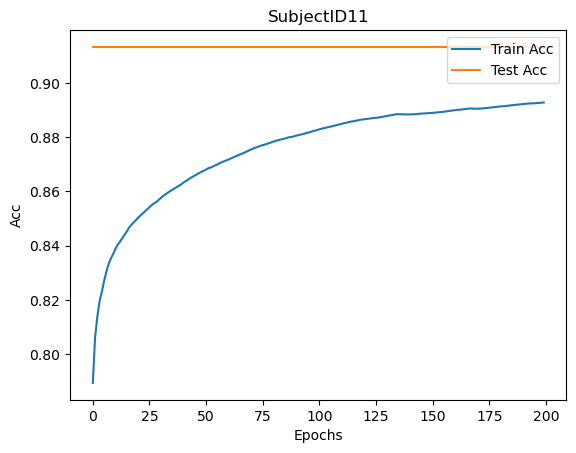


Subject 12
| epoch   0 | 0.1124 s/epoch | train loss 2.2583
| epoch   1 | 0.1121 s/epoch | train loss 1.5302
| epoch   2 | 0.1110 s/epoch | train loss 1.3800
| epoch   3 | 0.1116 s/epoch | train loss 1.2741
| epoch   4 | 0.1116 s/epoch | train loss 1.2045
| epoch   5 | 0.1120 s/epoch | train loss 1.1425
| epoch   6 | 0.1111 s/epoch | train loss 1.0539
| epoch   7 | 0.1123 s/epoch | train loss 1.0770
| epoch   8 | 0.1124 s/epoch | train loss 1.1271
| epoch   9 | 0.1117 s/epoch | train loss 1.0234
| epoch  10 | 0.1116 s/epoch | train loss 1.0539
| epoch  11 | 0.1117 s/epoch | train loss 0.9612
| epoch  12 | 0.1119 s/epoch | train loss 0.9714
| epoch  13 | 0.1120 s/epoch | train loss 1.0351
| epoch  14 | 0.1129 s/epoch | train loss 0.9277
| epoch  15 | 0.1117 s/epoch | train loss 0.8622
| epoch  16 | 0.1119 s/epoch | train loss 0.8744
| epoch  17 | 0.1112 s/epoch | train loss 0.8916
| epoch  18 | 0.1116 s/epoch | train loss 0.8497
| epoch  19 | 0.1123 s/epoch | train loss 0.7976
| epoch 

| epoch 167 | 0.1114 s/epoch | train loss 0.4899
| epoch 168 | 0.1114 s/epoch | train loss 0.4524
| epoch 169 | 0.1125 s/epoch | train loss 0.4792
| epoch 170 | 0.1109 s/epoch | train loss 0.4398
| epoch 171 | 0.1111 s/epoch | train loss 0.4455
| epoch 172 | 0.1120 s/epoch | train loss 0.4111
| epoch 173 | 0.1118 s/epoch | train loss 0.4036
| epoch 174 | 0.1117 s/epoch | train loss 0.4429
| epoch 175 | 0.1115 s/epoch | train loss 0.5587
| epoch 176 | 0.1120 s/epoch | train loss 0.5133
| epoch 177 | 0.1124 s/epoch | train loss 0.5116
| epoch 178 | 0.1122 s/epoch | train loss 0.6001
| epoch 179 | 0.1116 s/epoch | train loss 0.5793
| epoch 180 | 0.1120 s/epoch | train loss 0.8679
| epoch 181 | 0.1120 s/epoch | train loss 0.6907
| epoch 182 | 0.1121 s/epoch | train loss 0.6309
| epoch 183 | 0.1118 s/epoch | train loss 0.5715
| epoch 184 | 0.1114 s/epoch | train loss 0.5791
| epoch 185 | 0.1116 s/epoch | train loss 0.5333
| epoch 186 | 0.1117 s/epoch | train loss 0.5444
| epoch 187 | 0.1116

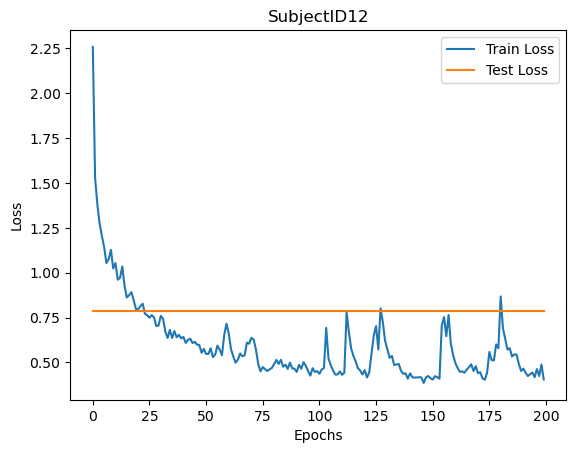

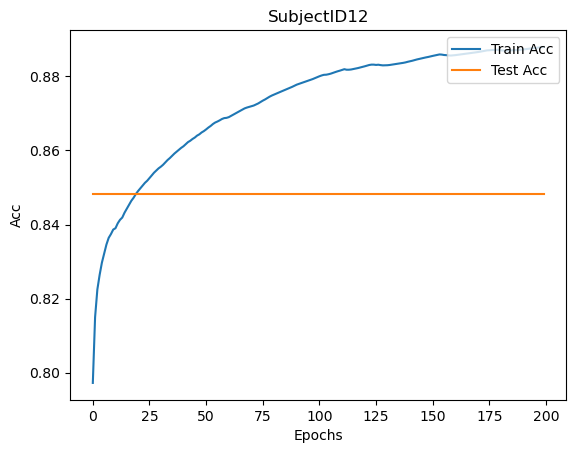


Subject 13
| epoch   0 | 0.1122 s/epoch | train loss 2.1165
| epoch   1 | 0.1117 s/epoch | train loss 1.4815
| epoch   2 | 0.1125 s/epoch | train loss 1.3189
| epoch   3 | 0.1116 s/epoch | train loss 1.2605
| epoch   4 | 0.1117 s/epoch | train loss 1.1825
| epoch   5 | 0.1121 s/epoch | train loss 1.0847
| epoch   6 | 0.1117 s/epoch | train loss 1.0251
| epoch   7 | 0.1120 s/epoch | train loss 1.0094
| epoch   8 | 0.1116 s/epoch | train loss 0.9477
| epoch   9 | 0.1127 s/epoch | train loss 0.9045
| epoch  10 | 0.1117 s/epoch | train loss 0.9219
| epoch  11 | 0.1123 s/epoch | train loss 0.8734
| epoch  12 | 0.1115 s/epoch | train loss 0.8779
| epoch  13 | 0.1118 s/epoch | train loss 0.8247
| epoch  14 | 0.1122 s/epoch | train loss 0.8445
| epoch  15 | 0.1117 s/epoch | train loss 0.8049
| epoch  16 | 0.1126 s/epoch | train loss 0.7935
| epoch  17 | 0.1118 s/epoch | train loss 0.7531
| epoch  18 | 0.1120 s/epoch | train loss 0.7999
| epoch  19 | 0.1117 s/epoch | train loss 0.7548
| epoch 

| epoch 167 | 0.1129 s/epoch | train loss 0.4949
| epoch 168 | 0.1132 s/epoch | train loss 0.4683
| epoch 169 | 0.1147 s/epoch | train loss 0.4486
| epoch 170 | 0.1125 s/epoch | train loss 0.4620
| epoch 171 | 0.1151 s/epoch | train loss 0.4394
| epoch 172 | 0.1138 s/epoch | train loss 0.4210
| epoch 173 | 0.1148 s/epoch | train loss 0.4164
| epoch 174 | 0.1425 s/epoch | train loss 0.4105
| epoch 175 | 0.1439 s/epoch | train loss 0.4174
| epoch 176 | 0.1527 s/epoch | train loss 0.4537
| epoch 177 | 0.1405 s/epoch | train loss 0.4292
| epoch 178 | 0.1450 s/epoch | train loss 0.4743
| epoch 179 | 0.1486 s/epoch | train loss 0.4363
| epoch 180 | 0.1513 s/epoch | train loss 0.5005
| epoch 181 | 0.1475 s/epoch | train loss 0.4696
| epoch 182 | 0.1442 s/epoch | train loss 0.4216
| epoch 183 | 0.1528 s/epoch | train loss 0.3963
| epoch 184 | 0.1480 s/epoch | train loss 0.3916
| epoch 185 | 0.1420 s/epoch | train loss 0.3992
| epoch 186 | 0.1444 s/epoch | train loss 0.3690
| epoch 187 | 0.1486

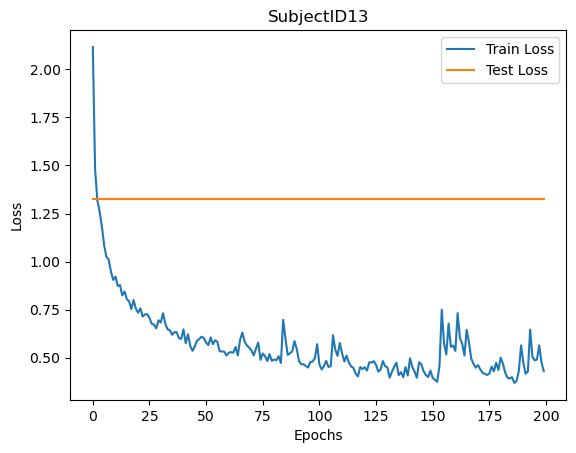

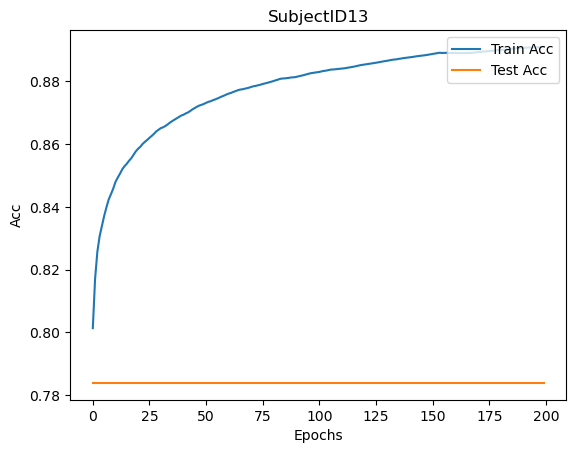


Subject 14
| epoch   0 | 0.1513 s/epoch | train loss 2.0776
| epoch   1 | 0.1478 s/epoch | train loss 1.5544
| epoch   2 | 0.1491 s/epoch | train loss 1.4037
| epoch   3 | 0.1488 s/epoch | train loss 1.3523
| epoch   4 | 0.1482 s/epoch | train loss 1.3113
| epoch   5 | 0.1494 s/epoch | train loss 1.2896
| epoch   6 | 0.1517 s/epoch | train loss 1.2455
| epoch   7 | 0.1512 s/epoch | train loss 1.4465
| epoch   8 | 0.1464 s/epoch | train loss 1.2729
| epoch   9 | 0.1524 s/epoch | train loss 1.5770
| epoch  10 | 0.1589 s/epoch | train loss 1.3482
| epoch  11 | 0.1514 s/epoch | train loss 1.2610
| epoch  12 | 0.1585 s/epoch | train loss 1.3192
| epoch  13 | 0.1572 s/epoch | train loss 1.1677
| epoch  14 | 0.1539 s/epoch | train loss 1.1379
| epoch  15 | 0.1525 s/epoch | train loss 1.1335
| epoch  16 | 0.1555 s/epoch | train loss 1.0173
| epoch  17 | 0.1525 s/epoch | train loss 1.0482
| epoch  18 | 0.1254 s/epoch | train loss 0.9765
| epoch  19 | 0.1198 s/epoch | train loss 0.9753
| epoch 

| epoch 167 | 0.1412 s/epoch | train loss 0.4514
| epoch 168 | 0.1370 s/epoch | train loss 0.4712
| epoch 169 | 0.1369 s/epoch | train loss 0.4964
| epoch 170 | 0.1426 s/epoch | train loss 0.4452
| epoch 171 | 0.1403 s/epoch | train loss 0.4026
| epoch 172 | 0.1392 s/epoch | train loss 0.4439
| epoch 173 | 0.1412 s/epoch | train loss 0.4137
| epoch 174 | 0.1401 s/epoch | train loss 0.4752
| epoch 175 | 0.1337 s/epoch | train loss 1.0320
| epoch 176 | 0.1172 s/epoch | train loss 0.8342
| epoch 177 | 0.1172 s/epoch | train loss 0.7800
| epoch 178 | 0.1165 s/epoch | train loss 0.7026
| epoch 179 | 0.1168 s/epoch | train loss 0.6417
| epoch 180 | 0.1169 s/epoch | train loss 0.6183
| epoch 181 | 0.1165 s/epoch | train loss 0.5875
| epoch 182 | 0.1174 s/epoch | train loss 0.5959
| epoch 183 | 0.1167 s/epoch | train loss 0.5827
| epoch 184 | 0.1165 s/epoch | train loss 0.6166
| epoch 185 | 0.1168 s/epoch | train loss 0.5508
| epoch 186 | 0.1167 s/epoch | train loss 0.5623
| epoch 187 | 0.1165

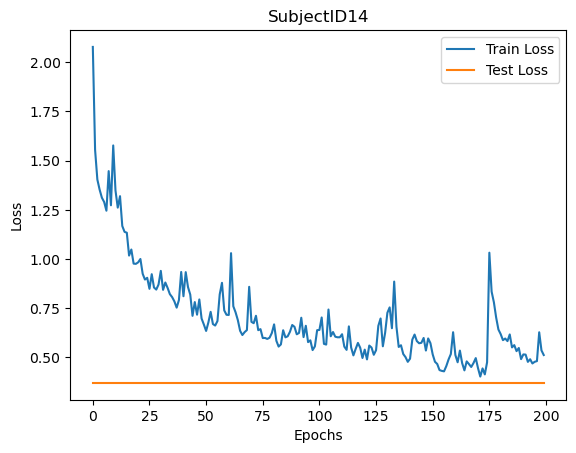

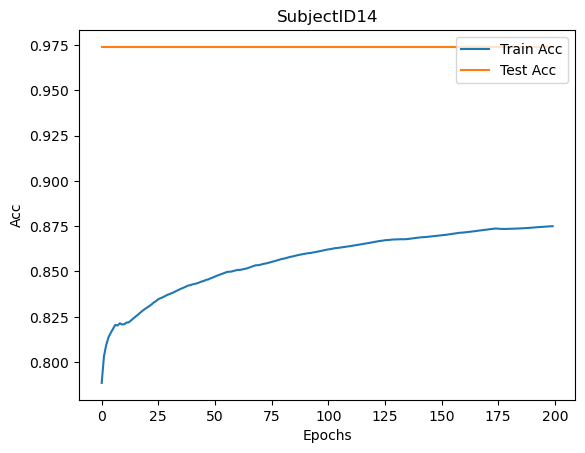


Subject 15
| epoch   0 | 0.1204 s/epoch | train loss 2.0723
| epoch   1 | 0.1193 s/epoch | train loss 1.4796
| epoch   2 | 0.1205 s/epoch | train loss 1.3378
| epoch   3 | 0.1206 s/epoch | train loss 1.2373
| epoch   4 | 0.1200 s/epoch | train loss 1.1269
| epoch   5 | 0.1203 s/epoch | train loss 1.1305
| epoch   6 | 0.1196 s/epoch | train loss 1.0317
| epoch   7 | 0.1196 s/epoch | train loss 0.9633
| epoch   8 | 0.1194 s/epoch | train loss 0.9722
| epoch   9 | 0.1166 s/epoch | train loss 0.9437
| epoch  10 | 0.1222 s/epoch | train loss 0.9109
| epoch  11 | 0.1222 s/epoch | train loss 0.8787
| epoch  12 | 0.1219 s/epoch | train loss 0.8495
| epoch  13 | 0.1211 s/epoch | train loss 0.8385
| epoch  14 | 0.1224 s/epoch | train loss 0.8411
| epoch  15 | 0.1217 s/epoch | train loss 0.8132
| epoch  16 | 0.1219 s/epoch | train loss 0.7914
| epoch  17 | 0.1219 s/epoch | train loss 0.7610
| epoch  18 | 0.1213 s/epoch | train loss 0.7629
| epoch  19 | 0.1293 s/epoch | train loss 0.7329
| epoch 

| epoch 167 | 0.1462 s/epoch | train loss 0.3274
| epoch 168 | 0.1386 s/epoch | train loss 0.3335
| epoch 169 | 0.1469 s/epoch | train loss 0.3042
| epoch 170 | 0.1463 s/epoch | train loss 0.3141
| epoch 171 | 0.1443 s/epoch | train loss 0.3274
| epoch 172 | 0.1464 s/epoch | train loss 0.3089
| epoch 173 | 0.1467 s/epoch | train loss 0.3144
| epoch 174 | 0.1403 s/epoch | train loss 0.3293
| epoch 175 | 0.1444 s/epoch | train loss 0.3249
| epoch 176 | 0.1462 s/epoch | train loss 0.3087
| epoch 177 | 0.1434 s/epoch | train loss 0.2985
| epoch 178 | 0.1445 s/epoch | train loss 0.2967
| epoch 179 | 0.1439 s/epoch | train loss 0.3378
| epoch 180 | 0.1428 s/epoch | train loss 0.3115
| epoch 181 | 0.1426 s/epoch | train loss 0.3078
| epoch 182 | 0.1433 s/epoch | train loss 0.2845
| epoch 183 | 0.1442 s/epoch | train loss 0.3003
| epoch 184 | 0.1433 s/epoch | train loss 0.2910
| epoch 185 | 0.1439 s/epoch | train loss 0.3059
| epoch 186 | 0.1441 s/epoch | train loss 0.2970
| epoch 187 | 0.1443

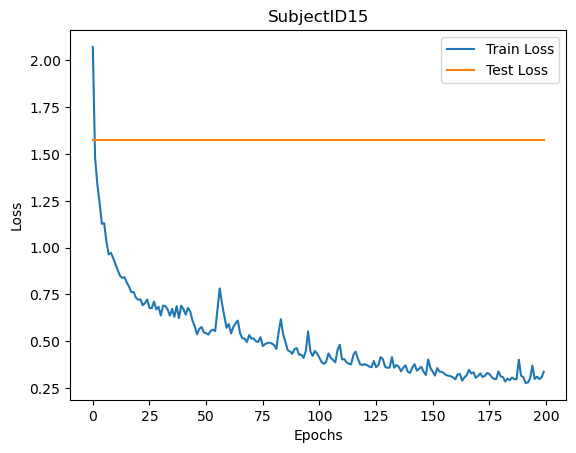

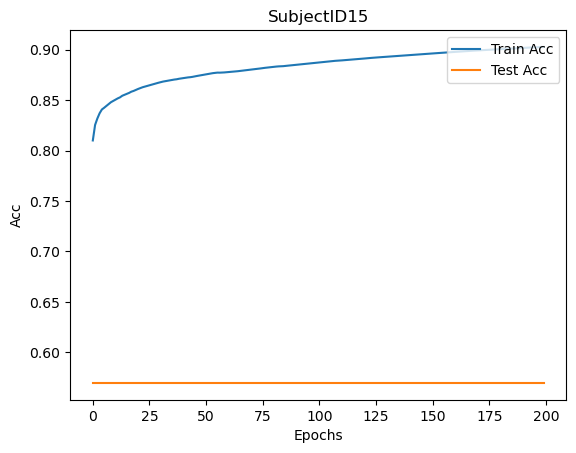

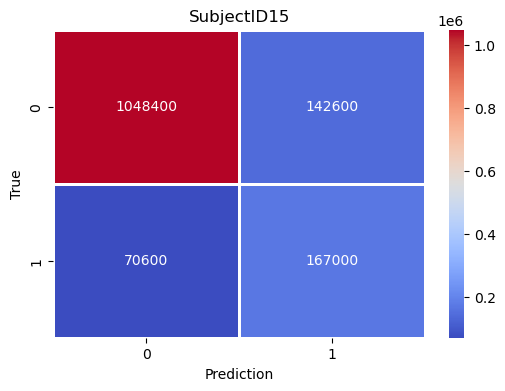

Distillation_Student(Mobilnet)_Acc: 0.8507629847403052
Distillation_Student(Mobilnet)_Rec: 0.7028619528619529
Distillation_Student(Mobilnet)_Pre: 0.539405684754522
Distillation_Student(Mobilnet)_F1: 0.6103801169590644


<Figure size 640x480 with 0 Axes>

In [16]:
teacher_student_train_preds = []
teacher_student_train_gt = []


for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i], axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i], axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i], axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i], axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)
        

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode

    #model_teacher_student = Net_Teacher_Student(config).to(device) 
    model_teacher_student = MobileNetV3_Small_KD().to(device)
    #ResNet_TS = Net_Teacher_Student(block, [3, 4, 6, 3], 1, 2)
    #model_teacher_student = ResNet_TS.to(device)
    model_teacher_student.train() 
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher_student = torch.optim.Adam(model_teacher_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Establishing Teacher-Student Model
    alpha = 0.5
    training_teacher_student(trainloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student,alpha,testloader)
    #testing_teacher_student(testloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student)
    
show_CM_teacher_student(teacher_student_train_preds, teacher_student_train_gt)
teacher_Student_eval_table = evaluation(teacher_student_train_preds, teacher_student_train_gt)    

print("Distillation_Student(Mobilnet)_Acc:",teacher_Student_eval_table[0])
print("Distillation_Student(Mobilnet)_Rec:",teacher_Student_eval_table[1])
print("Distillation_Student(Mobilnet)_Pre:",teacher_Student_eval_table[2])
print("Distillation_Student(Mobilnet)_F1:",teacher_Student_eval_table[3])



In [17]:
# print("Teacher(MobileNetV3_Large)_Acc:",sum(Accuracy_teacher)/14)
# print("Teacher(MobileNetV3_Large)_Rec:",sum(Recall_teacher)/11)
# print("Teacher(MobileNetV3_Large)_Pre:",sum(Precision_teacher)/11)
# print("Teacher(MobileNetV3_Large)_F1:",sum(F1score_teacher)/11)

# print("Original_Student(MobileNetV3_Small)_Acc:",sum(Accuracy_student)/14)
# print("Original_Student(MobileNetV3_Small)_Rec:",sum(Recall_student)/11)
# print("Original_Student(MobileNetV3_Small)_Pre:",sum(Precision_student)/11)
# print("Original_Student(MobileNetV3_Small)_F1:",sum(F1score_student)/11)

# print("Distillation_Student(MobileNetV3_Small_KD)_Acc:",sum(Accuracy_teacher_student)/14)
# print("Distillation_Student(MobileNetV3_Small_KD)_Rec:",sum(Recall_teacher_student)/11)
# print("Distillation_Student(MobileNetV3_Small_KD)_Pre:",sum(Precision_teacher_student)/11)
# print("Distillation_Student(MobileNetV3_Small_KD)_F1:",sum(F1score_teacher_student)/11,'\n')

dummy_input = torch.randn(64,1,14,3,device=device)
flops_teacher, params_teachar = profile(model_teacher,(dummy_input,))
print('\n\nflops_teacher: %.3f M, params_teachar: %.3f M' % (flops_teacher / 1000000.0, params_teachar / 1000000.0))
flops_student, params_student = profile(model_student,(dummy_input,))
print('flops_student: %.3f M, params_student: %.3f M' % (flops_student / 1000000.0, params_student / 1000000.0))
flops_teacher_student, params_teacher_student = profile(model_teacher_student,(dummy_input,))
print('flops_teacher_student: %.3f M, params_teacher_student: %.3f M' % (flops_teacher_student / 1000000.0, params_teacher_student / 1000000.0))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


flops_teacher: 4743.021 M, params_teachar: 42.495 M
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 